## Dependencies and imports

In [117]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [118]:
#!pip install pycocotools

In [2]:
import sys
sys.path.insert(0, "../../../efficientdet-pytorch")
sys.path.insert(0, "../../../omegaconf")
sys.path.insert(0, "../")

In [3]:
import torch
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet

from metrics import eval_metrics

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

ModuleNotFoundError: No module named 'effdet'

In [4]:
DATA_DIR = '/relevance2-nfs/chec/data/wheat'

In [7]:
marking = pd.read_csv(f'{DATA_DIR}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/home/core/.local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In [9]:
marking.head()

image_id  width  height   source      x      y      w      h
0  b6ab77fd7   1024    1024  usask_1  834.0  222.0   56.0   36.0
1  b6ab77fd7   1024    1024  usask_1  226.0  548.0  130.0   58.0
2  b6ab77fd7   1024    1024  usask_1  377.0  504.0   74.0  160.0
3  b6ab77fd7   1024    1024  usask_1  834.0   95.0  109.0  107.0
4  b6ab77fd7   1024    1024  usask_1   26.0  144.0  124.0  117.0

In [10]:
df_folds.head()

bbox_count     source stratify_group  fold
image_id                                             
00333207f          55  arvalis_1    arvalis_1_3     4
005b0d8bb          20    usask_1      usask_1_1     2
006a994f7          25    inrae_1      inrae_1_1     2
00764ad5d          41    inrae_1      inrae_1_2     2
00b5fefed          25  arvalis_3    arvalis_3_1     1

In [125]:
image_files = os.listdir(os.path.join(DATA_DIR, 'train'))
all_img_ids = [x.split('.')[0] for x in image_files]
no_box_images = set(all_img_ids) - set(marking.image_id.unique())

## Albumentations

In [126]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                #A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.Blur(blur_limit=3, p=0.2),
            A.ToGray(p=0.1),
            #A.GaussianBlur(p=1),
            #A.RGBShift(p=1),
            #A.RandomSnow(p=1),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset

In [127]:
TRAIN_ROOT_PATH = f'{DATA_DIR}/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.yxyx = True
        self.img_size = 1024

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test:
            image, boxes = self.load_image_and_boxes(index)
            if boxes is None:
                boxes = np.array([[0., 0., 1., 1.]])
                labels = torch.tensor([2.]).long()
            # there is only one class
            else:
                labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        else:
            r = random.random()
            if r < 0.1:
                image, boxes = self.load_image_and_boxes(index)
            elif r < 0.2:
                #print('mixup1')
                image, boxes = self.mixup1(index)
            elif r < 0.6:
                #print('mixup3')
                image, boxes = self.mixup3(index)
            else:
                #print('cutmix')
                image, boxes = self.load_cutmix_image_and_boxes(index)

            # there is only one class
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        if len(records) < 1:
            return image, None
        #print(records)
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        #print('>>>boxes:', boxes)
        #print('image shape:', image.shape)
        return image, boxes
    
    def mixup1(self, index):
        img, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        rimg, rboxes = self.load_image_and_boxes(rindex)
        
        mixup_image = (img + rimg)/2
        mixup_boxes = np.concatenate([boxes, rboxes], 0)
        #print(boxes.shape, rboxes.shape, mixup_boxes.shape)
        
        return mixup_image, mixup_boxes
    
    def mixup3(self, index):
        image, boxes = self.load_image_and_boxes(index)
        rindex = random.randint(0, self.image_ids.shape[0] - 1)
        r_image, r_boxes = self.load_image_and_boxes(rindex)


        #for box in r_boxes.astype(int):
        #    cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        imsize = image.shape[0]
        w,h = imsize, imsize
        s = imsize // 2

        xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
        direct = random.randint(0, 3)

        result_image = image.copy()
        result_boxes = []

        if direct == 0:
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif direct == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif direct == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif direct == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        padw = x1a - x1b
        padh = y1a - y1b

        r_boxes[:, 0] += padw
        r_boxes[:, 1] += padh
        r_boxes[:, 2] += padw
        r_boxes[:, 3] += padh

        result_boxes.append(r_boxes)

        result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 

        cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
        cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
        cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]

        #for box in boxes.astype(int):
        #    cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)

        #for box in result_boxes.astype(int):
        #    cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

        #ax[i][0].imshow(image)
        #ax[i][1].imshow(r_image)
        #ax[i][2].imshow(result_image)
        
        return result_image, np.concatenate([result_boxes, boxes])

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes
    
    def load_mosaic(self, index):
        # loads images in a mosaic
        
        labels4 = []
        s = self.img_size
        xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.image_ids) - 1) for _ in range(3)]  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load image
            img, boxes  = self.load_image_and_boxes(index)
            h, w = 1024, 1024

            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            x = boxes #self.labels[index]
            
            labels = x.copy()
            if x.size > 0:  # Normalized xywh to pixel xyxy format
                labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
                labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
                labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
                labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
            labels4.append(labels)

        # Concat/clip labels
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
            # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
            np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

        # Augment
        # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
        img4, labels4 = self.random_affine(img4, labels4,
                                      degrees=1.98 * 2,
                                      translate=0.05 * 2,
                                      scale=0.05 * 2,
                                      shear=0.641 * 2,
                                      border=-s // 2)  # border to remove

        return img4, labels4
    
    def random_affine(self, img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
        # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
        # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

        if targets is None:  # targets = [cls, xyxy]
            targets = []
        height = img.shape[0] + border * 2
        width = img.shape[1] + border * 2

        # Rotation and Scale
        R = np.eye(3)
        a = random.uniform(-degrees, degrees)
        # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
        s = random.uniform(1 - scale, 1 + scale)
        R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

        # Translation
        T = np.eye(3)
        T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
        T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

        # Shear
        S = np.eye(3)
        S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
        S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

        # Combined rotation matrix
        M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
        if (border != 0) or (M != np.eye(3)).any():  # image changed
            img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

        # Transform label coordinates
        n = len(targets)
        if n:
            # warp points
            xy = np.ones((n * 4, 3))
            xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
            xy = (xy @ M.T)[:, :2].reshape(n, 8)

            # create new boxes
            x = xy[:, [0, 2, 4, 6]]
            y = xy[:, [1, 3, 5, 7]]
            xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

            # # apply angle-based reduction of bounding boxes
            # radians = a * math.pi / 180
            # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
            # x = (xy[:, 2] + xy[:, 0]) / 2
            # y = (xy[:, 3] + xy[:, 1]) / 2
            # w = (xy[:, 2] - xy[:, 0]) * reduction
            # h = (xy[:, 3] - xy[:, 1]) * reduction
            # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

            # reject warped points outside of image
            xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
            xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
            w = xy[:, 2] - xy[:, 0]
            h = xy[:, 3] - xy[:, 1]
            area = w * h
            area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
            ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
            i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

            targets = targets[i]
            targets[:, 1:5] = xy[i]

        return img, targets

In [128]:
def get_train_val_datasets(fold=0):
    val_ids_all = np.concatenate([df_folds[df_folds['fold'] == fold].index.values, np.array(list(no_box_images))], 0)

    train_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] != fold].index.values,
        marking=marking,
        transforms=get_train_transforms(),
        test=False,
    )

    validation_dataset = DatasetRetriever(
        image_ids=val_ids_all,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )
    return train_dataset, validation_dataset

In [129]:
#fold_number = 0
train_dataset, validation_datase = get_train_val_datasets(0)

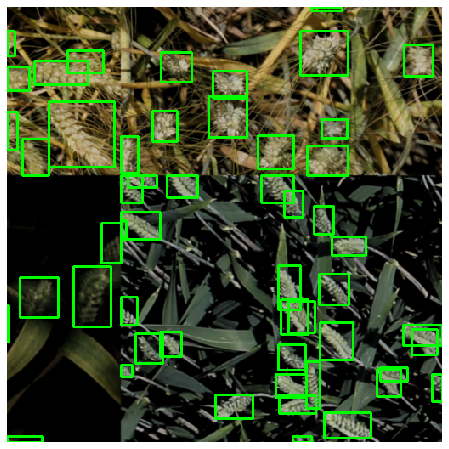

In [130]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

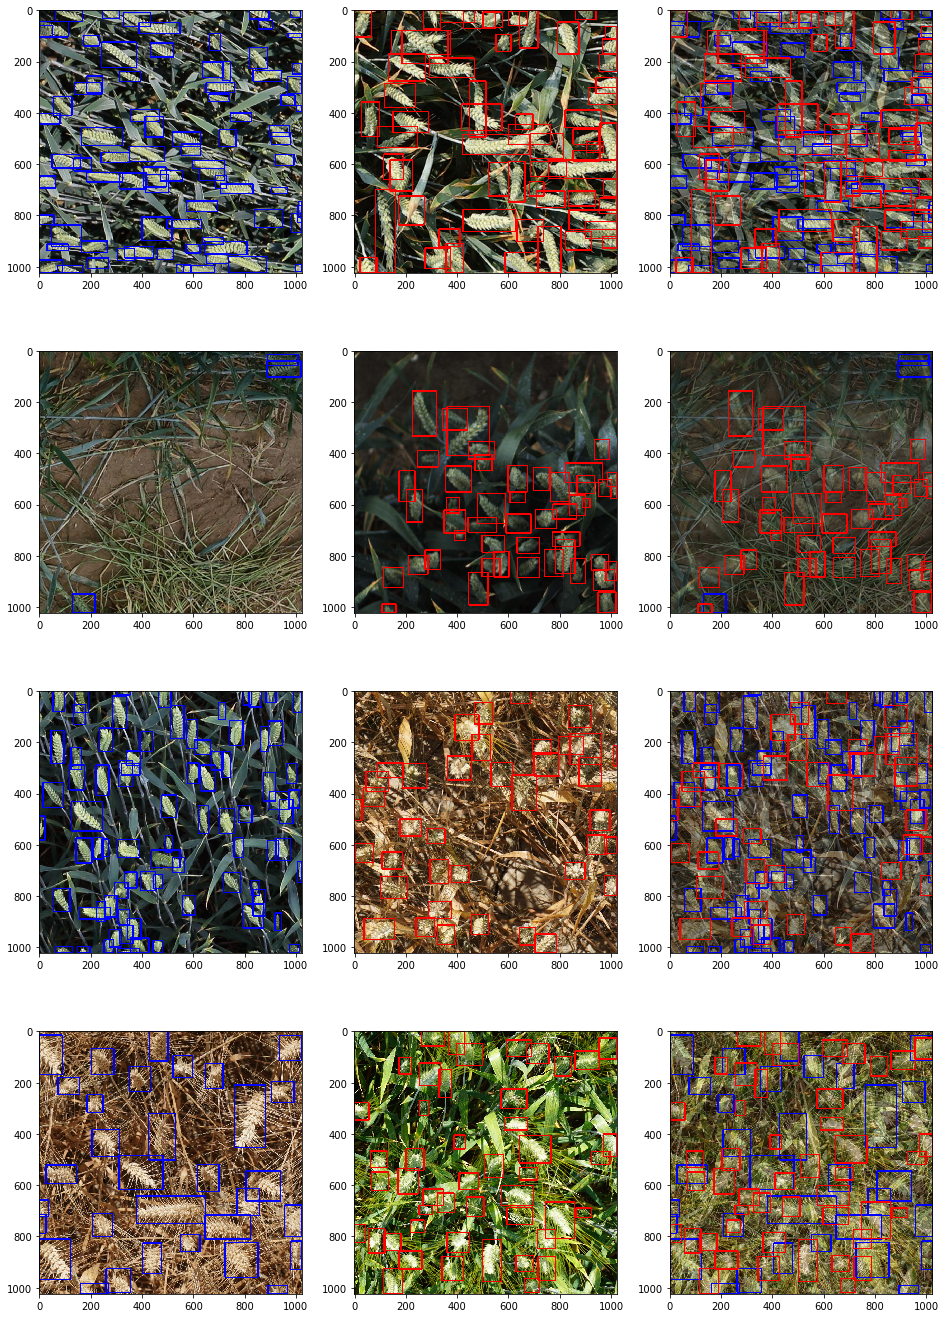

In [131]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    mixup_image = (image+r_image)/2

    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        cv2.rectangle(mixup_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(mixup_image)

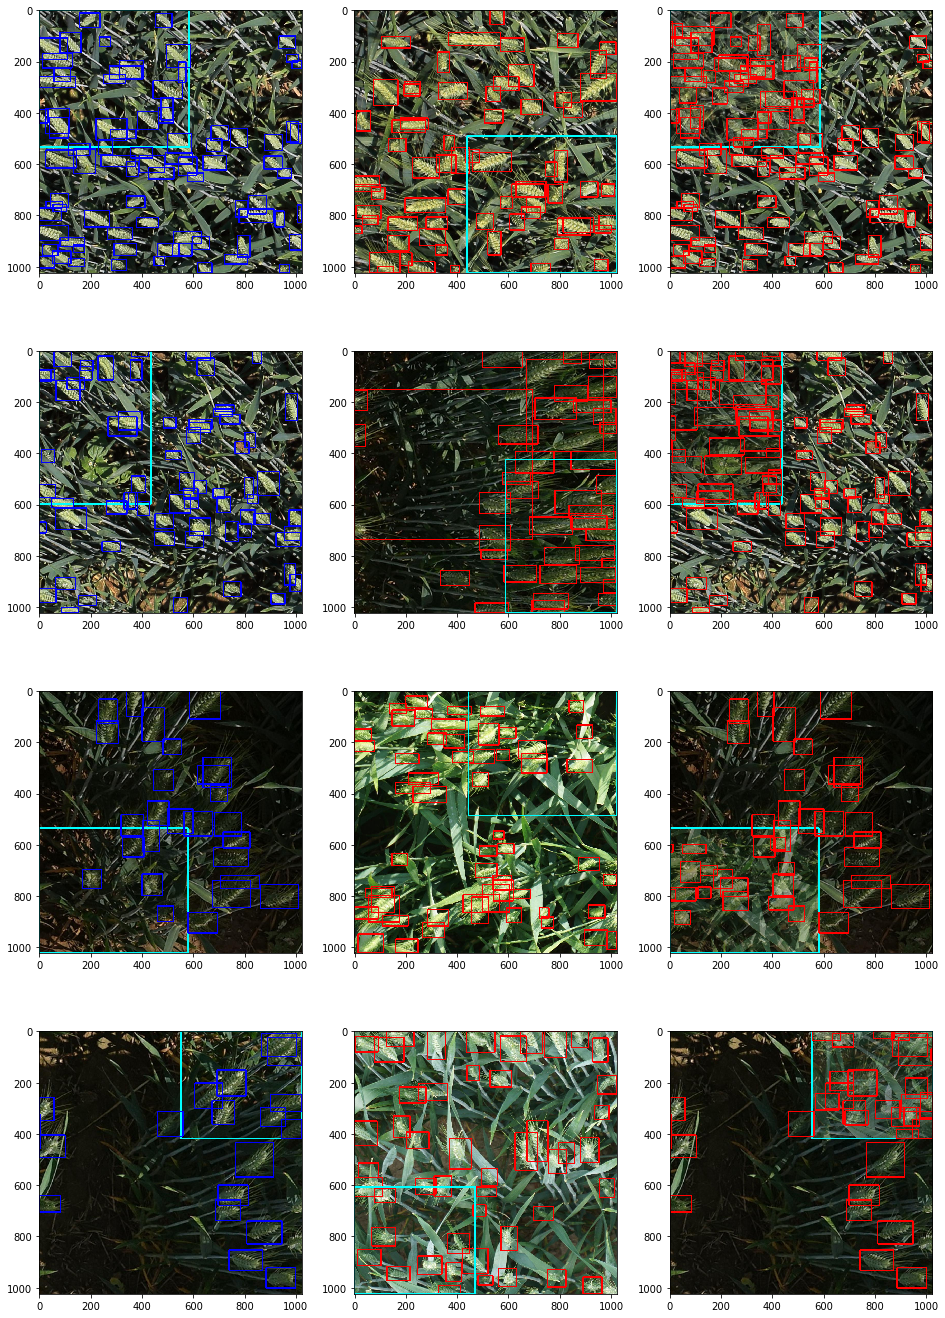

In [132]:
count = 4

fig, ax = plt.subplots(count, 3, figsize=(16, 6*count))

for i in range(count):
    image, boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    r_image, r_boxes = train_dataset.load_image_and_boxes(random.randint(0, train_dataset.image_ids.shape[0] - 1))
    
    for box in r_boxes.astype(int):
        cv2.rectangle(r_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)

    imsize = image.shape[0]
    w,h = imsize, imsize
    s = imsize // 2

    xc, yc = [int(random.uniform(imsize * 0.4, imsize * 0.6)) for _ in range(2)]
    direct = random.randint(0, 3)

    result_image = image.copy()
    result_boxes = []

    if direct == 0:
        x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
    elif direct == 1:  # top right
        x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
        x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
    elif direct == 2:  # bottom left
        x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
    elif direct == 3:  # bottom right
        x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
        x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

    padw = x1a - x1b
    padh = y1a - y1b

    r_boxes[:, 0] += padw
    r_boxes[:, 1] += padh
    r_boxes[:, 2] += padw
    r_boxes[:, 3] += padh

    result_boxes.append(r_boxes)

    result_image[y1a:y2a, x1a:x2a] = (result_image[y1a:y2a, x1a:x2a] + r_image[y1b:y2b, x1b:x2b]) / 2 
    
    cv2.rectangle(image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    cv2.rectangle(r_image,(x1b, y1b),(x2b,  y2b),(0, 1, 1), 5)
    cv2.rectangle(result_image,(x1a, y1a),(x2a,  y2a),(0, 1, 1), 5)
    
    result_boxes = np.concatenate(result_boxes, 0)
    np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
    result_boxes = result_boxes.astype(np.int32)
    result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
    
    for box in boxes.astype(int):
        cv2.rectangle(image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        #cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(0, 0, 1), 3)
        
    for box in np.concatenate([result_boxes,boxes]).astype(int):
        cv2.rectangle(result_image,(box[0], box[1]),(box[2],  box[3]),(1, 0, 0), 3)
        
    ax[i][0].imshow(image)
    ax[i][1].imshow(r_image)
    ax[i][2].imshow(result_image)

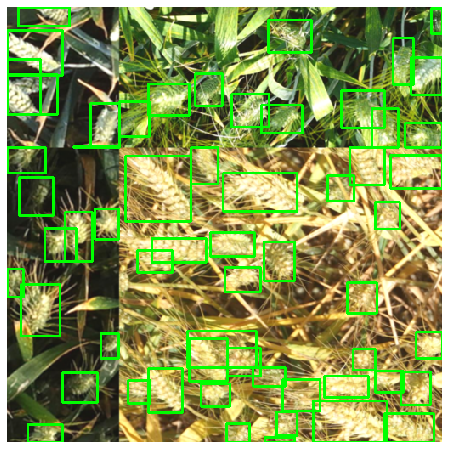

In [133]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

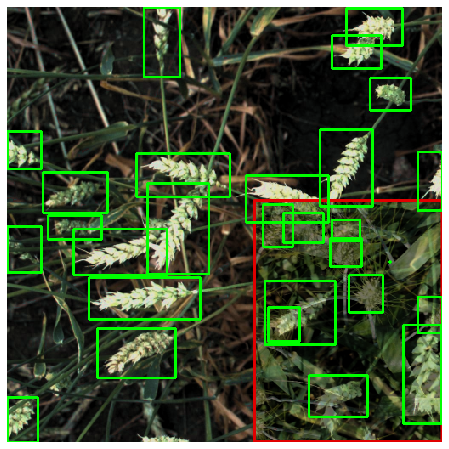

In [134]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

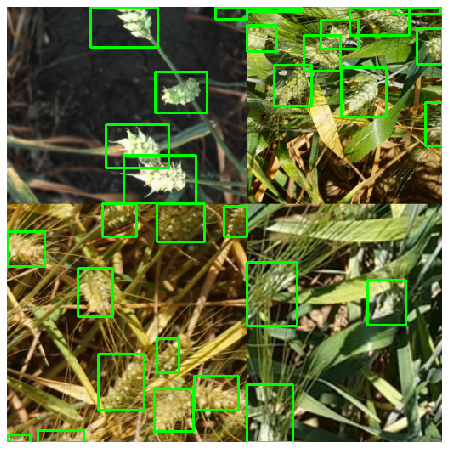

In [135]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

## Fitter

In [136]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [137]:
f'{1+2}'

'3'

In [138]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log_{self.config.ifold}.txt'
        #self.best_summary_loss = 10**5
        self.best_score = 0.
        self.model_file_best = f'{self.base_dir}/best-fold-{self.config.ifold}.pth'
        self.model_file_last = f'{self.base_dir}/last-fold-{self.config.ifold}.pth'

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.lr)
        #self.optimizer = torch.optim.SGD(self.model.parameters(), lr=config.lr, momentum=0.9, weight_decay=1e-4)
        lrs_config = config.lrs[config.lrs_name]
        self.scheduler = lrs_config['schedule_class'](self.optimizer, **lrs_config['schedule_params'])
        #self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def lrs_step(self, metrics):
        if self.config.lrs_name == 'plateau':
            self.scheduler.step(metrics)
        else:
            self.scheduler.step()

    def fit(self, train_loader, validation_loader):
        if self.load_best():
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)

            metrics = self.validation(validation_loader)
            self.best_score = metrics['best_score']
            print(metrics)
        else:
            if not isinstance(self.model.model, nn.DataParallel):
                self.model.model = nn.DataParallel(self.model.model)
        
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(self.model_file_last)

            t = time.time()
            metrics = self.validation(validation_loader)

            #self.log(f'[RESULT]: Val. Epoch: {self.epoch}, score: {metrics['best_score']}, \
            #    best: {self.best_score}, time: {(time.time() - t):.5f}')
            self.log('[VAL RESULT] Epoch {}, score: {}, best: {}, time: {:.5f}'.format(
                self.epoch, metrics['best_score'], self.best_score, (time.time() - t
            )))
            print(metrics)
            
            if metrics['best_score'] > self.best_score:
                self.best_score = metrics['best_score']
                self.model.eval()
                self.save(self.model_file_best)
                print('**saved**')
                
                #self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                #for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                #    os.remove(path)

            if self.config.validation_scheduler:
                #self.scheduler.step(metrics=summary_loss.avg)
                self.lrs_step(metrics=metrics['best_score'])

            self.epoch += 1

    def get_eval_det_model(self, model):
        config = get_efficientdet_config('tf_efficientdet_d5')
        config.num_classes = 1
        config.image_size = 512
        return DetBenchEval(model, config).cuda()
    
    def validation(self, val_loader):
        self.model.eval()
        eval_model = self.get_eval_det_model(self.model.model)
        metrics = eval_metrics(eval_model, val_loader)
        
        return metrics
        
    def validation_old(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                #self.scheduler.step()
                self.lrs_step(summary_loss.avg)

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        model_state = self.model.model.module.state_dict() if isinstance(self.model.model, nn.DataParallel) else self.model.model.state_dict()
        torch.save({
            'model_state_dict': model_state,
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_score': self.best_score,
            'epoch': self.epoch,
        }, path)

    def load_best(self):
        if os.path.exists(self.model_file_best):
            print(f'loading {self.model_file_best}...')
            self.load(self.model_file_best)
            return True
        else:
            print(f'{self.model_file_best} does not exist')
            return False

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        #self.best_score = checkpoint['best_score']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [139]:
#os.path.exists('a')

In [140]:
class TrainGlobalConfig:
    num_workers = 24
    batch_size = 30
    n_epochs = 300 # n_epochs = 40
    lr = 1e-4

    folder = 'ed5-mixup' #'effdet5-cutmix-augmix' #'ed5-mixup'
    ifold = 0

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss
    
    lrs_name = 'cosine' # plateau, cosine
    lrs = {
        'cosine': {
            'schedule_class': torch.optim.lr_scheduler.CosineAnnealingLR,
            'schedule_params': dict(
                T_max=12,
                eta_min=1e-6
            )
        },
        'plateau': {
            'schedule_class': torch.optim.lr_scheduler.ReduceLROnPlateau,
            'schedule_params': dict(
                mode='max',
                factor=0.5,
                patience=2,
                verbose=False, 
                threshold=0.0001,
                threshold_mode='abs',
                cooldown=0, 
                min_lr=2e-6,
                eps=1e-8
            )
        }
    }
    
    # --------------------
    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos', 
    #         final_div_factor=10**5
    #     )


In [141]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda')
    net.to(device)
    #net.cuda()
    #net.model = nn.DataParallel(net.model)
    
    train_dataset, validation_dataset = get_train_val_datasets(TrainGlobalConfig.ifold)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [142]:
#!pip install typing_extensions

In [143]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=True)
    checkpoint = torch.load('./pretrained/efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    
    return DetBenchTrain(net, config)

net = get_net()

In [144]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-0.pth...



{'best_score': 0.70335, 'best_threshold': 0.42, 0.3: 0.69062, 0.37: 0.70297, 0.4: 0.70219, 0.42: 0.70335, 0.45: 0.70144, 0.5: 0.69038, 0.55: 0.6688, 0.6: 0.63257}

2020-05-27T18:34:43.208749
LR: 0.0001
[RESULT]: Train. Epoch: 76, summary_loss: 0.43549, time: 189.55882



[VAL RESULT] Epoch 76, score: 0.703, best: 0.70335, time: 36.49260
{'best_score': 0.703, 'best_threshold': 0.41, 0.3: 0.68656, 0.37: 0.70048, 0.4: 0.70193, 0.42: 0.70196, 0.45: 0.69896, 0.5: 0.68997, 0.55: 0.66878, 0.6: 0.6355}

2020-05-27T18:38:32.951193
LR: 9.831332840130888e-05
[RESULT]: Train. Epoch: 77, summary_loss: 0.43311, time: 181.92753



[VAL RESULT] Epoch 77, score: 0.70208, best: 0.70335, time: 35.50488
{'best_score': 0.70208, 'best_threshold': 0.41, 0.3: 0.6894, 0.37: 0.70116, 0.4: 0.70047, 0.42: 0.70135, 0.45: 0.69865, 0.5: 0.68756, 0.55: 0.66142, 0.6: 0.62246}

2020-05-27T18:42:13.055338
LR: 9.336825748732972e-05
[RESULT]: Train. Epoch: 78, summary_loss: 0.43121, time: 177.81075



[VAL RESULT] Epoch 78, score: 0.69343, best: 0.70335, time: 35.32717
{'best_score': 0.69343, 'best_threshold': 0.39, 0.3: 0.67712, 0.37: 0.69341, 0.4: 0.69253, 0.42: 0.69142, 0.45: 0.68847, 0.5: 0.67872, 0.55: 0.66031, 0.6: 0.62631}

2020-05-27T18:45:48.941861
LR: 8.55017856687341e-05
[RESULT]: Train. Epoch: 79, summary_loss: 0.43362, time: 179.65657



[VAL RESULT] Epoch 79, score: 0.70093, best: 0.70335, time: 35.59367
{'best_score': 0.70093, 'best_threshold': 0.39, 0.3: 0.68373, 0.37: 0.69752, 0.4: 0.70044, 0.42: 0.70036, 0.45: 0.69665, 0.5: 0.68876, 0.55: 0.66731, 0.6: 0.63301}

2020-05-27T18:49:27.598862
LR: 7.525e-05
[RESULT]: Train. Epoch: 80, summary_loss: 0.42799, time: 179.27803



[VAL RESULT] Epoch 80, score: 0.69956, best: 0.70335, time: 35.48409
{'best_score': 0.69956, 'best_threshold': 0.4, 0.3: 0.68488, 0.37: 0.69904, 0.4: 0.69956, 0.42: 0.69873, 0.45: 0.69606, 0.5: 0.68731, 0.55: 0.66639, 0.6: 0.63292}

2020-05-27T18:53:05.326210
LR: 6.331154273257477e-05
[RESULT]: Train. Epoch: 81, summary_loss: 0.42812, time: 179.15732



[VAL RESULT] Epoch 81, score: 0.70033, best: 0.70335, time: 36.33058
{'best_score': 0.70033, 'best_threshold': 0.38, 0.3: 0.68343, 0.37: 0.69889, 0.4: 0.69957, 0.42: 0.69984, 0.45: 0.69797, 0.5: 0.68651, 0.55: 0.66498, 0.6: 0.62479}

2020-05-27T18:56:43.629924
LR: 5.0499999999999994e-05
[RESULT]: Train. Epoch: 82, summary_loss: 0.42613, time: 181.13414



[VAL RESULT] Epoch 82, score: 0.70423, best: 0.70335, time: 36.26810
{'best_score': 0.70423, 'best_threshold': 0.38, 0.3: 0.68934, 0.37: 0.70393, 0.4: 0.70333, 0.42: 0.70241, 0.45: 0.69933, 0.5: 0.68977, 0.55: 0.66979, 0.6: 0.63474}
**saved**

2020-05-27T19:00:26.938268
LR: 3.768845726742522e-05
[RESULT]: Train. Epoch: 83, summary_loss: 0.42816, time: 180.76071



[VAL RESULT] Epoch 83, score: 0.70215, best: 0.70423, time: 36.14929
{'best_score': 0.70215, 'best_threshold': 0.39, 0.3: 0.68677, 0.37: 0.70062, 0.4: 0.70173, 0.42: 0.70096, 0.45: 0.69884, 0.5: 0.68958, 0.55: 0.66943, 0.6: 0.63032}

2020-05-27T19:04:06.952655
LR: 2.575000000000001e-05
[RESULT]: Train. Epoch: 84, summary_loss: 0.42534, time: 179.96430



[VAL RESULT] Epoch 84, score: 0.70315, best: 0.70423, time: 36.35257
{'best_score': 0.70315, 'best_threshold': 0.4, 0.3: 0.6817, 0.37: 0.70225, 0.4: 0.70315, 0.42: 0.70223, 0.45: 0.69871, 0.5: 0.69146, 0.55: 0.66948, 0.6: 0.63297}

2020-05-27T19:07:46.353705
LR: 1.54982143312659e-05
[RESULT]: Train. Epoch: 85, summary_loss: 0.42680, time: 179.97456



[VAL RESULT] Epoch 85, score: 0.70526, best: 0.70423, time: 36.00077
{'best_score': 0.70526, 'best_threshold': 0.4, 0.3: 0.68269, 0.37: 0.70334, 0.4: 0.70526, 0.42: 0.7038, 0.45: 0.70136, 0.5: 0.69019, 0.55: 0.6704, 0.6: 0.63524}
**saved**

2020-05-27T19:11:27.894384
LR: 7.631742512670284e-06
[RESULT]: Train. Epoch: 86, summary_loss: 0.42808, time: 179.74571



[VAL RESULT] Epoch 86, score: 0.70308, best: 0.70526, time: 35.78916
{'best_score': 0.70308, 'best_threshold': 0.38, 0.3: 0.68362, 0.37: 0.70154, 0.4: 0.70246, 0.42: 0.70208, 0.45: 0.6998, 0.5: 0.69027, 0.55: 0.67123, 0.6: 0.63581}

2020-05-27T19:15:06.448430
LR: 2.6866715986911244e-06
[RESULT]: Train. Epoch: 87, summary_loss: 0.42714, time: 179.11860



[VAL RESULT] Epoch 87, score: 0.70424, best: 0.70526, time: 35.49468
{'best_score': 0.70424, 'best_threshold': 0.39, 0.3: 0.68432, 0.37: 0.70254, 0.4: 0.70367, 0.42: 0.70364, 0.45: 0.70117, 0.5: 0.69194, 0.55: 0.67314, 0.6: 0.63956}

2020-05-27T19:18:43.811967
LR: 1e-06
[RESULT]: Train. Epoch: 88, summary_loss: 0.42608, time: 179.93702



[VAL RESULT] Epoch 88, score: 0.70327, best: 0.70526, time: 36.45387
{'best_score': 0.70327, 'best_threshold': 0.42, 0.3: 0.68387, 0.37: 0.69929, 0.4: 0.70276, 0.42: 0.70327, 0.45: 0.70022, 0.5: 0.69264, 0.55: 0.67391, 0.6: 0.64035}

2020-05-27T19:22:22.970419
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 89, summary_loss: 0.42498, time: 179.50371



[VAL RESULT] Epoch 89, score: 0.70428, best: 0.70526, time: 35.35442
{'best_score': 0.70428, 'best_threshold': 0.39, 0.3: 0.68454, 0.37: 0.70102, 0.4: 0.70396, 0.42: 0.70357, 0.45: 0.70147, 0.5: 0.69203, 0.55: 0.6723, 0.6: 0.63905}

2020-05-27T19:26:00.524664
LR: 7.63174251267028e-06
[RESULT]: Train. Epoch: 90, summary_loss: 0.42491, time: 179.12445



[VAL RESULT] Epoch 90, score: 0.70372, best: 0.70526, time: 35.57917
{'best_score': 0.70372, 'best_threshold': 0.43, 0.3: 0.68311, 0.37: 0.70134, 0.4: 0.70319, 0.42: 0.7025, 0.45: 0.70145, 0.5: 0.69256, 0.55: 0.67538, 0.6: 0.64057}

2020-05-27T19:29:39.567285
LR: 1.549821433126588e-05
[RESULT]: Train. Epoch: 91, summary_loss: 0.42477, time: 179.06375



[VAL RESULT] Epoch 91, score: 0.70583, best: 0.70526, time: 39.60813
{'best_score': 0.70583, 'best_threshold': 0.38, 0.3: 0.68904, 0.37: 0.70579, 0.4: 0.70546, 0.42: 0.70395, 0.45: 0.70102, 0.5: 0.6914, 0.55: 0.67002, 0.6: 0.63375}
**saved**

2020-05-27T19:33:24.194564
LR: 2.574999999999998e-05
[RESULT]: Train. Epoch: 92, summary_loss: 0.42348, time: 177.80556



[VAL RESULT] Epoch 92, score: 0.70189, best: 0.70583, time: 36.56873
{'best_score': 0.70189, 'best_threshold': 0.39, 0.3: 0.68464, 0.37: 0.69894, 0.4: 0.70162, 0.42: 0.7011, 0.45: 0.6969, 0.5: 0.68674, 0.55: 0.66579, 0.6: 0.63008}

2020-05-27T19:37:01.330500
LR: 3.768845726742523e-05
[RESULT]: Train. Epoch: 93, summary_loss: 0.42087, time: 180.24793



[VAL RESULT] Epoch 93, score: 0.70123, best: 0.70583, time: 35.72770
{'best_score': 0.70123, 'best_threshold': 0.39, 0.3: 0.68835, 0.37: 0.69961, 0.4: 0.70098, 0.42: 0.70088, 0.45: 0.69656, 0.5: 0.68541, 0.55: 0.66243, 0.6: 0.62492}

2020-05-27T19:40:39.869879
LR: 5.049999999999999e-05
[RESULT]: Train. Epoch: 94, summary_loss: 0.42358, time: 178.69545



[VAL RESULT] Epoch 94, score: 0.70327, best: 0.70583, time: 35.55486
{'best_score': 0.70327, 'best_threshold': 0.38, 0.3: 0.69104, 0.37: 0.70193, 0.4: 0.7027, 0.42: 0.70308, 0.45: 0.70011, 0.5: 0.68973, 0.55: 0.66761, 0.6: 0.63062}

2020-05-27T19:44:17.568613
LR: 6.331154273257475e-05
[RESULT]: Train. Epoch: 95, summary_loss: 0.42358, time: 178.62867



[VAL RESULT] Epoch 95, score: 0.69881, best: 0.70583, time: 35.78360
{'best_score': 0.69881, 'best_threshold': 0.41, 0.3: 0.68371, 0.37: 0.69553, 0.4: 0.69813, 0.42: 0.69803, 0.45: 0.69652, 0.5: 0.69015, 0.55: 0.66965, 0.6: 0.63436}

2020-05-27T19:47:55.022721
LR: 7.524999999999999e-05
[RESULT]: Train. Epoch: 96, summary_loss: 0.42701, time: 177.94214



[VAL RESULT] Epoch 96, score: 0.69658, best: 0.70583, time: 35.79810
{'best_score': 0.69658, 'best_threshold': 0.38, 0.3: 0.68109, 0.37: 0.6963, 0.4: 0.69547, 0.42: 0.69448, 0.45: 0.69382, 0.5: 0.68625, 0.55: 0.66299, 0.6: 0.62369}

2020-05-27T19:51:32.753985
LR: 8.550178566873408e-05
[RESULT]: Train. Epoch: 97, summary_loss: 0.42343, time: 176.92234



[VAL RESULT] Epoch 97, score: 0.70473, best: 0.70583, time: 35.46869
{'best_score': 0.70473, 'best_threshold': 0.4, 0.3: 0.68502, 0.37: 0.70181, 0.4: 0.70473, 0.42: 0.70359, 0.45: 0.70128, 0.5: 0.69384, 0.55: 0.67532, 0.6: 0.64302}

2020-05-27T19:55:10.438364
LR: 9.336825748732968e-05
[RESULT]: Train. Epoch: 98, summary_loss: 0.42700, time: 179.45587



[VAL RESULT] Epoch 98, score: 0.70082, best: 0.70583, time: 35.97037
{'best_score': 0.70082, 'best_threshold': 0.43, 0.3: 0.68264, 0.37: 0.6994, 0.4: 0.70008, 0.42: 0.70036, 0.45: 0.69859, 0.5: 0.69305, 0.55: 0.67665, 0.6: 0.64847}

2020-05-27T19:58:54.853028
LR: 9.831332840130886e-05
[RESULT]: Train. Epoch: 99, summary_loss: 0.42510, time: 179.47074



[VAL RESULT] Epoch 99, score: 0.70243, best: 0.70583, time: 35.81461
{'best_score': 0.70243, 'best_threshold': 0.39, 0.3: 0.68995, 0.37: 0.70184, 0.4: 0.70198, 0.42: 0.701, 0.45: 0.69896, 0.5: 0.68673, 0.55: 0.66536, 0.6: 0.63157}

2020-05-27T20:02:34.131414
LR: 9.999999999999998e-05
[RESULT]: Train. Epoch: 100, summary_loss: 0.42501, time: 178.14959



[VAL RESULT] Epoch 100, score: 0.70146, best: 0.70583, time: 36.08194
{'best_score': 0.70146, 'best_threshold': 0.4, 0.3: 0.68857, 0.37: 0.70039, 0.4: 0.70146, 0.42: 0.70003, 0.45: 0.69798, 0.5: 0.69146, 0.55: 0.67447, 0.6: 0.64092}

2020-05-27T20:06:11.078775
LR: 9.831332840130885e-05
[RESULT]: Train. Epoch: 101, summary_loss: 0.42768, time: 179.24780



[VAL RESULT] Epoch 101, score: 0.70276, best: 0.70583, time: 35.84643
{'best_score': 0.70276, 'best_threshold': 0.44, 0.3: 0.68206, 0.37: 0.69947, 0.4: 0.70245, 0.42: 0.70226, 0.45: 0.70221, 0.5: 0.69348, 0.55: 0.67629, 0.6: 0.64857}

2020-05-27T20:09:49.260016
LR: 9.33682574873297e-05
[RESULT]: Train. Epoch: 102, summary_loss: 0.42166, time: 179.40672



[VAL RESULT] Epoch 102, score: 0.70167, best: 0.70583, time: 35.54997
{'best_score': 0.70167, 'best_threshold': 0.41, 0.3: 0.68532, 0.37: 0.69828, 0.4: 0.70081, 0.42: 0.70147, 0.45: 0.69765, 0.5: 0.68709, 0.55: 0.66698, 0.6: 0.63241}

2020-05-27T20:13:27.046237
LR: 8.550178566873408e-05
[RESULT]: Train. Epoch: 103, summary_loss: 0.42720, time: 178.37472



[VAL RESULT] Epoch 103, score: 0.70257, best: 0.70583, time: 35.87907
{'best_score': 0.70257, 'best_threshold': 0.4, 0.3: 0.68633, 0.37: 0.69956, 0.4: 0.70257, 0.42: 0.70162, 0.45: 0.69918, 0.5: 0.68949, 0.55: 0.67019, 0.6: 0.63749}

2020-05-27T20:17:04.648040
LR: 7.525e-05
[RESULT]: Train. Epoch: 104, summary_loss: 0.42322, time: 178.69666



[VAL RESULT] Epoch 104, score: 0.70209, best: 0.70583, time: 35.53439
{'best_score': 0.70209, 'best_threshold': 0.39, 0.3: 0.68241, 0.37: 0.69866, 0.4: 0.70192, 0.42: 0.70112, 0.45: 0.70067, 0.5: 0.68985, 0.55: 0.67118, 0.6: 0.63884}

2020-05-27T20:20:42.221236
LR: 6.331154273257475e-05
[RESULT]: Train. Epoch: 105, summary_loss: 0.42128, time: 179.97130



[VAL RESULT] Epoch 105, score: 0.70183, best: 0.70583, time: 35.88044
{'best_score': 0.70183, 'best_threshold': 0.4, 0.3: 0.68332, 0.37: 0.69929, 0.4: 0.70183, 0.42: 0.70148, 0.45: 0.69853, 0.5: 0.68858, 0.55: 0.67087, 0.6: 0.63692}

2020-05-27T20:24:20.795663
LR: 5.050000000000003e-05
[RESULT]: Train. Epoch: 106, summary_loss: 0.42039, time: 179.74933



[VAL RESULT] Epoch 106, score: 0.70304, best: 0.70583, time: 35.71129
{'best_score': 0.70304, 'best_threshold': 0.45, 0.3: 0.68965, 0.37: 0.70214, 0.4: 0.70253, 0.42: 0.70228, 0.45: 0.70304, 0.5: 0.6946, 0.55: 0.6779, 0.6: 0.65027}

2020-05-27T20:27:59.054914
LR: 3.7688457267425234e-05
[RESULT]: Train. Epoch: 107, summary_loss: 0.42168, time: 177.48341



[VAL RESULT] Epoch 107, score: 0.70555, best: 0.70583, time: 35.67125
{'best_score': 0.70555, 'best_threshold': 0.42, 0.3: 0.69174, 0.37: 0.70225, 0.4: 0.7021, 0.42: 0.70555, 0.45: 0.70349, 0.5: 0.69237, 0.55: 0.67516, 0.6: 0.64535}

2020-05-27T20:31:36.790932
LR: 2.575000000000003e-05
[RESULT]: Train. Epoch: 108, summary_loss: 0.42032, time: 179.29841



[VAL RESULT] Epoch 108, score: 0.70524, best: 0.70583, time: 36.86358
{'best_score': 0.70524, 'best_threshold': 0.41, 0.3: 0.69088, 0.37: 0.70025, 0.4: 0.70249, 0.42: 0.70477, 0.45: 0.70104, 0.5: 0.69152, 0.55: 0.67135, 0.6: 0.64018}

2020-05-27T20:35:16.920653
LR: 1.5498214331265873e-05
[RESULT]: Train. Epoch: 109, summary_loss: 0.41633, time: 179.25809



[VAL RESULT] Epoch 109, score: 0.70572, best: 0.70583, time: 35.88512
{'best_score': 0.70572, 'best_threshold': 0.41, 0.3: 0.69217, 0.37: 0.70212, 0.4: 0.70494, 0.42: 0.70488, 0.45: 0.70193, 0.5: 0.6914, 0.55: 0.67037, 0.6: 0.63961}

2020-05-27T20:38:57.850638
LR: 7.631742512670276e-06
[RESULT]: Train. Epoch: 110, summary_loss: 0.41961, time: 179.87474



[VAL RESULT] Epoch 110, score: 0.70493, best: 0.70583, time: 35.58541
{'best_score': 0.70493, 'best_threshold': 0.42, 0.3: 0.69074, 0.37: 0.70088, 0.4: 0.70338, 0.42: 0.70493, 0.45: 0.70184, 0.5: 0.69258, 0.55: 0.66987, 0.6: 0.63759}

2020-05-27T20:42:36.585323
LR: 2.686671598691118e-06
[RESULT]: Train. Epoch: 111, summary_loss: 0.41546, time: 179.73406



[VAL RESULT] Epoch 111, score: 0.70454, best: 0.70583, time: 35.81205
{'best_score': 0.70454, 'best_threshold': 0.4, 0.3: 0.69222, 0.37: 0.70378, 0.4: 0.70454, 0.42: 0.70324, 0.45: 0.70085, 0.5: 0.6926, 0.55: 0.67224, 0.6: 0.63943}

2020-05-27T20:46:18.519086
LR: 1e-06
[RESULT]: Train. Epoch: 112, summary_loss: 0.41773, time: 180.15680



[VAL RESULT] Epoch 112, score: 0.7039, best: 0.70583, time: 35.22616
{'best_score': 0.7039, 'best_threshold': 0.43, 0.3: 0.69135, 0.37: 0.70234, 0.4: 0.70229, 0.42: 0.7013, 0.45: 0.70162, 0.5: 0.6936, 0.55: 0.67336, 0.6: 0.64072}

2020-05-27T20:49:56.936101
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 113, summary_loss: 0.41613, time: 179.10194



[VAL RESULT] Epoch 113, score: 0.70513, best: 0.70583, time: 36.40330
{'best_score': 0.70513, 'best_threshold': 0.41, 0.3: 0.69374, 0.37: 0.70298, 0.4: 0.70421, 0.42: 0.70402, 0.45: 0.70264, 0.5: 0.69203, 0.55: 0.67233, 0.6: 0.63982}

2020-05-27T20:53:35.562356
LR: 7.631742512670283e-06
[RESULT]: Train. Epoch: 114, summary_loss: 0.41528, time: 179.27556



[VAL RESULT] Epoch 114, score: 0.70299, best: 0.70583, time: 35.50331
{'best_score': 0.70299, 'best_threshold': 0.41, 0.3: 0.69184, 0.37: 0.70226, 0.4: 0.70193, 0.42: 0.70237, 0.45: 0.70134, 0.5: 0.69251, 0.55: 0.67381, 0.6: 0.64254}

2020-05-27T20:57:16.077013
LR: 1.5498214331265897e-05
[RESULT]: Train. Epoch: 115, summary_loss: 0.41614, time: 177.15212



[VAL RESULT] Epoch 115, score: 0.7039, best: 0.70583, time: 35.98200
{'best_score': 0.7039, 'best_threshold': 0.42, 0.3: 0.69096, 0.37: 0.70232, 0.4: 0.70299, 0.42: 0.7039, 0.45: 0.70107, 0.5: 0.69182, 0.55: 0.67109, 0.6: 0.63931}

2020-05-27T21:00:52.407792
LR: 2.5750000000000087e-05
[RESULT]: Train. Epoch: 116, summary_loss: 0.41458, time: 180.07879



[VAL RESULT] Epoch 116, score: 0.70185, best: 0.70583, time: 35.93075
{'best_score': 0.70185, 'best_threshold': 0.37, 0.3: 0.68973, 0.37: 0.70185, 0.4: 0.7015, 0.42: 0.70118, 0.45: 0.7001, 0.5: 0.69224, 0.55: 0.67243, 0.6: 0.64008}

2020-05-27T21:04:31.515587
LR: 3.768845726742524e-05
[RESULT]: Train. Epoch: 117, summary_loss: 0.41866, time: 179.96318



[VAL RESULT] Epoch 117, score: 0.70365, best: 0.70583, time: 35.46957
{'best_score': 0.70365, 'best_threshold': 0.39, 0.3: 0.68978, 0.37: 0.70063, 0.4: 0.70327, 0.42: 0.70119, 0.45: 0.69714, 0.5: 0.68781, 0.55: 0.66497, 0.6: 0.62885}

2020-05-27T21:08:09.978600
LR: 5.050000000000012e-05
[RESULT]: Train. Epoch: 118, summary_loss: 0.41929, time: 179.13020



[VAL RESULT] Epoch 118, score: 0.7003, best: 0.70583, time: 36.17821
{'best_score': 0.7003, 'best_threshold': 0.39, 0.3: 0.68493, 0.37: 0.69939, 0.4: 0.70007, 0.42: 0.69835, 0.45: 0.69679, 0.5: 0.6868, 0.55: 0.66614, 0.6: 0.63174}

2020-05-27T21:11:48.098819
LR: 6.331154273257494e-05
[RESULT]: Train. Epoch: 119, summary_loss: 0.41799, time: 179.66030



[VAL RESULT] Epoch 119, score: 0.69937, best: 0.70583, time: 35.92140
{'best_score': 0.69937, 'best_threshold': 0.39, 0.3: 0.68161, 0.37: 0.69835, 0.4: 0.69866, 0.42: 0.69784, 0.45: 0.6964, 0.5: 0.69057, 0.55: 0.67645, 0.6: 0.64761}

2020-05-27T21:15:28.609925
LR: 7.525000000000019e-05
[RESULT]: Train. Epoch: 120, summary_loss: 0.41770, time: 178.96559



[VAL RESULT] Epoch 120, score: 0.7038, best: 0.70583, time: 35.43528
{'best_score': 0.7038, 'best_threshold': 0.4, 0.3: 0.69045, 0.37: 0.70272, 0.4: 0.7038, 0.42: 0.70219, 0.45: 0.69806, 0.5: 0.68817, 0.55: 0.66573, 0.6: 0.63022}

2020-05-27T21:19:06.693425
LR: 8.550178566873438e-05
[RESULT]: Train. Epoch: 121, summary_loss: 0.41562, time: 177.96471



[VAL RESULT] Epoch 121, score: 0.70041, best: 0.70583, time: 36.37744
{'best_score': 0.70041, 'best_threshold': 0.36, 0.3: 0.69187, 0.37: 0.70023, 0.4: 0.69978, 0.42: 0.69832, 0.45: 0.69736, 0.5: 0.68782, 0.55: 0.67363, 0.6: 0.6411}

2020-05-27T21:22:45.240057
LR: 9.336825748732995e-05
[RESULT]: Train. Epoch: 122, summary_loss: 0.42069, time: 179.32944



[VAL RESULT] Epoch 122, score: 0.7017, best: 0.70583, time: 35.93930
{'best_score': 0.7017, 'best_threshold': 0.38, 0.3: 0.68664, 0.37: 0.70091, 0.4: 0.70101, 0.42: 0.69951, 0.45: 0.69999, 0.5: 0.68929, 0.55: 0.67115, 0.6: 0.64262}

2020-05-27T21:26:23.507044
LR: 9.831332840130916e-05
[RESULT]: Train. Epoch: 123, summary_loss: 0.41993, time: 179.06412



[VAL RESULT] Epoch 123, score: 0.70264, best: 0.70583, time: 36.46986
{'best_score': 0.70264, 'best_threshold': 0.4, 0.3: 0.6848, 0.37: 0.70158, 0.4: 0.70264, 0.42: 0.70208, 0.45: 0.70225, 0.5: 0.69173, 0.55: 0.67456, 0.6: 0.64756}

2020-05-27T21:30:02.095355
LR: 0.00010000000000000029
[RESULT]: Train. Epoch: 124, summary_loss: 0.41791, time: 180.71260



[VAL RESULT] Epoch 124, score: 0.70451, best: 0.70583, time: 35.93925
{'best_score': 0.70451, 'best_threshold': 0.38, 0.3: 0.69228, 0.37: 0.70405, 0.4: 0.70344, 0.42: 0.70344, 0.45: 0.7016, 0.5: 0.69032, 0.55: 0.6712, 0.6: 0.64152}

2020-05-27T21:33:41.659818
LR: 9.831332840130918e-05
[RESULT]: Train. Epoch: 125, summary_loss: 0.42201, time: 178.55383



[VAL RESULT] Epoch 125, score: 0.69975, best: 0.70583, time: 38.86957
{'best_score': 0.69975, 'best_threshold': 0.39, 0.3: 0.68296, 0.37: 0.6971, 0.4: 0.69972, 0.42: 0.69858, 0.45: 0.69819, 0.5: 0.68801, 0.55: 0.67304, 0.6: 0.64376}

2020-05-27T21:37:22.120434
LR: 9.336825748732996e-05
[RESULT]: Train. Epoch: 126, summary_loss: 0.42009, time: 179.38061



[VAL RESULT] Epoch 126, score: 0.70277, best: 0.70583, time: 35.57358
{'best_score': 0.70277, 'best_threshold': 0.37, 0.3: 0.68961, 0.37: 0.70277, 0.4: 0.70208, 0.42: 0.70274, 0.45: 0.70176, 0.5: 0.69476, 0.55: 0.67966, 0.6: 0.65361}

2020-05-27T21:40:59.798629
LR: 8.55017856687344e-05
[RESULT]: Train. Epoch: 127, summary_loss: 0.41798, time: 179.10201



[VAL RESULT] Epoch 127, score: 0.70301, best: 0.70583, time: 36.46831
{'best_score': 0.70301, 'best_threshold': 0.4, 0.3: 0.69442, 0.37: 0.7029, 0.4: 0.70301, 0.42: 0.70227, 0.45: 0.70177, 0.5: 0.69375, 0.55: 0.67543, 0.6: 0.64428}

2020-05-27T21:44:40.106783
LR: 7.52500000000002e-05
[RESULT]: Train. Epoch: 128, summary_loss: 0.41626, time: 179.46574



[VAL RESULT] Epoch 128, score: 0.69841, best: 0.70583, time: 35.30237
{'best_score': 0.69841, 'best_threshold': 0.37, 0.3: 0.69231, 0.37: 0.69841, 0.4: 0.69728, 0.42: 0.6974, 0.45: 0.69341, 0.5: 0.68225, 0.55: 0.66491, 0.6: 0.63541}

2020-05-27T21:48:17.560112
LR: 6.331154273257496e-05
[RESULT]: Train. Epoch: 129, summary_loss: 0.41539, time: 179.99642



[VAL RESULT] Epoch 129, score: 0.70127, best: 0.70583, time: 35.82989
{'best_score': 0.70127, 'best_threshold': 0.41, 0.3: 0.68948, 0.37: 0.69804, 0.4: 0.70083, 0.42: 0.70082, 0.45: 0.69785, 0.5: 0.69057, 0.55: 0.67421, 0.6: 0.64854}

2020-05-27T21:51:56.199682
LR: 5.050000000000016e-05
[RESULT]: Train. Epoch: 130, summary_loss: 0.41595, time: 178.29940



[VAL RESULT] Epoch 130, score: 0.69884, best: 0.70583, time: 35.37568
{'best_score': 0.69884, 'best_threshold': 0.37, 0.3: 0.69102, 0.37: 0.69884, 0.4: 0.69812, 0.42: 0.69766, 0.45: 0.69747, 0.5: 0.6884, 0.55: 0.67131, 0.6: 0.6408}

2020-05-27T21:55:32.889279
LR: 3.7688457267425275e-05
[RESULT]: Train. Epoch: 131, summary_loss: 0.41535, time: 179.12705



[VAL RESULT] Epoch 131, score: 0.70351, best: 0.70583, time: 35.30442
{'best_score': 0.70351, 'best_threshold': 0.37, 0.3: 0.69374, 0.37: 0.70351, 0.4: 0.70306, 0.42: 0.70165, 0.45: 0.70032, 0.5: 0.6941, 0.55: 0.6772, 0.6: 0.64657}

2020-05-27T21:59:10.177054
LR: 2.5750000000000118e-05
[RESULT]: Train. Epoch: 132, summary_loss: 0.41062, time: 178.23972



[VAL RESULT] Epoch 132, score: 0.70304, best: 0.70583, time: 35.88878
{'best_score': 0.70304, 'best_threshold': 0.44, 0.3: 0.69173, 0.37: 0.70168, 0.4: 0.70106, 0.42: 0.69996, 0.45: 0.70188, 0.5: 0.69221, 0.55: 0.67403, 0.6: 0.64918}

2020-05-27T22:02:47.203037
LR: 1.549821433126599e-05
[RESULT]: Train. Epoch: 133, summary_loss: 0.41151, time: 178.35431



[VAL RESULT] Epoch 133, score: 0.70404, best: 0.70583, time: 36.02425
{'best_score': 0.70404, 'best_threshold': 0.43, 0.3: 0.69295, 0.37: 0.70192, 0.4: 0.7023, 0.42: 0.70333, 0.45: 0.70261, 0.5: 0.69195, 0.55: 0.67577, 0.6: 0.64903}

2020-05-27T22:06:24.247010
LR: 7.631742512670306e-06
[RESULT]: Train. Epoch: 134, summary_loss: 0.41086, time: 179.09194



[VAL RESULT] Epoch 134, score: 0.703, best: 0.70583, time: 36.69100
{'best_score': 0.703, 'best_threshold': 0.43, 0.3: 0.69342, 0.37: 0.70234, 0.4: 0.70057, 0.42: 0.70149, 0.45: 0.70104, 0.5: 0.69071, 0.55: 0.67378, 0.6: 0.64464}

2020-05-27T22:10:02.760484
LR: 2.6866715986911286e-06
[RESULT]: Train. Epoch: 135, summary_loss: 0.40776, time: 180.59755



[VAL RESULT] Epoch 135, score: 0.70287, best: 0.70583, time: 37.19535
{'best_score': 0.70287, 'best_threshold': 0.43, 0.3: 0.69166, 0.37: 0.70223, 0.4: 0.70208, 0.42: 0.70027, 0.45: 0.70228, 0.5: 0.69368, 0.55: 0.67681, 0.6: 0.65002}

2020-05-27T22:13:43.299947
LR: 1e-06
[RESULT]: Train. Epoch: 136, summary_loss: 0.41222, time: 180.84154



[VAL RESULT] Epoch 136, score: 0.70489, best: 0.70583, time: 37.01090
{'best_score': 0.70489, 'best_threshold': 0.43, 0.3: 0.6922, 0.37: 0.70259, 0.4: 0.70186, 0.42: 0.7044, 0.45: 0.70326, 0.5: 0.69342, 0.55: 0.67549, 0.6: 0.64934}

2020-05-27T22:17:28.978643
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 137, summary_loss: 0.41090, time: 179.94607



[VAL RESULT] Epoch 137, score: 0.70347, best: 0.70583, time: 36.05558
{'best_score': 0.70347, 'best_threshold': 0.42, 0.3: 0.69259, 0.37: 0.70298, 0.4: 0.70205, 0.42: 0.70347, 0.45: 0.70212, 0.5: 0.69416, 0.55: 0.67668, 0.6: 0.64944}

2020-05-27T22:21:08.094303
LR: 7.6317425126703e-06
[RESULT]: Train. Epoch: 138, summary_loss: 0.40992, time: 178.82176



[VAL RESULT] Epoch 138, score: 0.70379, best: 0.70583, time: 35.47560
{'best_score': 0.70379, 'best_threshold': 0.44, 0.3: 0.69367, 0.37: 0.70201, 0.4: 0.7016, 0.42: 0.70348, 0.45: 0.70204, 0.5: 0.69207, 0.55: 0.67436, 0.6: 0.6457}

2020-05-27T22:24:45.695722
LR: 1.5498214331266002e-05
[RESULT]: Train. Epoch: 139, summary_loss: 0.41089, time: 178.19204



[VAL RESULT] Epoch 139, score: 0.70123, best: 0.70583, time: 35.43267
{'best_score': 0.70123, 'best_threshold': 0.36, 0.3: 0.69059, 0.37: 0.7007, 0.4: 0.70022, 0.42: 0.69998, 0.45: 0.70011, 0.5: 0.69226, 0.55: 0.67319, 0.6: 0.64565}

2020-05-27T22:28:22.474992
LR: 2.5750000000000087e-05
[RESULT]: Train. Epoch: 140, summary_loss: 0.41045, time: 179.44922



[VAL RESULT] Epoch 140, score: 0.70193, best: 0.70583, time: 36.00780
{'best_score': 0.70193, 'best_threshold': 0.38, 0.3: 0.69148, 0.37: 0.70117, 0.4: 0.70104, 0.42: 0.70087, 0.45: 0.70041, 0.5: 0.69298, 0.55: 0.67788, 0.6: 0.6506}

2020-05-27T22:32:03.134772
LR: 3.7688457267425444e-05
[RESULT]: Train. Epoch: 141, summary_loss: 0.40899, time: 179.07728



[VAL RESULT] Epoch 141, score: 0.70665, best: 0.70583, time: 35.67703
{'best_score': 0.70665, 'best_threshold': 0.4, 0.3: 0.69195, 0.37: 0.70329, 0.4: 0.70665, 0.42: 0.70516, 0.45: 0.70178, 0.5: 0.69287, 0.55: 0.67714, 0.6: 0.6493}
**saved**

2020-05-27T22:35:45.553148
LR: 5.050000000000038e-05
[RESULT]: Train. Epoch: 142, summary_loss: 0.41401, time: 178.23182



[VAL RESULT] Epoch 142, score: 0.70289, best: 0.70665, time: 35.64453
{'best_score': 0.70289, 'best_threshold': 0.41, 0.3: 0.69396, 0.37: 0.70237, 0.4: 0.70222, 0.42: 0.70208, 0.45: 0.70114, 0.5: 0.69222, 0.55: 0.67738, 0.6: 0.65053}

2020-05-27T22:39:24.632487
LR: 6.331154273257514e-05
[RESULT]: Train. Epoch: 143, summary_loss: 0.40609, time: 176.58214



[VAL RESULT] Epoch 143, score: 0.70729, best: 0.70665, time: 35.75477
{'best_score': 0.70729, 'best_threshold': 0.35, 0.3: 0.6988, 0.37: 0.70652, 0.4: 0.70417, 0.42: 0.70264, 0.45: 0.70008, 0.5: 0.68966, 0.55: 0.67012, 0.6: 0.64277}
**saved**

2020-05-27T22:43:02.574337
LR: 7.525000000000051e-05
[RESULT]: Train. Epoch: 144, summary_loss: 0.41406, time: 178.70807



[VAL RESULT] Epoch 144, score: 0.70413, best: 0.70729, time: 36.33952
{'best_score': 0.70413, 'best_threshold': 0.4, 0.3: 0.69281, 0.37: 0.70196, 0.4: 0.70413, 0.42: 0.70287, 0.45: 0.70046, 0.5: 0.69236, 0.55: 0.6756, 0.6: 0.64845}

2020-05-27T22:46:40.623051
LR: 8.55017856687346e-05
[RESULT]: Train. Epoch: 145, summary_loss: 0.41559, time: 181.61427



[VAL RESULT] Epoch 145, score: 0.69878, best: 0.70729, time: 36.41269
{'best_score': 0.69878, 'best_threshold': 0.39, 0.3: 0.68771, 0.37: 0.69797, 0.4: 0.69838, 0.42: 0.69642, 0.45: 0.69371, 0.5: 0.68969, 0.55: 0.67316, 0.6: 0.64583}

2020-05-27T22:50:21.647520
LR: 9.336825748733033e-05
[RESULT]: Train. Epoch: 146, summary_loss: 0.41120, time: 180.89255



[VAL RESULT] Epoch 146, score: 0.70099, best: 0.70729, time: 35.73307
{'best_score': 0.70099, 'best_threshold': 0.4, 0.3: 0.68953, 0.37: 0.69854, 0.4: 0.70099, 0.42: 0.69935, 0.45: 0.6962, 0.5: 0.68764, 0.55: 0.67188, 0.6: 0.64948}

2020-05-27T22:54:01.243234
LR: 9.831332840130954e-05
[RESULT]: Train. Epoch: 147, summary_loss: 0.41197, time: 178.00980



[VAL RESULT] Epoch 147, score: 0.69964, best: 0.70729, time: 35.95069
{'best_score': 0.69964, 'best_threshold': 0.45, 0.3: 0.6858, 0.37: 0.69907, 0.4: 0.69894, 0.42: 0.69884, 0.45: 0.69964, 0.5: 0.6908, 0.55: 0.67552, 0.6: 0.65041}

2020-05-27T22:57:38.171097
LR: 0.00010000000000000066
[RESULT]: Train. Epoch: 148, summary_loss: 0.41538, time: 179.12773



[VAL RESULT] Epoch 148, score: 0.70142, best: 0.70729, time: 36.31921
{'best_score': 0.70142, 'best_threshold': 0.39, 0.3: 0.68994, 0.37: 0.70004, 0.4: 0.70121, 0.42: 0.70077, 0.45: 0.69847, 0.5: 0.69061, 0.55: 0.67506, 0.6: 0.64921}

2020-05-27T23:01:16.697196
LR: 9.831332840130957e-05
[RESULT]: Train. Epoch: 149, summary_loss: 0.41571, time: 178.31377



[VAL RESULT] Epoch 149, score: 0.70279, best: 0.70729, time: 36.29306
{'best_score': 0.70279, 'best_threshold': 0.39, 0.3: 0.69186, 0.37: 0.70176, 0.4: 0.70234, 0.42: 0.70075, 0.45: 0.69778, 0.5: 0.68762, 0.55: 0.6708, 0.6: 0.64631}

2020-05-27T23:04:54.969003
LR: 9.336825748733036e-05
[RESULT]: Train. Epoch: 150, summary_loss: 0.41250, time: 178.41422



[VAL RESULT] Epoch 150, score: 0.703, best: 0.70729, time: 35.90075
{'best_score': 0.703, 'best_threshold': 0.41, 0.3: 0.68826, 0.37: 0.69912, 0.4: 0.70082, 0.42: 0.70283, 0.45: 0.70043, 0.5: 0.69288, 0.55: 0.6803, 0.6: 0.66014}

2020-05-27T23:08:32.575657
LR: 8.550178566873465e-05
[RESULT]: Train. Epoch: 151, summary_loss: 0.40898, time: 177.23977



[VAL RESULT] Epoch 151, score: 0.70517, best: 0.70729, time: 36.31609
{'best_score': 0.70517, 'best_threshold': 0.4, 0.3: 0.69049, 0.37: 0.70404, 0.4: 0.70517, 0.42: 0.70417, 0.45: 0.70377, 0.5: 0.6958, 0.55: 0.68046, 0.6: 0.65652}

2020-05-27T23:12:09.652080
LR: 7.525000000000057e-05
[RESULT]: Train. Epoch: 152, summary_loss: 0.41037, time: 178.77708



[VAL RESULT] Epoch 152, score: 0.69884, best: 0.70729, time: 35.98351
{'best_score': 0.69884, 'best_threshold': 0.38, 0.3: 0.68748, 0.37: 0.69803, 0.4: 0.69815, 0.42: 0.69655, 0.45: 0.69406, 0.5: 0.6895, 0.55: 0.6729, 0.6: 0.64953}

2020-05-27T23:15:47.169723
LR: 6.33115427325752e-05
[RESULT]: Train. Epoch: 153, summary_loss: 0.40981, time: 177.91578



[VAL RESULT] Epoch 153, score: 0.70154, best: 0.70729, time: 35.83834
{'best_score': 0.70154, 'best_threshold': 0.39, 0.3: 0.69126, 0.37: 0.70038, 0.4: 0.70088, 0.42: 0.7004, 0.45: 0.69789, 0.5: 0.69036, 0.55: 0.67227, 0.6: 0.64693}

2020-05-27T23:19:23.604741
LR: 5.050000000000045e-05
[RESULT]: Train. Epoch: 154, summary_loss: 0.40373, time: 178.81628



[VAL RESULT] Epoch 154, score: 0.70599, best: 0.70729, time: 36.12905
{'best_score': 0.70599, 'best_threshold': 0.38, 0.3: 0.69254, 0.37: 0.70429, 0.4: 0.70482, 0.42: 0.70411, 0.45: 0.70048, 0.5: 0.69221, 0.55: 0.67557, 0.6: 0.64925}

2020-05-27T23:23:01.432095
LR: 3.768845726742551e-05
[RESULT]: Train. Epoch: 155, summary_loss: 0.40520, time: 179.89910



[VAL RESULT] Epoch 155, score: 0.70389, best: 0.70729, time: 35.36810
{'best_score': 0.70389, 'best_threshold': 0.37, 0.3: 0.69379, 0.37: 0.70389, 0.4: 0.70343, 0.42: 0.70234, 0.45: 0.69906, 0.5: 0.69154, 0.55: 0.67703, 0.6: 0.65337}

2020-05-27T23:26:39.698409
LR: 2.5750000000000145e-05
[RESULT]: Train. Epoch: 156, summary_loss: 0.40473, time: 176.70825



[VAL RESULT] Epoch 156, score: 0.7017, best: 0.70729, time: 35.46427
{'best_score': 0.7017, 'best_threshold': 0.41, 0.3: 0.69438, 0.37: 0.70162, 0.4: 0.70106, 0.42: 0.70069, 0.45: 0.6981, 0.5: 0.68866, 0.55: 0.67174, 0.6: 0.64576}

2020-05-27T23:30:14.647862
LR: 1.549821433126605e-05
[RESULT]: Train. Epoch: 157, summary_loss: 0.40397, time: 178.73978



[VAL RESULT] Epoch 157, score: 0.70608, best: 0.70729, time: 36.17435
{'best_score': 0.70608, 'best_threshold': 0.39, 0.3: 0.69635, 0.37: 0.70497, 0.4: 0.70586, 0.42: 0.70374, 0.45: 0.70113, 0.5: 0.69214, 0.55: 0.67624, 0.6: 0.65013}

2020-05-27T23:33:52.273445
LR: 7.631742512670427e-06
[RESULT]: Train. Epoch: 158, summary_loss: 0.40045, time: 176.73996



[VAL RESULT] Epoch 158, score: 0.70526, best: 0.70729, time: 36.08617
{'best_score': 0.70526, 'best_threshold': 0.39, 0.3: 0.69575, 0.37: 0.70339, 0.4: 0.70505, 0.42: 0.70339, 0.45: 0.70259, 0.5: 0.69387, 0.55: 0.67903, 0.6: 0.65514}

2020-05-27T23:37:28.111919
LR: 2.6866715986911134e-06
[RESULT]: Train. Epoch: 159, summary_loss: 0.40178, time: 177.14231



[VAL RESULT] Epoch 159, score: 0.705, best: 0.70729, time: 35.91219
{'best_score': 0.705, 'best_threshold': 0.4, 0.3: 0.69359, 0.37: 0.70334, 0.4: 0.705, 0.42: 0.70306, 0.45: 0.70269, 0.5: 0.6938, 0.55: 0.67791, 0.6: 0.65341}

2020-05-27T23:41:03.946795
LR: 1e-06
[RESULT]: Train. Epoch: 160, summary_loss: 0.40280, time: 177.68060



[VAL RESULT] Epoch 160, score: 0.7052, best: 0.70729, time: 35.75797
{'best_score': 0.7052, 'best_threshold': 0.38, 0.3: 0.69616, 0.37: 0.70515, 0.4: 0.70443, 0.42: 0.70344, 0.45: 0.70154, 0.5: 0.6942, 0.55: 0.67841, 0.6: 0.65455}

2020-05-27T23:44:40.165037
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 161, summary_loss: 0.40043, time: 178.44685



[VAL RESULT] Epoch 161, score: 0.70437, best: 0.70729, time: 35.72366
{'best_score': 0.70437, 'best_threshold': 0.4, 0.3: 0.69572, 0.37: 0.70287, 0.4: 0.70437, 0.42: 0.70283, 0.45: 0.70096, 0.5: 0.69396, 0.55: 0.67779, 0.6: 0.6552}

2020-05-27T23:48:17.196320
LR: 7.631742512670208e-06
[RESULT]: Train. Epoch: 162, summary_loss: 0.40215, time: 177.94108



[VAL RESULT] Epoch 162, score: 0.705, best: 0.70729, time: 36.06946
{'best_score': 0.705, 'best_threshold': 0.39, 0.3: 0.69489, 0.37: 0.70457, 0.4: 0.70463, 0.42: 0.70334, 0.45: 0.70231, 0.5: 0.69515, 0.55: 0.67921, 0.6: 0.65602}

2020-05-27T23:51:53.947414
LR: 1.549821433126568e-05
[RESULT]: Train. Epoch: 163, summary_loss: 0.40355, time: 177.83560



[VAL RESULT] Epoch 163, score: 0.70353, best: 0.70729, time: 35.84042
{'best_score': 0.70353, 'best_threshold': 0.38, 0.3: 0.69337, 0.37: 0.70328, 0.4: 0.70312, 0.42: 0.70209, 0.45: 0.70051, 0.5: 0.69249, 0.55: 0.6763, 0.6: 0.65337}

2020-05-27T23:55:30.437208
LR: 2.574999999999975e-05
[RESULT]: Train. Epoch: 164, summary_loss: 0.40023, time: 178.35443



[VAL RESULT] Epoch 164, score: 0.70313, best: 0.70729, time: 36.08355
{'best_score': 0.70313, 'best_threshold': 0.41, 0.3: 0.69183, 0.37: 0.70111, 0.4: 0.70217, 0.42: 0.70154, 0.45: 0.69864, 0.5: 0.691, 0.55: 0.67711, 0.6: 0.65332}

2020-05-27T23:59:07.746519
LR: 3.768845726742494e-05
[RESULT]: Train. Epoch: 165, summary_loss: 0.40418, time: 179.87542



[VAL RESULT] Epoch 165, score: 0.7042, best: 0.70729, time: 36.02771
{'best_score': 0.7042, 'best_threshold': 0.38, 0.3: 0.69346, 0.37: 0.70398, 0.4: 0.70368, 0.42: 0.7026, 0.45: 0.69962, 0.5: 0.69173, 0.55: 0.67484, 0.6: 0.65092}

2020-05-28T00:02:46.765127
LR: 5.049999999999971e-05
[RESULT]: Train. Epoch: 166, summary_loss: 0.40585, time: 178.88233



[VAL RESULT] Epoch 166, score: 0.70212, best: 0.70729, time: 36.22288
{'best_score': 0.70212, 'best_threshold': 0.39, 0.3: 0.68963, 0.37: 0.70038, 0.4: 0.70063, 0.42: 0.69934, 0.45: 0.69661, 0.5: 0.68907, 0.55: 0.67222, 0.6: 0.64668}

2020-05-28T00:06:24.511540
LR: 6.33115427325743e-05
[RESULT]: Train. Epoch: 167, summary_loss: 0.40539, time: 177.77736



[VAL RESULT] Epoch 167, score: 0.70403, best: 0.70729, time: 36.23108
{'best_score': 0.70403, 'best_threshold': 0.38, 0.3: 0.6959, 0.37: 0.70299, 0.4: 0.70318, 0.42: 0.70216, 0.45: 0.69901, 0.5: 0.69121, 0.55: 0.67561, 0.6: 0.65023}

2020-05-28T00:10:01.202723
LR: 7.524999999999936e-05
[RESULT]: Train. Epoch: 168, summary_loss: 0.40615, time: 178.89403



[VAL RESULT] Epoch 168, score: 0.70269, best: 0.70729, time: 36.13695
{'best_score': 0.70269, 'best_threshold': 0.39, 0.3: 0.69056, 0.37: 0.70122, 0.4: 0.70256, 0.42: 0.70089, 0.45: 0.70019, 0.5: 0.69172, 0.55: 0.67598, 0.6: 0.65228}

2020-05-28T00:13:38.931975
LR: 8.550178566873347e-05
[RESULT]: Train. Epoch: 169, summary_loss: 0.40588, time: 177.50812



[VAL RESULT] Epoch 169, score: 0.70188, best: 0.70729, time: 36.48149
{'best_score': 0.70188, 'best_threshold': 0.43, 0.3: 0.68573, 0.37: 0.69969, 0.4: 0.70057, 0.42: 0.70161, 0.45: 0.70097, 0.5: 0.69321, 0.55: 0.6808, 0.6: 0.66449}

2020-05-28T00:17:15.642739
LR: 9.33682574873291e-05
[RESULT]: Train. Epoch: 170, summary_loss: 0.40774, time: 180.13864



[VAL RESULT] Epoch 170, score: 0.69653, best: 0.70729, time: 35.87269
{'best_score': 0.69653, 'best_threshold': 0.37, 0.3: 0.68411, 0.37: 0.69653, 0.4: 0.6958, 0.42: 0.69487, 0.45: 0.6928, 0.5: 0.68236, 0.55: 0.66728, 0.6: 0.64225}

2020-05-28T00:20:54.328804
LR: 9.831332840130827e-05
[RESULT]: Train. Epoch: 171, summary_loss: 0.40395, time: 179.81549



[VAL RESULT] Epoch 171, score: 0.70388, best: 0.70729, time: 36.58472
{'best_score': 0.70388, 'best_threshold': 0.41, 0.3: 0.69475, 0.37: 0.70227, 0.4: 0.70237, 0.42: 0.70342, 0.45: 0.70095, 0.5: 0.69422, 0.55: 0.68056, 0.6: 0.65522}

2020-05-28T00:24:33.626800
LR: 9.999999999999935e-05
[RESULT]: Train. Epoch: 172, summary_loss: 0.40772, time: 178.94398



[VAL RESULT] Epoch 172, score: 0.70071, best: 0.70729, time: 36.26904
{'best_score': 0.70071, 'best_threshold': 0.4, 0.3: 0.6895, 0.37: 0.69966, 0.4: 0.70071, 0.42: 0.69816, 0.45: 0.69606, 0.5: 0.68776, 0.55: 0.66921, 0.6: 0.64246}

2020-05-28T00:28:11.514995
LR: 9.831332840130828e-05
[RESULT]: Train. Epoch: 173, summary_loss: 0.40616, time: 176.93909



[VAL RESULT] Epoch 173, score: 0.70361, best: 0.70729, time: 35.70231
{'best_score': 0.70361, 'best_threshold': 0.4, 0.3: 0.69081, 0.37: 0.70319, 0.4: 0.70361, 0.42: 0.70184, 0.45: 0.69864, 0.5: 0.68999, 0.55: 0.67576, 0.6: 0.65611}

2020-05-28T00:31:47.205000
LR: 9.336825748732915e-05
[RESULT]: Train. Epoch: 174, summary_loss: 0.40483, time: 178.88887



[VAL RESULT] Epoch 174, score: 0.70175, best: 0.70729, time: 36.23932
{'best_score': 0.70175, 'best_threshold': 0.42, 0.3: 0.68864, 0.37: 0.70117, 0.4: 0.7013, 0.42: 0.70175, 0.45: 0.69828, 0.5: 0.69176, 0.55: 0.67722, 0.6: 0.65617}

2020-05-28T00:35:25.067621
LR: 8.550178566873354e-05
[RESULT]: Train. Epoch: 175, summary_loss: 0.40576, time: 177.76614



[VAL RESULT] Epoch 175, score: 0.69853, best: 0.70729, time: 36.58472
{'best_score': 0.69853, 'best_threshold': 0.41, 0.3: 0.68312, 0.37: 0.69734, 0.4: 0.69671, 0.42: 0.69786, 0.45: 0.6959, 0.5: 0.69024, 0.55: 0.67646, 0.6: 0.65049}

2020-05-28T00:39:02.124881
LR: 7.524999999999946e-05
[RESULT]: Train. Epoch: 176, summary_loss: 0.40256, time: 179.25577



[VAL RESULT] Epoch 176, score: 0.70275, best: 0.70729, time: 36.61619
{'best_score': 0.70275, 'best_threshold': 0.38, 0.3: 0.69224, 0.37: 0.70226, 0.4: 0.70144, 0.42: 0.70107, 0.45: 0.69808, 0.5: 0.6887, 0.55: 0.67417, 0.6: 0.65102}

2020-05-28T00:42:40.749170
LR: 6.33115427325744e-05
[RESULT]: Train. Epoch: 177, summary_loss: 0.40434, time: 179.18977



[VAL RESULT] Epoch 177, score: 0.6975, best: 0.70729, time: 37.17415
{'best_score': 0.6975, 'best_threshold': 0.37, 0.3: 0.68684, 0.37: 0.6975, 0.4: 0.69721, 0.42: 0.69657, 0.45: 0.69481, 0.5: 0.68755, 0.55: 0.67423, 0.6: 0.652}

2020-05-28T00:46:19.756850
LR: 5.049999999999981e-05
[RESULT]: Train. Epoch: 178, summary_loss: 0.39843, time: 178.86160



[VAL RESULT] Epoch 178, score: 0.70112, best: 0.70729, time: 36.15086
{'best_score': 0.70112, 'best_threshold': 0.37, 0.3: 0.69331, 0.37: 0.70112, 0.4: 0.70014, 0.42: 0.69867, 0.45: 0.69693, 0.5: 0.68895, 0.55: 0.6736, 0.6: 0.65183}

2020-05-28T00:49:57.438042
LR: 3.7688457267425045e-05
[RESULT]: Train. Epoch: 179, summary_loss: 0.40031, time: 178.52620



[VAL RESULT] Epoch 179, score: 0.70484, best: 0.70729, time: 36.23753
{'best_score': 0.70484, 'best_threshold': 0.37, 0.3: 0.69611, 0.37: 0.70484, 0.4: 0.70471, 0.42: 0.70337, 0.45: 0.70002, 0.5: 0.6916, 0.55: 0.67841, 0.6: 0.65293}

2020-05-28T00:53:34.909238
LR: 2.5749999999999833e-05
[RESULT]: Train. Epoch: 180, summary_loss: 0.39746, time: 177.05609



[VAL RESULT] Epoch 180, score: 0.70114, best: 0.70729, time: 35.94803
{'best_score': 0.70114, 'best_threshold': 0.38, 0.3: 0.69156, 0.37: 0.70067, 0.4: 0.70098, 0.42: 0.69964, 0.45: 0.6972, 0.5: 0.69009, 0.55: 0.67633, 0.6: 0.65547}

2020-05-28T00:57:10.891044
LR: 1.5498214331265744e-05
[RESULT]: Train. Epoch: 181, summary_loss: 0.39595, time: 179.53748



[VAL RESULT] Epoch 181, score: 0.70333, best: 0.70729, time: 35.80581
{'best_score': 0.70333, 'best_threshold': 0.39, 0.3: 0.69583, 0.37: 0.70184, 0.4: 0.70266, 0.42: 0.70119, 0.45: 0.70051, 0.5: 0.69172, 0.55: 0.67938, 0.6: 0.65696}

2020-05-28T01:00:48.998086
LR: 7.631742512670257e-06
[RESULT]: Train. Epoch: 182, summary_loss: 0.39382, time: 178.74320



[VAL RESULT] Epoch 182, score: 0.70201, best: 0.70729, time: 36.03116
{'best_score': 0.70201, 'best_threshold': 0.39, 0.3: 0.69488, 0.37: 0.70142, 0.4: 0.70188, 0.42: 0.70082, 0.45: 0.69878, 0.5: 0.69147, 0.55: 0.67717, 0.6: 0.65516}

2020-05-28T01:04:27.187023
LR: 2.6866715986911405e-06
[RESULT]: Train. Epoch: 183, summary_loss: 0.39290, time: 176.65322



[VAL RESULT] Epoch 183, score: 0.70191, best: 0.70729, time: 36.36888
{'best_score': 0.70191, 'best_threshold': 0.42, 0.3: 0.69532, 0.37: 0.70102, 0.4: 0.70164, 0.42: 0.70191, 0.45: 0.69883, 0.5: 0.69046, 0.55: 0.67716, 0.6: 0.65483}

2020-05-28T01:08:03.299622
LR: 1e-06
[RESULT]: Train. Epoch: 184, summary_loss: 0.39551, time: 179.26888



[VAL RESULT] Epoch 184, score: 0.70195, best: 0.70729, time: 36.29003
{'best_score': 0.70195, 'best_threshold': 0.41, 0.3: 0.69424, 0.37: 0.70039, 0.4: 0.70066, 0.42: 0.70059, 0.45: 0.6996, 0.5: 0.69114, 0.55: 0.67826, 0.6: 0.65539}

2020-05-28T01:11:41.566370
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 185, summary_loss: 0.39309, time: 179.86884



[VAL RESULT] Epoch 185, score: 0.70238, best: 0.70729, time: 36.07983
{'best_score': 0.70238, 'best_threshold': 0.39, 0.3: 0.69329, 0.37: 0.70165, 0.4: 0.70194, 0.42: 0.70111, 0.45: 0.69955, 0.5: 0.69068, 0.55: 0.67862, 0.6: 0.6546}

2020-05-28T01:15:20.331792
LR: 7.631742512670484e-06
[RESULT]: Train. Epoch: 186, summary_loss: 0.39812, time: 179.12033



[VAL RESULT] Epoch 186, score: 0.70232, best: 0.70729, time: 35.97202
{'best_score': 0.70232, 'best_threshold': 0.4, 0.3: 0.6947, 0.37: 0.70083, 0.4: 0.70232, 0.42: 0.70104, 0.45: 0.69948, 0.5: 0.69247, 0.55: 0.67762, 0.6: 0.6547}

2020-05-28T01:18:58.114672
LR: 1.549821433126622e-05
[RESULT]: Train. Epoch: 187, summary_loss: 0.39505, time: 178.91977



[VAL RESULT] Epoch 187, score: 0.70283, best: 0.70729, time: 36.12690
{'best_score': 0.70283, 'best_threshold': 0.41, 0.3: 0.69383, 0.37: 0.70201, 0.4: 0.70226, 0.42: 0.70104, 0.45: 0.70033, 0.5: 0.69179, 0.55: 0.67784, 0.6: 0.65517}

2020-05-28T01:22:35.832570
LR: 2.5750000000000463e-05
[RESULT]: Train. Epoch: 188, summary_loss: 0.39673, time: 180.72906



[VAL RESULT] Epoch 188, score: 0.70046, best: 0.70729, time: 35.81512
{'best_score': 0.70046, 'best_threshold': 0.4, 0.3: 0.69307, 0.37: 0.69883, 0.4: 0.70046, 0.42: 0.69905, 0.45: 0.69664, 0.5: 0.68766, 0.55: 0.67301, 0.6: 0.65192}

2020-05-28T01:26:15.106877
LR: 3.7688457267426014e-05
[RESULT]: Train. Epoch: 189, summary_loss: 0.39726, time: 179.57498



[VAL RESULT] Epoch 189, score: 0.70248, best: 0.70729, time: 36.27272
{'best_score': 0.70248, 'best_threshold': 0.38, 0.3: 0.69532, 0.37: 0.7005, 0.4: 0.70171, 0.42: 0.69991, 0.45: 0.69915, 0.5: 0.69038, 0.55: 0.67589, 0.6: 0.65387}

2020-05-28T01:29:53.682882
LR: 5.0500000000000984e-05
[RESULT]: Train. Epoch: 190, summary_loss: 0.39738, time: 181.37084



[VAL RESULT] Epoch 190, score: 0.70386, best: 0.70729, time: 36.43129
{'best_score': 0.70386, 'best_threshold': 0.38, 0.3: 0.69461, 0.37: 0.70359, 0.4: 0.70276, 0.42: 0.70231, 0.45: 0.70048, 0.5: 0.69185, 0.55: 0.67789, 0.6: 0.65613}

2020-05-28T01:33:34.667868
LR: 6.331154273257629e-05
[RESULT]: Train. Epoch: 191, summary_loss: 0.39649, time: 178.06366



[VAL RESULT] Epoch 191, score: 0.69979, best: 0.70729, time: 36.30315
{'best_score': 0.69979, 'best_threshold': 0.39, 0.3: 0.68886, 0.37: 0.6981, 0.4: 0.69951, 0.42: 0.69944, 0.45: 0.69788, 0.5: 0.68978, 0.55: 0.67721, 0.6: 0.65443}

2020-05-28T01:37:13.694039
LR: 7.52500000000017e-05
[RESULT]: Train. Epoch: 192, summary_loss: 0.39885, time: 177.50209



[VAL RESULT] Epoch 192, score: 0.70093, best: 0.70729, time: 36.34651
{'best_score': 0.70093, 'best_threshold': 0.39, 0.3: 0.68933, 0.37: 0.70016, 0.4: 0.7006, 0.42: 0.69953, 0.45: 0.69606, 0.5: 0.68884, 0.55: 0.67324, 0.6: 0.65176}

2020-05-28T01:40:50.880839
LR: 8.550178566873596e-05
[RESULT]: Train. Epoch: 193, summary_loss: 0.39897, time: 180.09395



[VAL RESULT] Epoch 193, score: 0.69869, best: 0.70729, time: 36.47223
{'best_score': 0.69869, 'best_threshold': 0.46, 0.3: 0.68567, 0.37: 0.6969, 0.4: 0.69668, 0.42: 0.69795, 0.45: 0.69808, 0.5: 0.69315, 0.55: 0.68351, 0.6: 0.66139}

2020-05-28T01:44:30.150768
LR: 9.336825748733181e-05
[RESULT]: Train. Epoch: 194, summary_loss: 0.39787, time: 179.04051



[VAL RESULT] Epoch 194, score: 0.6945, best: 0.70729, time: 36.21084
{'best_score': 0.6945, 'best_threshold': 0.41, 0.3: 0.6862, 0.37: 0.69351, 0.4: 0.69394, 0.42: 0.69396, 0.45: 0.69268, 0.5: 0.68648, 0.55: 0.67644, 0.6: 0.65658}

2020-05-28T01:48:08.548607
LR: 9.831332840131106e-05
[RESULT]: Train. Epoch: 195, summary_loss: 0.40303, time: 177.89720



[VAL RESULT] Epoch 195, score: 0.69688, best: 0.70729, time: 35.58968
{'best_score': 0.69688, 'best_threshold': 0.38, 0.3: 0.68419, 0.37: 0.69634, 0.4: 0.69661, 0.42: 0.69585, 0.45: 0.69424, 0.5: 0.68458, 0.55: 0.66967, 0.6: 0.6432}

2020-05-28T01:51:44.766961
LR: 0.00010000000000000225
[RESULT]: Train. Epoch: 196, summary_loss: 0.40043, time: 178.00957



[VAL RESULT] Epoch 196, score: 0.69888, best: 0.70729, time: 35.90018
{'best_score': 0.69888, 'best_threshold': 0.38, 0.3: 0.6916, 0.37: 0.69834, 0.4: 0.69766, 0.42: 0.69795, 0.45: 0.69664, 0.5: 0.68699, 0.55: 0.67114, 0.6: 0.64557}

2020-05-28T01:55:21.357158
LR: 9.831332840131109e-05
[RESULT]: Train. Epoch: 197, summary_loss: 0.40244, time: 179.11641



[VAL RESULT] Epoch 197, score: 0.69762, best: 0.70729, time: 36.78952
{'best_score': 0.69762, 'best_threshold': 0.38, 0.3: 0.68675, 0.37: 0.69652, 0.4: 0.69593, 0.42: 0.69444, 0.45: 0.69334, 0.5: 0.68511, 0.55: 0.67105, 0.6: 0.64902}

2020-05-28T01:58:59.935629
LR: 9.336825748733186e-05
[RESULT]: Train. Epoch: 198, summary_loss: 0.39851, time: 177.71204



[VAL RESULT] Epoch 198, score: 0.69727, best: 0.70729, time: 36.16125
{'best_score': 0.69727, 'best_threshold': 0.39, 0.3: 0.68663, 0.37: 0.69719, 0.4: 0.69713, 0.42: 0.6956, 0.45: 0.69381, 0.5: 0.68537, 0.55: 0.67114, 0.6: 0.6516}

2020-05-28T02:02:37.279558
LR: 8.550178566873616e-05
[RESULT]: Train. Epoch: 199, summary_loss: 0.40000, time: 178.84864



[VAL RESULT] Epoch 199, score: 0.6936, best: 0.70729, time: 35.98198
{'best_score': 0.6936, 'best_threshold': 0.39, 0.3: 0.68232, 0.37: 0.6934, 0.4: 0.69326, 0.42: 0.69257, 0.45: 0.68866, 0.5: 0.67969, 0.55: 0.6656, 0.6: 0.64219}

2020-05-28T02:06:15.900583
LR: 7.525000000000179e-05
[RESULT]: Train. Epoch: 200, summary_loss: 0.39812, time: 179.24633



[VAL RESULT] Epoch 200, score: 0.70075, best: 0.70729, time: 36.03976
{'best_score': 0.70075, 'best_threshold': 0.42, 0.3: 0.68729, 0.37: 0.69723, 0.4: 0.69965, 0.42: 0.70075, 0.45: 0.69774, 0.5: 0.68942, 0.55: 0.67625, 0.6: 0.65462}

2020-05-28T02:09:53.949535
LR: 6.331154273257622e-05
[RESULT]: Train. Epoch: 201, summary_loss: 0.39296, time: 178.62189



[VAL RESULT] Epoch 201, score: 0.70188, best: 0.70729, time: 36.27212
{'best_score': 0.70188, 'best_threshold': 0.38, 0.3: 0.69101, 0.37: 0.70084, 0.4: 0.70122, 0.42: 0.70071, 0.45: 0.69881, 0.5: 0.68998, 0.55: 0.67704, 0.6: 0.65547}

2020-05-28T02:13:31.547085
LR: 5.050000000000109e-05
[RESULT]: Train. Epoch: 202, summary_loss: 0.39575, time: 179.01624



[VAL RESULT] Epoch 202, score: 0.70134, best: 0.70729, time: 36.56082
{'best_score': 0.70134, 'best_threshold': 0.39, 0.3: 0.69358, 0.37: 0.69945, 0.4: 0.70093, 0.42: 0.70131, 0.45: 0.69751, 0.5: 0.68962, 0.55: 0.67447, 0.6: 0.65275}

2020-05-28T02:17:09.950971
LR: 3.768845726742595e-05
[RESULT]: Train. Epoch: 203, summary_loss: 0.39022, time: 177.68373



[VAL RESULT] Epoch 203, score: 0.70466, best: 0.70729, time: 36.44244
{'best_score': 0.70466, 'best_threshold': 0.39, 0.3: 0.69623, 0.37: 0.70393, 0.4: 0.70431, 0.42: 0.70344, 0.45: 0.70046, 0.5: 0.69346, 0.55: 0.68141, 0.6: 0.66337}

2020-05-28T02:20:46.753542
LR: 2.5750000000000714e-05
[RESULT]: Train. Epoch: 204, summary_loss: 0.38809, time: 177.79139



[VAL RESULT] Epoch 204, score: 0.7053, best: 0.70729, time: 36.78436
{'best_score': 0.7053, 'best_threshold': 0.38, 0.3: 0.69649, 0.37: 0.70425, 0.4: 0.70431, 0.42: 0.7024, 0.45: 0.69785, 0.5: 0.68942, 0.55: 0.67491, 0.6: 0.65231}

2020-05-28T02:24:24.374309
LR: 1.54982143312663e-05
[RESULT]: Train. Epoch: 205, summary_loss: 0.39019, time: 178.45513



[VAL RESULT] Epoch 205, score: 0.70336, best: 0.70729, time: 36.09374
{'best_score': 0.70336, 'best_threshold': 0.4, 0.3: 0.69368, 0.37: 0.70302, 0.4: 0.70336, 0.42: 0.70138, 0.45: 0.69809, 0.5: 0.6888, 0.55: 0.67499, 0.6: 0.65283}

2020-05-28T02:28:01.647492
LR: 7.631742512670456e-06
[RESULT]: Train. Epoch: 206, summary_loss: 0.39068, time: 177.95348



[VAL RESULT] Epoch 206, score: 0.70337, best: 0.70729, time: 36.37797
{'best_score': 0.70337, 'best_threshold': 0.39, 0.3: 0.6947, 0.37: 0.70308, 0.4: 0.7028, 0.42: 0.70205, 0.45: 0.69843, 0.5: 0.68978, 0.55: 0.67668, 0.6: 0.65455}

2020-05-28T02:31:40.116228
LR: 2.6866715986911515e-06
[RESULT]: Train. Epoch: 207, summary_loss: 0.39296, time: 179.20976



[VAL RESULT] Epoch 207, score: 0.70325, best: 0.70729, time: 36.34160
{'best_score': 0.70325, 'best_threshold': 0.35, 0.3: 0.69531, 0.37: 0.70313, 0.4: 0.70276, 0.42: 0.70125, 0.45: 0.69774, 0.5: 0.68961, 0.55: 0.67544, 0.6: 0.65572}

2020-05-28T02:35:19.582296
LR: 1e-06
[RESULT]: Train. Epoch: 208, summary_loss: 0.38756, time: 180.05117



[VAL RESULT] Epoch 208, score: 0.70488, best: 0.70729, time: 36.30256
{'best_score': 0.70488, 'best_threshold': 0.37, 0.3: 0.69202, 0.37: 0.70488, 0.4: 0.70435, 0.42: 0.70398, 0.45: 0.69952, 0.5: 0.69226, 0.55: 0.67902, 0.6: 0.65805}

2020-05-28T02:39:01.082180
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 209, summary_loss: 0.38859, time: 185.34201



[VAL RESULT] Epoch 209, score: 0.70376, best: 0.70729, time: 36.70711
{'best_score': 0.70376, 'best_threshold': 0.39, 0.3: 0.69059, 0.37: 0.7035, 0.4: 0.70327, 0.42: 0.70257, 0.45: 0.69932, 0.5: 0.69168, 0.55: 0.67813, 0.6: 0.65672}

2020-05-28T02:42:50.390668
LR: 7.631742512670413e-06
[RESULT]: Train. Epoch: 210, summary_loss: 0.38803, time: 179.23413



[VAL RESULT] Epoch 210, score: 0.70411, best: 0.70729, time: 37.24861
{'best_score': 0.70411, 'best_threshold': 0.37, 0.3: 0.69252, 0.37: 0.70411, 0.4: 0.70355, 0.42: 0.70278, 0.45: 0.69951, 0.5: 0.69087, 0.55: 0.67812, 0.6: 0.65789}

2020-05-28T02:46:29.747635
LR: 1.549821433126626e-05
[RESULT]: Train. Epoch: 211, summary_loss: 0.39083, time: 180.37788



[VAL RESULT] Epoch 211, score: 0.70122, best: 0.70729, time: 36.67579
{'best_score': 0.70122, 'best_threshold': 0.41, 0.3: 0.69186, 0.37: 0.70021, 0.4: 0.70021, 0.42: 0.70052, 0.45: 0.69712, 0.5: 0.68867, 0.55: 0.67551, 0.6: 0.65522}

2020-05-28T02:50:10.872340
LR: 2.5750000000000694e-05
[RESULT]: Train. Epoch: 212, summary_loss: 0.38983, time: 180.79356



[VAL RESULT] Epoch 212, score: 0.70301, best: 0.70729, time: 36.64928
{'best_score': 0.70301, 'best_threshold': 0.38, 0.3: 0.69493, 0.37: 0.70268, 0.4: 0.70225, 0.42: 0.70198, 0.45: 0.69831, 0.5: 0.68888, 0.55: 0.67559, 0.6: 0.65523}

2020-05-28T02:53:51.147333
LR: 3.76884572674263e-05
[RESULT]: Train. Epoch: 213, summary_loss: 0.39189, time: 178.83867



[VAL RESULT] Epoch 213, score: 0.70112, best: 0.70729, time: 36.35275
{'best_score': 0.70112, 'best_threshold': 0.39, 0.3: 0.69225, 0.37: 0.7003, 0.4: 0.70018, 0.42: 0.69916, 0.45: 0.69584, 0.5: 0.68614, 0.55: 0.67182, 0.6: 0.64755}

2020-05-28T02:57:28.619847
LR: 5.050000000000113e-05
[RESULT]: Train. Epoch: 214, summary_loss: 0.38964, time: 179.66226



[VAL RESULT] Epoch 214, score: 0.70102, best: 0.70729, time: 36.40231
{'best_score': 0.70102, 'best_threshold': 0.39, 0.3: 0.68752, 0.37: 0.69921, 0.4: 0.70056, 0.42: 0.69939, 0.45: 0.69651, 0.5: 0.68673, 0.55: 0.67282, 0.6: 0.65051}

2020-05-28T03:01:07.989844
LR: 6.331154273257632e-05
[RESULT]: Train. Epoch: 215, summary_loss: 0.39123, time: 178.85413



[VAL RESULT] Epoch 215, score: 0.69869, best: 0.70729, time: 36.18003
{'best_score': 0.69869, 'best_threshold': 0.38, 0.3: 0.68805, 0.37: 0.69841, 0.4: 0.6981, 0.42: 0.69797, 0.45: 0.69505, 0.5: 0.6868, 0.55: 0.67284, 0.6: 0.65342}

2020-05-28T03:04:45.901827
LR: 7.525000000000192e-05
[RESULT]: Train. Epoch: 216, summary_loss: 0.39074, time: 178.36680



[VAL RESULT] Epoch 216, score: 0.70011, best: 0.70729, time: 36.51656
{'best_score': 0.70011, 'best_threshold': 0.4, 0.3: 0.68829, 0.37: 0.69867, 0.4: 0.70011, 0.42: 0.69949, 0.45: 0.6958, 0.5: 0.68652, 0.55: 0.67361, 0.6: 0.65084}

2020-05-28T03:08:23.577052
LR: 8.55017856687361e-05
[RESULT]: Train. Epoch: 217, summary_loss: 0.39292, time: 178.54918



[VAL RESULT] Epoch 217, score: 0.69378, best: 0.70729, time: 36.36122
{'best_score': 0.69378, 'best_threshold': 0.41, 0.3: 0.68188, 0.37: 0.6932, 0.4: 0.69377, 0.42: 0.69351, 0.45: 0.69095, 0.5: 0.68545, 0.55: 0.67592, 0.6: 0.65669}

2020-05-28T03:12:02.153421
LR: 9.336825748733219e-05
[RESULT]: Train. Epoch: 218, summary_loss: 0.39710, time: 178.50768



[VAL RESULT] Epoch 218, score: 0.69935, best: 0.70729, time: 36.41252
{'best_score': 0.69935, 'best_threshold': 0.41, 0.3: 0.68604, 0.37: 0.69473, 0.4: 0.69785, 0.42: 0.69842, 0.45: 0.69442, 0.5: 0.68512, 0.55: 0.67137, 0.6: 0.64986}

2020-05-28T03:15:40.720209
LR: 9.831332840131137e-05
[RESULT]: Train. Epoch: 219, summary_loss: 0.39724, time: 179.20833



[VAL RESULT] Epoch 219, score: 0.69501, best: 0.70729, time: 37.14196
{'best_score': 0.69501, 'best_threshold': 0.4, 0.3: 0.68271, 0.37: 0.69233, 0.4: 0.69501, 0.42: 0.6941, 0.45: 0.69349, 0.5: 0.68518, 0.55: 0.67412, 0.6: 0.65774}

2020-05-28T03:19:20.236213
LR: 0.00010000000000000258
[RESULT]: Train. Epoch: 220, summary_loss: 0.39245, time: 178.06061



[VAL RESULT] Epoch 220, score: 0.69749, best: 0.70729, time: 36.21701
{'best_score': 0.69749, 'best_threshold': 0.39, 0.3: 0.68555, 0.37: 0.69687, 0.4: 0.69682, 0.42: 0.69669, 0.45: 0.69329, 0.5: 0.68506, 0.55: 0.67043, 0.6: 0.64666}

2020-05-28T03:22:58.148152
LR: 9.831332840131141e-05
[RESULT]: Train. Epoch: 221, summary_loss: 0.39238, time: 178.31663



[VAL RESULT] Epoch 221, score: 0.70006, best: 0.70729, time: 35.80850
{'best_score': 0.70006, 'best_threshold': 0.4, 0.3: 0.68547, 0.37: 0.69998, 0.4: 0.70006, 0.42: 0.6988, 0.45: 0.69716, 0.5: 0.69003, 0.55: 0.67847, 0.6: 0.65775}

2020-05-28T03:26:37.141037
LR: 9.336825748733226e-05
[RESULT]: Train. Epoch: 222, summary_loss: 0.39456, time: 179.23401



[VAL RESULT] Epoch 222, score: 0.69872, best: 0.70729, time: 36.13858
{'best_score': 0.69872, 'best_threshold': 0.4, 0.3: 0.68484, 0.37: 0.69859, 0.4: 0.69872, 0.42: 0.69846, 0.45: 0.69605, 0.5: 0.69129, 0.55: 0.67915, 0.6: 0.66181}

2020-05-28T03:30:15.192421
LR: 8.55017856687362e-05
[RESULT]: Train. Epoch: 223, summary_loss: 0.39418, time: 180.51450



[VAL RESULT] Epoch 223, score: 0.70024, best: 0.70729, time: 36.23528
{'best_score': 0.70024, 'best_threshold': 0.39, 0.3: 0.69172, 0.37: 0.69957, 0.4: 0.69956, 0.42: 0.69928, 0.45: 0.6977, 0.5: 0.69024, 0.55: 0.67578, 0.6: 0.65413}

2020-05-28T03:33:55.482747
LR: 7.525000000000205e-05
[RESULT]: Train. Epoch: 224, summary_loss: 0.39031, time: 180.21652



[VAL RESULT] Epoch 224, score: 0.69414, best: 0.70729, time: 36.51296
{'best_score': 0.69414, 'best_threshold': 0.39, 0.3: 0.6853, 0.37: 0.6927, 0.4: 0.69347, 0.42: 0.69174, 0.45: 0.68737, 0.5: 0.67882, 0.55: 0.66405, 0.6: 0.64215}

2020-05-28T03:37:35.162905
LR: 6.331154273257647e-05
[RESULT]: Train. Epoch: 225, summary_loss: 0.39165, time: 179.15291



[VAL RESULT] Epoch 225, score: 0.70004, best: 0.70729, time: 36.47282
{'best_score': 0.70004, 'best_threshold': 0.38, 0.3: 0.68697, 0.37: 0.69832, 0.4: 0.69933, 0.42: 0.69916, 0.45: 0.6966, 0.5: 0.68908, 0.55: 0.67848, 0.6: 0.6591}

2020-05-28T03:41:14.169857
LR: 5.050000000000128e-05
[RESULT]: Train. Epoch: 226, summary_loss: 0.38742, time: 178.51590



[VAL RESULT] Epoch 226, score: 0.69967, best: 0.70729, time: 36.28527
{'best_score': 0.69967, 'best_threshold': 0.38, 0.3: 0.68958, 0.37: 0.69874, 0.4: 0.69901, 0.42: 0.69781, 0.45: 0.69565, 0.5: 0.68742, 0.55: 0.67385, 0.6: 0.65357}

2020-05-28T03:44:52.872406
LR: 3.7688457267426434e-05
[RESULT]: Train. Epoch: 227, summary_loss: 0.38842, time: 178.34861



[VAL RESULT] Epoch 227, score: 0.70016, best: 0.70729, time: 36.65590
{'best_score': 0.70016, 'best_threshold': 0.37, 0.3: 0.69156, 0.37: 0.70016, 0.4: 0.69983, 0.42: 0.69938, 0.45: 0.69773, 0.5: 0.68888, 0.55: 0.67764, 0.6: 0.6582}

2020-05-28T03:48:32.312416
LR: 2.5750000000000816e-05
[RESULT]: Train. Epoch: 228, summary_loss: 0.38918, time: 179.16248



[VAL RESULT] Epoch 228, score: 0.69809, best: 0.70729, time: 36.24535
{'best_score': 0.69809, 'best_threshold': 0.42, 0.3: 0.69, 0.37: 0.69684, 0.4: 0.69727, 0.42: 0.69809, 0.45: 0.69497, 0.5: 0.68619, 0.55: 0.67399, 0.6: 0.65556}

2020-05-28T03:52:10.472071
LR: 1.5498214331266364e-05
[RESULT]: Train. Epoch: 229, summary_loss: 0.38691, time: 180.03074



[VAL RESULT] Epoch 229, score: 0.69912, best: 0.70729, time: 36.20098
{'best_score': 0.69912, 'best_threshold': 0.42, 0.3: 0.69018, 0.37: 0.69858, 0.4: 0.69757, 0.42: 0.69912, 0.45: 0.69424, 0.5: 0.68546, 0.55: 0.67261, 0.6: 0.65355}

2020-05-28T03:55:49.606424
LR: 7.631742512670486e-06
[RESULT]: Train. Epoch: 230, summary_loss: 0.38487, time: 180.18049



[VAL RESULT] Epoch 230, score: 0.7, best: 0.70729, time: 37.02554
{'best_score': 0.7, 'best_threshold': 0.36, 0.3: 0.6925, 0.37: 0.69964, 0.4: 0.69873, 0.42: 0.6982, 0.45: 0.69467, 0.5: 0.68533, 0.55: 0.67294, 0.6: 0.65388}

2020-05-28T03:59:29.870910
LR: 2.6866715986911574e-06
[RESULT]: Train. Epoch: 231, summary_loss: 0.38461, time: 178.20359



[VAL RESULT] Epoch 231, score: 0.70073, best: 0.70729, time: 36.63946
{'best_score': 0.70073, 'best_threshold': 0.39, 0.3: 0.68686, 0.37: 0.69929, 0.4: 0.70012, 0.42: 0.69971, 0.45: 0.69519, 0.5: 0.68752, 0.55: 0.6762, 0.6: 0.65689}

2020-05-28T04:03:07.396482
LR: 1e-06
[RESULT]: Train. Epoch: 232, summary_loss: 0.38103, time: 180.10839



[VAL RESULT] Epoch 232, score: 0.699, best: 0.70729, time: 36.40850
{'best_score': 0.699, 'best_threshold': 0.39, 0.3: 0.6906, 0.37: 0.69786, 0.4: 0.69868, 0.42: 0.69814, 0.45: 0.69499, 0.5: 0.68561, 0.55: 0.67459, 0.6: 0.65504}

2020-05-28T04:06:46.573682
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 233, summary_loss: 0.38011, time: 180.07739



[VAL RESULT] Epoch 233, score: 0.6996, best: 0.70729, time: 36.04487
{'best_score': 0.6996, 'best_threshold': 0.42, 0.3: 0.68694, 0.37: 0.69761, 0.4: 0.6985, 0.42: 0.6996, 0.45: 0.69643, 0.5: 0.6877, 0.55: 0.67686, 0.6: 0.6582}

2020-05-28T04:10:25.943295
LR: 7.631742512670408e-06
[RESULT]: Train. Epoch: 234, summary_loss: 0.38626, time: 177.87954



[VAL RESULT] Epoch 234, score: 0.70092, best: 0.70729, time: 35.93821
{'best_score': 0.70092, 'best_threshold': 0.4, 0.3: 0.68929, 0.37: 0.69925, 0.4: 0.70092, 0.42: 0.69989, 0.45: 0.69698, 0.5: 0.68766, 0.55: 0.67624, 0.6: 0.6573}

2020-05-28T04:14:04.091538
LR: 1.5498214331266253e-05
[RESULT]: Train. Epoch: 235, summary_loss: 0.38252, time: 177.91199



[VAL RESULT] Epoch 235, score: 0.69759, best: 0.70729, time: 36.37100
{'best_score': 0.69759, 'best_threshold': 0.43, 0.3: 0.68915, 0.37: 0.69611, 0.4: 0.69706, 0.42: 0.69719, 0.45: 0.69532, 0.5: 0.68658, 0.55: 0.67505, 0.6: 0.65539}

2020-05-28T04:17:41.068511
LR: 2.575000000000068e-05
[RESULT]: Train. Epoch: 236, summary_loss: 0.38323, time: 179.92929



[VAL RESULT] Epoch 236, score: 0.69805, best: 0.70729, time: 37.00079
{'best_score': 0.69805, 'best_threshold': 0.41, 0.3: 0.69062, 0.37: 0.69695, 0.4: 0.69787, 0.42: 0.6977, 0.45: 0.69413, 0.5: 0.68529, 0.55: 0.67249, 0.6: 0.65445}

2020-05-28T04:21:21.543306
LR: 3.768845726742594e-05
[RESULT]: Train. Epoch: 237, summary_loss: 0.38305, time: 180.28784



[VAL RESULT] Epoch 237, score: 0.69917, best: 0.70729, time: 36.11688
{'best_score': 0.69917, 'best_threshold': 0.38, 0.3: 0.69063, 0.37: 0.6991, 0.4: 0.69785, 0.42: 0.69752, 0.45: 0.69407, 0.5: 0.68609, 0.55: 0.67283, 0.6: 0.65347}

2020-05-28T04:25:00.719660
LR: 5.050000000000111e-05
[RESULT]: Train. Epoch: 238, summary_loss: 0.38568, time: 178.49482



[VAL RESULT] Epoch 238, score: 0.69831, best: 0.70729, time: 36.40418
{'best_score': 0.69831, 'best_threshold': 0.41, 0.3: 0.68576, 0.37: 0.69776, 0.4: 0.69757, 0.42: 0.69725, 0.45: 0.69451, 0.5: 0.68637, 0.55: 0.6756, 0.6: 0.65779}

2020-05-28T04:28:38.362829
LR: 6.33115427325763e-05
[RESULT]: Train. Epoch: 239, summary_loss: 0.38570, time: 178.89813



[VAL RESULT] Epoch 239, score: 0.69735, best: 0.70729, time: 37.25551
{'best_score': 0.69735, 'best_threshold': 0.38, 0.3: 0.68971, 0.37: 0.69672, 0.4: 0.69691, 0.42: 0.69538, 0.45: 0.69243, 0.5: 0.68509, 0.55: 0.67606, 0.6: 0.66005}

2020-05-28T04:32:17.347886
LR: 7.52500000000016e-05
[RESULT]: Train. Epoch: 240, summary_loss: 0.38756, time: 179.01691



[VAL RESULT] Epoch 240, score: 0.69638, best: 0.70729, time: 36.98343
{'best_score': 0.69638, 'best_threshold': 0.4, 0.3: 0.68934, 0.37: 0.69478, 0.4: 0.69638, 0.42: 0.69504, 0.45: 0.69219, 0.5: 0.68335, 0.55: 0.67219, 0.6: 0.65359}

2020-05-28T04:35:56.228781
LR: 8.550178566873609e-05
[RESULT]: Train. Epoch: 241, summary_loss: 0.38366, time: 179.02062



[VAL RESULT] Epoch 241, score: 0.69576, best: 0.70729, time: 36.19014
{'best_score': 0.69576, 'best_threshold': 0.37, 0.3: 0.68631, 0.37: 0.69576, 0.4: 0.69555, 0.42: 0.69414, 0.45: 0.69123, 0.5: 0.68549, 0.55: 0.6728, 0.6: 0.65445}

2020-05-28T04:39:34.435705
LR: 9.336825748733217e-05
[RESULT]: Train. Epoch: 242, summary_loss: 0.39036, time: 178.94845



[VAL RESULT] Epoch 242, score: 0.69046, best: 0.70729, time: 36.61278
{'best_score': 0.69046, 'best_threshold': 0.41, 0.3: 0.68382, 0.37: 0.69016, 0.4: 0.6901, 0.42: 0.68883, 0.45: 0.6884, 0.5: 0.68072, 0.55: 0.66912, 0.6: 0.65067}

2020-05-28T04:43:13.024101
LR: 9.831332840131147e-05
[RESULT]: Train. Epoch: 243, summary_loss: 0.39129, time: 177.13491



[VAL RESULT] Epoch 243, score: 0.68741, best: 0.70729, time: 37.08597
{'best_score': 0.68741, 'best_threshold': 0.38, 0.3: 0.6737, 0.37: 0.68464, 0.4: 0.687, 0.42: 0.68648, 0.45: 0.68562, 0.5: 0.68098, 0.55: 0.66958, 0.6: 0.65266}

2020-05-28T04:46:50.575494
LR: 0.00010000000000000258
[RESULT]: Train. Epoch: 244, summary_loss: 0.38875, time: 179.86348



[VAL RESULT] Epoch 244, score: 0.69451, best: 0.70729, time: 36.67874
{'best_score': 0.69451, 'best_threshold': 0.37, 0.3: 0.68593, 0.37: 0.69451, 0.4: 0.69292, 0.42: 0.69182, 0.45: 0.69078, 0.5: 0.68272, 0.55: 0.6695, 0.6: 0.64826}

2020-05-28T04:50:30.149671
LR: 9.831332840131141e-05
[RESULT]: Train. Epoch: 245, summary_loss: 0.38804, time: 178.78025



[VAL RESULT] Epoch 245, score: 0.69135, best: 0.70729, time: 37.27064
{'best_score': 0.69135, 'best_threshold': 0.42, 0.3: 0.67845, 0.37: 0.68789, 0.4: 0.69093, 0.42: 0.69135, 0.45: 0.68921, 0.5: 0.68383, 0.55: 0.67334, 0.6: 0.65753}

2020-05-28T04:54:09.012666
LR: 9.336825748733209e-05
[RESULT]: Train. Epoch: 246, summary_loss: 0.38798, time: 180.31682



[VAL RESULT] Epoch 246, score: 0.69272, best: 0.70729, time: 36.52173
{'best_score': 0.69272, 'best_threshold': 0.41, 0.3: 0.68521, 0.37: 0.69199, 0.4: 0.69174, 0.42: 0.6915, 0.45: 0.69054, 0.5: 0.68352, 0.55: 0.67215, 0.6: 0.65598}

2020-05-28T04:57:48.927638
LR: 8.550178566873646e-05
[RESULT]: Train. Epoch: 247, summary_loss: 0.38635, time: 179.75447



[VAL RESULT] Epoch 247, score: 0.6943, best: 0.70729, time: 36.96575
{'best_score': 0.6943, 'best_threshold': 0.38, 0.3: 0.68202, 0.37: 0.69351, 0.4: 0.69392, 0.42: 0.69289, 0.45: 0.6917, 0.5: 0.68532, 0.55: 0.67547, 0.6: 0.65919}

2020-05-28T05:01:28.568925
LR: 7.525000000000206e-05
[RESULT]: Train. Epoch: 248, summary_loss: 0.38302, time: 179.99887



[VAL RESULT] Epoch 248, score: 0.69347, best: 0.70729, time: 36.46949
{'best_score': 0.69347, 'best_threshold': 0.4, 0.3: 0.68575, 0.37: 0.69294, 0.4: 0.69347, 0.42: 0.69312, 0.45: 0.69054, 0.5: 0.68299, 0.55: 0.67268, 0.6: 0.65412}

2020-05-28T05:05:08.067868
LR: 6.331154273257645e-05
[RESULT]: Train. Epoch: 249, summary_loss: 0.38320, time: 177.72200



[VAL RESULT] Epoch 249, score: 0.69437, best: 0.70729, time: 36.50253
{'best_score': 0.69437, 'best_threshold': 0.39, 0.3: 0.68679, 0.37: 0.69316, 0.4: 0.69326, 0.42: 0.69245, 0.45: 0.69098, 0.5: 0.68332, 0.55: 0.67071, 0.6: 0.65027}

2020-05-28T05:08:44.959870
LR: 5.0500000000001634e-05
[RESULT]: Train. Epoch: 250, summary_loss: 0.38361, time: 176.91146



[VAL RESULT] Epoch 250, score: 0.69485, best: 0.70729, time: 36.26629
{'best_score': 0.69485, 'best_threshold': 0.36, 0.3: 0.68592, 0.37: 0.69444, 0.4: 0.69334, 0.42: 0.69266, 0.45: 0.69122, 0.5: 0.68317, 0.55: 0.67147, 0.6: 0.65269}

2020-05-28T05:12:20.923779
LR: 3.768845726742645e-05
[RESULT]: Train. Epoch: 251, summary_loss: 0.38125, time: 181.16429



[VAL RESULT] Epoch 251, score: 0.69844, best: 0.70729, time: 36.68525
{'best_score': 0.69844, 'best_threshold': 0.4, 0.3: 0.6883, 0.37: 0.69748, 0.4: 0.69844, 0.42: 0.69634, 0.45: 0.69476, 0.5: 0.68671, 0.55: 0.67527, 0.6: 0.65556}

2020-05-28T05:16:02.573947
LR: 2.5750000000000822e-05
[RESULT]: Train. Epoch: 252, summary_loss: 0.38149, time: 179.08448



[VAL RESULT] Epoch 252, score: 0.69817, best: 0.70729, time: 36.30036
{'best_score': 0.69817, 'best_threshold': 0.36, 0.3: 0.69007, 0.37: 0.69815, 0.4: 0.69771, 0.42: 0.6958, 0.45: 0.69283, 0.5: 0.68573, 0.55: 0.6736, 0.6: 0.65658}

2020-05-28T05:19:40.841549
LR: 1.549821433126612e-05
[RESULT]: Train. Epoch: 253, summary_loss: 0.38099, time: 180.43707



[VAL RESULT] Epoch 253, score: 0.69689, best: 0.70729, time: 36.79778
{'best_score': 0.69689, 'best_threshold': 0.38, 0.3: 0.68899, 0.37: 0.69633, 0.4: 0.69601, 0.42: 0.69474, 0.45: 0.69271, 0.5: 0.68368, 0.55: 0.6729, 0.6: 0.65492}

2020-05-28T05:23:20.967100
LR: 7.631742512670491e-06
[RESULT]: Train. Epoch: 254, summary_loss: 0.38001, time: 177.18824



[VAL RESULT] Epoch 254, score: 0.69818, best: 0.70729, time: 36.44020
{'best_score': 0.69818, 'best_threshold': 0.41, 0.3: 0.68776, 0.37: 0.69689, 0.4: 0.69708, 0.42: 0.69789, 0.45: 0.69575, 0.5: 0.68776, 0.55: 0.67762, 0.6: 0.66149}

2020-05-28T05:26:57.290492
LR: 2.686671598691163e-06
[RESULT]: Train. Epoch: 255, summary_loss: 0.37851, time: 180.65907



[VAL RESULT] Epoch 255, score: 0.69665, best: 0.70729, time: 36.21454
{'best_score': 0.69665, 'best_threshold': 0.39, 0.3: 0.68544, 0.37: 0.69594, 0.4: 0.6966, 0.42: 0.69529, 0.45: 0.69554, 0.5: 0.68697, 0.55: 0.67678, 0.6: 0.66039}

2020-05-28T05:30:36.807392
LR: 1e-06
[RESULT]: Train. Epoch: 256, summary_loss: 0.38059, time: 179.06827



[VAL RESULT] Epoch 256, score: 0.69852, best: 0.70729, time: 36.36582
{'best_score': 0.69852, 'best_threshold': 0.41, 0.3: 0.68992, 0.37: 0.69685, 0.4: 0.69839, 0.42: 0.69805, 0.45: 0.69521, 0.5: 0.68701, 0.55: 0.67697, 0.6: 0.65955}

2020-05-28T05:34:15.026032
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 257, summary_loss: 0.37893, time: 179.87515



[VAL RESULT] Epoch 257, score: 0.69767, best: 0.70729, time: 36.21158
{'best_score': 0.69767, 'best_threshold': 0.4, 0.3: 0.68788, 0.37: 0.69598, 0.4: 0.69767, 0.42: 0.69583, 0.45: 0.69438, 0.5: 0.6865, 0.55: 0.6753, 0.6: 0.65854}

2020-05-28T05:37:53.459334
LR: 7.631742512670423e-06
[RESULT]: Train. Epoch: 258, summary_loss: 0.37602, time: 178.80020



[VAL RESULT] Epoch 258, score: 0.69659, best: 0.70729, time: 36.19277
{'best_score': 0.69659, 'best_threshold': 0.38, 0.3: 0.68753, 0.37: 0.69619, 0.4: 0.69568, 0.42: 0.69415, 0.45: 0.69422, 0.5: 0.6867, 0.55: 0.67505, 0.6: 0.65779}

2020-05-28T05:41:31.153584
LR: 1.5498214331266287e-05
[RESULT]: Train. Epoch: 259, summary_loss: 0.37773, time: 177.86752



[VAL RESULT] Epoch 259, score: 0.69936, best: 0.70729, time: 36.28353
{'best_score': 0.69936, 'best_threshold': 0.39, 0.3: 0.69019, 0.37: 0.69791, 0.4: 0.69912, 0.42: 0.69767, 0.45: 0.69487, 0.5: 0.68744, 0.55: 0.67597, 0.6: 0.65988}

2020-05-28T05:45:08.071026
LR: 2.5750000000000436e-05
[RESULT]: Train. Epoch: 260, summary_loss: 0.37760, time: 179.17879



[VAL RESULT] Epoch 260, score: 0.6979, best: 0.70729, time: 36.53769
{'best_score': 0.6979, 'best_threshold': 0.41, 0.3: 0.68596, 0.37: 0.69373, 0.4: 0.69712, 0.42: 0.6968, 0.45: 0.69348, 0.5: 0.68648, 0.55: 0.67579, 0.6: 0.65679}

2020-05-28T05:48:46.516686
LR: 3.768845726742604e-05
[RESULT]: Train. Epoch: 261, summary_loss: 0.37594, time: 179.73795



[VAL RESULT] Epoch 261, score: 0.69348, best: 0.70729, time: 36.76549
{'best_score': 0.69348, 'best_threshold': 0.41, 0.3: 0.68691, 0.37: 0.69288, 0.4: 0.69283, 0.42: 0.69257, 0.45: 0.68926, 0.5: 0.68222, 0.55: 0.66907, 0.6: 0.65126}

2020-05-28T05:52:31.950733
LR: 5.0500000000001255e-05
[RESULT]: Train. Epoch: 262, summary_loss: 0.38014, time: 178.92065



[VAL RESULT] Epoch 262, score: 0.69484, best: 0.70729, time: 36.46150
{'best_score': 0.69484, 'best_threshold': 0.41, 0.3: 0.684, 0.37: 0.69419, 0.4: 0.69432, 0.42: 0.69471, 0.45: 0.69118, 0.5: 0.684, 0.55: 0.67231, 0.6: 0.65479}

2020-05-28T05:56:10.167816
LR: 6.331154273257683e-05
[RESULT]: Train. Epoch: 263, summary_loss: 0.38070, time: 180.35445



[VAL RESULT] Epoch 263, score: 0.69593, best: 0.70729, time: 36.44223
{'best_score': 0.69593, 'best_threshold': 0.4, 0.3: 0.68547, 0.37: 0.69298, 0.4: 0.69593, 0.42: 0.69421, 0.45: 0.69113, 0.5: 0.68367, 0.55: 0.67282, 0.6: 0.6544}

2020-05-28T05:59:49.642560
LR: 7.525000000000213e-05
[RESULT]: Train. Epoch: 264, summary_loss: 0.38193, time: 179.91549



[VAL RESULT] Epoch 264, score: 0.68981, best: 0.70729, time: 36.48805
{'best_score': 0.68981, 'best_threshold': 0.41, 0.3: 0.68077, 0.37: 0.68778, 0.4: 0.68891, 0.42: 0.68925, 0.45: 0.68762, 0.5: 0.68073, 0.55: 0.67081, 0.6: 0.65405}

2020-05-28T06:03:28.721310
LR: 8.550178566873659e-05
[RESULT]: Train. Epoch: 265, summary_loss: 0.37935, time: 179.36188



[VAL RESULT] Epoch 265, score: 0.69808, best: 0.70729, time: 36.79036
{'best_score': 0.69808, 'best_threshold': 0.39, 0.3: 0.68843, 0.37: 0.69588, 0.4: 0.6978, 0.42: 0.6971, 0.45: 0.69499, 0.5: 0.68764, 0.55: 0.67779, 0.6: 0.66281}

2020-05-28T06:07:07.603667
LR: 9.336825748733246e-05
[RESULT]: Train. Epoch: 266, summary_loss: 0.38148, time: 178.98820



[VAL RESULT] Epoch 266, score: 0.69364, best: 0.70729, time: 36.89571
{'best_score': 0.69364, 'best_threshold': 0.4, 0.3: 0.68531, 0.37: 0.69333, 0.4: 0.69364, 0.42: 0.69277, 0.45: 0.69124, 0.5: 0.68314, 0.55: 0.67319, 0.6: 0.65556}

2020-05-28T06:10:46.227474
LR: 9.831332840131167e-05
[RESULT]: Train. Epoch: 267, summary_loss: 0.38490, time: 177.03450



[VAL RESULT] Epoch 267, score: 0.69783, best: 0.70729, time: 36.23215
{'best_score': 0.69783, 'best_threshold': 0.41, 0.3: 0.69007, 0.37: 0.69769, 0.4: 0.69705, 0.42: 0.69731, 0.45: 0.69367, 0.5: 0.68578, 0.55: 0.67322, 0.6: 0.65305}

2020-05-28T06:14:22.833175
LR: 0.00010000000000000288
[RESULT]: Train. Epoch: 268, summary_loss: 0.38421, time: 179.09104



[VAL RESULT] Epoch 268, score: 0.68809, best: 0.70729, time: 36.63118
{'best_score': 0.68809, 'best_threshold': 0.38, 0.3: 0.67798, 0.37: 0.68765, 0.4: 0.68707, 0.42: 0.68557, 0.45: 0.68275, 0.5: 0.67666, 0.55: 0.66905, 0.6: 0.65354}

2020-05-28T06:18:01.305809
LR: 9.831332840131171e-05
[RESULT]: Train. Epoch: 269, summary_loss: 0.38247, time: 180.25042



[VAL RESULT] Epoch 269, score: 0.69281, best: 0.70729, time: 36.64804
{'best_score': 0.69281, 'best_threshold': 0.42, 0.3: 0.67539, 0.37: 0.69138, 0.4: 0.69187, 0.42: 0.69281, 0.45: 0.69088, 0.5: 0.68626, 0.55: 0.67599, 0.6: 0.66263}

2020-05-28T06:21:41.260288
LR: 9.336825748733254e-05
[RESULT]: Train. Epoch: 270, summary_loss: 0.38222, time: 178.33899



[VAL RESULT] Epoch 270, score: 0.69722, best: 0.70729, time: 36.25260
{'best_score': 0.69722, 'best_threshold': 0.38, 0.3: 0.68611, 0.37: 0.69696, 0.4: 0.69681, 0.42: 0.69476, 0.45: 0.69196, 0.5: 0.68418, 0.55: 0.67293, 0.6: 0.65341}

2020-05-28T06:25:18.839622
LR: 8.550178566873671e-05
[RESULT]: Train. Epoch: 271, summary_loss: 0.37686, time: 178.37080



[VAL RESULT] Epoch 271, score: 0.69236, best: 0.70729, time: 36.53724
{'best_score': 0.69236, 'best_threshold': 0.43, 0.3: 0.68591, 0.37: 0.69103, 0.4: 0.69139, 0.42: 0.69171, 0.45: 0.69016, 0.5: 0.68221, 0.55: 0.66998, 0.6: 0.65207}

2020-05-28T06:28:56.633252
LR: 7.525000000000228e-05
[RESULT]: Train. Epoch: 272, summary_loss: 0.38244, time: 177.30948



[VAL RESULT] Epoch 272, score: 0.69687, best: 0.70729, time: 36.48514
{'best_score': 0.69687, 'best_threshold': 0.39, 0.3: 0.68141, 0.37: 0.69439, 0.4: 0.69639, 0.42: 0.69598, 0.45: 0.69335, 0.5: 0.68551, 0.55: 0.67584, 0.6: 0.6599}

2020-05-28T06:32:33.177995
LR: 6.3311542732577e-05
[RESULT]: Train. Epoch: 273, summary_loss: 0.37866, time: 178.41492



[VAL RESULT] Epoch 273, score: 0.69359, best: 0.70729, time: 37.41330
{'best_score': 0.69359, 'best_threshold': 0.38, 0.3: 0.68326, 0.37: 0.69133, 0.4: 0.69296, 0.42: 0.69137, 0.45: 0.68667, 0.5: 0.67811, 0.55: 0.66659, 0.6: 0.64797}

2020-05-28T06:36:11.668577
LR: 5.0500000000001444e-05
[RESULT]: Train. Epoch: 274, summary_loss: 0.37728, time: 179.92562



[VAL RESULT] Epoch 274, score: 0.69398, best: 0.70729, time: 36.16875
{'best_score': 0.69398, 'best_threshold': 0.37, 0.3: 0.68784, 0.37: 0.69398, 0.4: 0.69257, 0.42: 0.69286, 0.45: 0.68851, 0.5: 0.68001, 0.55: 0.66928, 0.6: 0.65144}

2020-05-28T06:39:50.381477
LR: 3.768845726742623e-05
[RESULT]: Train. Epoch: 275, summary_loss: 0.37352, time: 179.19893



[VAL RESULT] Epoch 275, score: 0.69503, best: 0.70729, time: 37.26244
{'best_score': 0.69503, 'best_threshold': 0.38, 0.3: 0.68623, 0.37: 0.69466, 0.4: 0.69385, 0.42: 0.69316, 0.45: 0.68975, 0.5: 0.6832, 0.55: 0.6726, 0.6: 0.65627}

2020-05-28T06:43:29.530441
LR: 2.575000000000061e-05
[RESULT]: Train. Epoch: 276, summary_loss: 0.37623, time: 179.22117



[VAL RESULT] Epoch 276, score: 0.69521, best: 0.70729, time: 36.49583
{'best_score': 0.69521, 'best_threshold': 0.37, 0.3: 0.68891, 0.37: 0.69521, 0.4: 0.69467, 0.42: 0.69242, 0.45: 0.69103, 0.5: 0.68317, 0.55: 0.67202, 0.6: 0.65444}

2020-05-28T06:47:08.006459
LR: 1.5498214331266425e-05
[RESULT]: Train. Epoch: 277, summary_loss: 0.37547, time: 179.02505



[VAL RESULT] Epoch 277, score: 0.69576, best: 0.70729, time: 36.99897
{'best_score': 0.69576, 'best_threshold': 0.41, 0.3: 0.68812, 0.37: 0.69568, 0.4: 0.69526, 0.42: 0.69548, 0.45: 0.69265, 0.5: 0.68528, 0.55: 0.67564, 0.6: 0.65936}

2020-05-28T06:50:46.872263
LR: 7.631742512670518e-06
[RESULT]: Train. Epoch: 278, summary_loss: 0.37315, time: 179.01021



[VAL RESULT] Epoch 278, score: 0.69627, best: 0.70729, time: 36.77832
{'best_score': 0.69627, 'best_threshold': 0.39, 0.3: 0.68611, 0.37: 0.69469, 0.4: 0.69581, 0.42: 0.69453, 0.45: 0.69296, 0.5: 0.68602, 0.55: 0.67538, 0.6: 0.65941}

2020-05-28T06:54:25.372664
LR: 2.6866715986911684e-06
[RESULT]: Train. Epoch: 279, summary_loss: 0.36981, time: 179.12985



[VAL RESULT] Epoch 279, score: 0.69658, best: 0.70729, time: 36.94268
{'best_score': 0.69658, 'best_threshold': 0.37, 0.3: 0.68832, 0.37: 0.69658, 0.4: 0.69583, 0.42: 0.69466, 0.45: 0.69268, 0.5: 0.68574, 0.55: 0.67476, 0.6: 0.65954}

2020-05-28T06:58:04.157022
LR: 1e-06
[RESULT]: Train. Epoch: 280, summary_loss: 0.36976, time: 182.45586



[VAL RESULT] Epoch 280, score: 0.69696, best: 0.70729, time: 36.75235
{'best_score': 0.69696, 'best_threshold': 0.38, 0.3: 0.68795, 0.37: 0.69655, 0.4: 0.69603, 0.42: 0.69362, 0.45: 0.69264, 0.5: 0.68508, 0.55: 0.67474, 0.6: 0.65848}

2020-05-28T07:01:46.108164
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 281, summary_loss: 0.37116, time: 180.21727



[VAL RESULT] Epoch 281, score: 0.69674, best: 0.70729, time: 36.71396
{'best_score': 0.69674, 'best_threshold': 0.38, 0.3: 0.68616, 0.37: 0.69643, 0.4: 0.69589, 0.42: 0.69423, 0.45: 0.6927, 0.5: 0.68509, 0.55: 0.6746, 0.6: 0.65874}

2020-05-28T07:05:26.599168
LR: 7.631742512670413e-06
[RESULT]: Train. Epoch: 282, summary_loss: 0.37324, time: 181.58897



[VAL RESULT] Epoch 282, score: 0.69557, best: 0.70729, time: 36.49356
{'best_score': 0.69557, 'best_threshold': 0.37, 0.3: 0.68371, 0.37: 0.69557, 0.4: 0.69497, 0.42: 0.69361, 0.45: 0.69024, 0.5: 0.68519, 0.55: 0.67433, 0.6: 0.65853}

2020-05-28T07:09:07.477525
LR: 1.5498214331266032e-05
[RESULT]: Train. Epoch: 283, summary_loss: 0.37278, time: 177.87558



[VAL RESULT] Epoch 283, score: 0.69453, best: 0.70729, time: 36.59925
{'best_score': 0.69453, 'best_threshold': 0.39, 0.3: 0.68405, 0.37: 0.69443, 0.4: 0.69408, 0.42: 0.69409, 0.45: 0.69118, 0.5: 0.68383, 0.55: 0.67239, 0.6: 0.65783}

2020-05-28T07:12:44.711328
LR: 2.575000000000074e-05
[RESULT]: Train. Epoch: 284, summary_loss: 0.37162, time: 179.54444



[VAL RESULT] Epoch 284, score: 0.69617, best: 0.70729, time: 36.52454
{'best_score': 0.69617, 'best_threshold': 0.39, 0.3: 0.6877, 0.37: 0.69439, 0.4: 0.69449, 0.42: 0.69373, 0.45: 0.6925, 0.5: 0.68581, 0.55: 0.6761, 0.6: 0.66073}

2020-05-28T07:16:23.505215
LR: 3.768845726742638e-05
[RESULT]: Train. Epoch: 285, summary_loss: 0.37227, time: 179.14830



[VAL RESULT] Epoch 285, score: 0.69528, best: 0.70729, time: 37.09518
{'best_score': 0.69528, 'best_threshold': 0.41, 0.3: 0.68515, 0.37: 0.69331, 0.4: 0.69471, 0.42: 0.69506, 0.45: 0.69314, 0.5: 0.68643, 0.55: 0.67651, 0.6: 0.6618}

2020-05-28T07:20:02.421625
LR: 5.050000000000161e-05
[RESULT]: Train. Epoch: 286, summary_loss: 0.37428, time: 179.87546



[VAL RESULT] Epoch 286, score: 0.69734, best: 0.70729, time: 37.04555
{'best_score': 0.69734, 'best_threshold': 0.38, 0.3: 0.68878, 0.37: 0.69717, 0.4: 0.69573, 0.42: 0.69449, 0.45: 0.69155, 0.5: 0.68373, 0.55: 0.67299, 0.6: 0.65696}

2020-05-28T07:23:42.178257
LR: 6.33115427325765e-05
[RESULT]: Train. Epoch: 287, summary_loss: 0.37532, time: 179.77316



[VAL RESULT] Epoch 287, score: 0.69836, best: 0.70729, time: 36.55357
{'best_score': 0.69836, 'best_threshold': 0.38, 0.3: 0.68708, 0.37: 0.69746, 0.4: 0.69787, 0.42: 0.69711, 0.45: 0.69396, 0.5: 0.68827, 0.55: 0.67796, 0.6: 0.66273}

2020-05-28T07:27:21.248662
LR: 7.525000000000214e-05
[RESULT]: Train. Epoch: 288, summary_loss: 0.37497, time: 180.03485



[VAL RESULT] Epoch 288, score: 0.6942, best: 0.70729, time: 36.89426
{'best_score': 0.6942, 'best_threshold': 0.39, 0.3: 0.68413, 0.37: 0.69295, 0.4: 0.69369, 0.42: 0.69183, 0.45: 0.68892, 0.5: 0.6814, 0.55: 0.66989, 0.6: 0.65044}

2020-05-28T07:31:02.707516
LR: 8.55017856687366e-05
[RESULT]: Train. Epoch: 289, summary_loss: 0.37710, time: 179.87802



[VAL RESULT] Epoch 289, score: 0.69204, best: 0.70729, time: 37.00138
{'best_score': 0.69204, 'best_threshold': 0.39, 0.3: 0.68068, 0.37: 0.69041, 0.4: 0.6914, 0.42: 0.6913, 0.45: 0.68764, 0.5: 0.68139, 0.55: 0.67134, 0.6: 0.65366}

2020-05-28T07:34:42.285265
LR: 9.336825748733231e-05
[RESULT]: Train. Epoch: 290, summary_loss: 0.37687, time: 178.66776



[VAL RESULT] Epoch 290, score: 0.69469, best: 0.70729, time: 36.52758
{'best_score': 0.69469, 'best_threshold': 0.4, 0.3: 0.68416, 0.37: 0.69284, 0.4: 0.69469, 0.42: 0.69359, 0.45: 0.69305, 0.5: 0.6852, 0.55: 0.67595, 0.6: 0.66112}

2020-05-28T07:38:20.353486
LR: 9.83133284013117e-05
[RESULT]: Train. Epoch: 291, summary_loss: 0.37677, time: 179.11759



[VAL RESULT] Epoch 291, score: 0.69405, best: 0.70729, time: 37.09912
{'best_score': 0.69405, 'best_threshold': 0.4, 0.3: 0.68181, 0.37: 0.69043, 0.4: 0.69405, 0.42: 0.69281, 0.45: 0.69345, 0.5: 0.68853, 0.55: 0.68245, 0.6: 0.66958}

2020-05-28T07:41:59.470119
LR: 0.0001000000000000029
[RESULT]: Train. Epoch: 292, summary_loss: 0.37721, time: 178.82906



[VAL RESULT] Epoch 292, score: 0.6902, best: 0.70729, time: 36.80033
{'best_score': 0.6902, 'best_threshold': 0.4, 0.3: 0.68094, 0.37: 0.68921, 0.4: 0.6902, 0.42: 0.68836, 0.45: 0.68568, 0.5: 0.68008, 0.55: 0.67251, 0.6: 0.65752}

2020-05-28T07:45:37.782439
LR: 9.831332840131185e-05
[RESULT]: Train. Epoch: 293, summary_loss: 0.38277, time: 178.63683



[VAL RESULT] Epoch 293, score: 0.68774, best: 0.70729, time: 36.58438
{'best_score': 0.68774, 'best_threshold': 0.4, 0.3: 0.67221, 0.37: 0.68425, 0.4: 0.68774, 0.42: 0.68706, 0.45: 0.68449, 0.5: 0.67729, 0.55: 0.66733, 0.6: 0.65242}

2020-05-28T07:49:15.689586
LR: 9.33682574873326e-05
[RESULT]: Train. Epoch: 294, summary_loss: 0.37775, time: 180.27617



[VAL RESULT] Epoch 294, score: 0.69376, best: 0.70729, time: 37.40391
{'best_score': 0.69376, 'best_threshold': 0.39, 0.3: 0.68025, 0.37: 0.69321, 0.4: 0.69348, 0.42: 0.69307, 0.45: 0.69009, 0.5: 0.68278, 0.55: 0.67445, 0.6: 0.66017}

2020-05-28T07:52:56.022034
LR: 8.550178566873651e-05
[RESULT]: Train. Epoch: 295, summary_loss: 0.37495, time: 178.54053



[VAL RESULT] Epoch 295, score: 0.69033, best: 0.70729, time: 36.83283
{'best_score': 0.69033, 'best_threshold': 0.38, 0.3: 0.67855, 0.37: 0.69031, 0.4: 0.68966, 0.42: 0.68832, 0.45: 0.68583, 0.5: 0.68089, 0.55: 0.6729, 0.6: 0.65844}

2020-05-28T07:56:34.047627
LR: 7.525000000000202e-05
[RESULT]: Train. Epoch: 296, summary_loss: 0.37610, time: 180.68028



[VAL RESULT] Epoch 296, score: 0.68592, best: 0.70729, time: 36.39885
{'best_score': 0.68592, 'best_threshold': 0.38, 0.3: 0.67827, 0.37: 0.68547, 0.4: 0.68513, 0.42: 0.68308, 0.45: 0.68175, 0.5: 0.67527, 0.55: 0.66668, 0.6: 0.65174}

2020-05-28T08:00:13.755092
LR: 6.33115427325767e-05
[RESULT]: Train. Epoch: 297, summary_loss: 0.37277, time: 179.01709



[VAL RESULT] Epoch 297, score: 0.68685, best: 0.70729, time: 36.33651
{'best_score': 0.68685, 'best_threshold': 0.37, 0.3: 0.67711, 0.37: 0.68685, 0.4: 0.68565, 0.42: 0.68471, 0.45: 0.68431, 0.5: 0.67692, 0.55: 0.66589, 0.6: 0.64697}

2020-05-28T08:03:51.764118
LR: 5.050000000000147e-05
[RESULT]: Train. Epoch: 298, summary_loss: 0.37170, time: 179.37992



[VAL RESULT] Epoch 298, score: 0.69217, best: 0.70729, time: 36.62317
{'best_score': 0.69217, 'best_threshold': 0.38, 0.3: 0.68107, 0.37: 0.69068, 0.4: 0.69126, 0.42: 0.69041, 0.45: 0.68878, 0.5: 0.68259, 0.55: 0.67232, 0.6: 0.65709}

2020-05-28T08:07:30.435015
LR: 3.768845726742625e-05
[RESULT]: Train. Epoch: 299, summary_loss: 0.36994, time: 177.71130



[VAL RESULT] Epoch 299, score: 0.69287, best: 0.70729, time: 36.64531
{'best_score': 0.69287, 'best_threshold': 0.37, 0.3: 0.68655, 0.37: 0.69287, 0.4: 0.69271, 0.42: 0.69269, 0.45: 0.68957, 0.5: 0.68243, 0.55: 0.67166, 0.6: 0.65538}

2020-05-28T08:11:12.198790
LR: 2.5750000000000924e-05
[RESULT]: Train. Epoch: 300, summary_loss: 0.36658, time: 178.40647



[VAL RESULT] Epoch 300, score: 0.68952, best: 0.70729, time: 37.16230
{'best_score': 0.68952, 'best_threshold': 0.38, 0.3: 0.68534, 0.37: 0.68892, 0.4: 0.68845, 0.42: 0.68796, 0.45: 0.68589, 0.5: 0.67924, 0.55: 0.66977, 0.6: 0.65442}

2020-05-28T08:14:50.677107
LR: 1.5498214331266436e-05
[RESULT]: Train. Epoch: 301, summary_loss: 0.36909, time: 180.12134



[VAL RESULT] Epoch 301, score: 0.69437, best: 0.70729, time: 36.70298
{'best_score': 0.69437, 'best_threshold': 0.38, 0.3: 0.68671, 0.37: 0.69136, 0.4: 0.69279, 0.42: 0.69152, 0.45: 0.68871, 0.5: 0.68193, 0.55: 0.67178, 0.6: 0.65662}

2020-05-28T08:18:30.173379
LR: 7.631742512670522e-06
[RESULT]: Train. Epoch: 302, summary_loss: 0.36713, time: 178.67494



[VAL RESULT] Epoch 302, score: 0.69542, best: 0.70729, time: 39.08187
{'best_score': 0.69542, 'best_threshold': 0.39, 0.3: 0.68594, 0.37: 0.69203, 0.4: 0.69488, 0.42: 0.69332, 0.45: 0.68987, 0.5: 0.68252, 0.55: 0.67287, 0.6: 0.65788}

2020-05-28T08:22:11.151481
LR: 2.686671598691261e-06
[RESULT]: Train. Epoch: 303, summary_loss: 0.36734, time: 179.01188



[VAL RESULT] Epoch 303, score: 0.69179, best: 0.70729, time: 36.45337
{'best_score': 0.69179, 'best_threshold': 0.41, 0.3: 0.68638, 0.37: 0.69082, 0.4: 0.69125, 0.42: 0.69099, 0.45: 0.6895, 0.5: 0.68232, 0.55: 0.67283, 0.6: 0.65843}

2020-05-28T08:25:49.369607
LR: 1e-06
[RESULT]: Train. Epoch: 304, summary_loss: 0.36583, time: 178.04114



[VAL RESULT] Epoch 304, score: 0.69123, best: 0.70729, time: 36.65344
{'best_score': 0.69123, 'best_threshold': 0.44, 0.3: 0.68365, 0.37: 0.69088, 0.4: 0.69046, 0.42: 0.69032, 0.45: 0.68996, 0.5: 0.68383, 0.55: 0.67487, 0.6: 0.66069}

2020-05-28T08:29:26.738218
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 305, summary_loss: 0.36672, time: 181.32470



[VAL RESULT] Epoch 305, score: 0.6938, best: 0.70729, time: 36.68425
{'best_score': 0.6938, 'best_threshold': 0.37, 0.3: 0.68522, 0.37: 0.6938, 0.4: 0.69298, 0.42: 0.69328, 0.45: 0.69059, 0.5: 0.68331, 0.55: 0.67466, 0.6: 0.6607}

2020-05-28T08:33:07.375935
LR: 7.631742512670605e-06
[RESULT]: Train. Epoch: 306, summary_loss: 0.36347, time: 179.53745



[VAL RESULT] Epoch 306, score: 0.69228, best: 0.70729, time: 36.70447
{'best_score': 0.69228, 'best_threshold': 0.41, 0.3: 0.68054, 0.37: 0.69224, 0.4: 0.69107, 0.42: 0.6916, 0.45: 0.68888, 0.5: 0.68245, 0.55: 0.67238, 0.6: 0.65954}

2020-05-28T08:36:46.298230
LR: 1.549821433126632e-05
[RESULT]: Train. Epoch: 307, summary_loss: 0.36630, time: 178.83383



[VAL RESULT] Epoch 307, score: 0.69345, best: 0.70729, time: 37.56635
{'best_score': 0.69345, 'best_threshold': 0.39, 0.3: 0.68499, 0.37: 0.69327, 0.4: 0.69326, 0.42: 0.69189, 0.45: 0.68827, 0.5: 0.68305, 0.55: 0.67356, 0.6: 0.65831}

2020-05-28T08:40:25.493132
LR: 2.5750000000000812e-05
[RESULT]: Train. Epoch: 308, summary_loss: 0.36946, time: 179.25616



[VAL RESULT] Epoch 308, score: 0.69333, best: 0.70729, time: 36.92916
{'best_score': 0.69333, 'best_threshold': 0.39, 0.3: 0.68784, 0.37: 0.6924, 0.4: 0.69283, 0.42: 0.69184, 0.45: 0.68915, 0.5: 0.68256, 0.55: 0.67257, 0.6: 0.65898}

2020-05-28T08:44:04.229015
LR: 3.768845726742649e-05
[RESULT]: Train. Epoch: 309, summary_loss: 0.36528, time: 179.57972



[VAL RESULT] Epoch 309, score: 0.69394, best: 0.70729, time: 36.97216
{'best_score': 0.69394, 'best_threshold': 0.39, 0.3: 0.68625, 0.37: 0.69106, 0.4: 0.69304, 0.42: 0.69176, 0.45: 0.68921, 0.5: 0.68132, 0.55: 0.67189, 0.6: 0.65705}

2020-05-28T08:47:43.691485
LR: 5.050000000000141e-05
[RESULT]: Train. Epoch: 310, summary_loss: 0.36793, time: 178.92369



[VAL RESULT] Epoch 310, score: 0.6926, best: 0.70729, time: 36.76438
{'best_score': 0.6926, 'best_threshold': 0.37, 0.3: 0.68459, 0.37: 0.6926, 0.4: 0.69098, 0.42: 0.68992, 0.45: 0.68782, 0.5: 0.68123, 0.55: 0.67087, 0.6: 0.6568}

2020-05-28T08:51:24.538008
LR: 6.331154273257669e-05
[RESULT]: Train. Epoch: 311, summary_loss: 0.36640, time: 178.83317



[VAL RESULT] Epoch 311, score: 0.6925, best: 0.70729, time: 37.25628
{'best_score': 0.6925, 'best_threshold': 0.41, 0.3: 0.68107, 0.37: 0.69144, 0.4: 0.69105, 0.42: 0.69223, 0.45: 0.69045, 0.5: 0.68555, 0.55: 0.67618, 0.6: 0.66464}

2020-05-28T08:55:03.380277
LR: 7.525000000000238e-05
[RESULT]: Train. Epoch: 312, summary_loss: 0.36661, time: 178.38079



[VAL RESULT] Epoch 312, score: 0.69154, best: 0.70729, time: 36.72355
{'best_score': 0.69154, 'best_threshold': 0.38, 0.3: 0.68226, 0.37: 0.69147, 0.4: 0.69108, 0.42: 0.68919, 0.45: 0.68869, 0.5: 0.68271, 0.55: 0.67494, 0.6: 0.66175}

2020-05-28T08:58:41.202955
LR: 8.550178566873663e-05
[RESULT]: Train. Epoch: 313, summary_loss: 0.36992, time: 178.61747



[VAL RESULT] Epoch 313, score: 0.6909, best: 0.70729, time: 36.89654
{'best_score': 0.6909, 'best_threshold': 0.37, 0.3: 0.68077, 0.37: 0.6909, 0.4: 0.68964, 0.42: 0.68788, 0.45: 0.6864, 0.5: 0.68252, 0.55: 0.6747, 0.6: 0.66158}

2020-05-28T09:02:19.872088
LR: 9.336825748733262e-05
[RESULT]: Train. Epoch: 314, summary_loss: 0.37072, time: 178.73474



[VAL RESULT] Epoch 314, score: 0.69358, best: 0.70729, time: 36.80600
{'best_score': 0.69358, 'best_threshold': 0.4, 0.3: 0.68486, 0.37: 0.69117, 0.4: 0.69358, 0.42: 0.69289, 0.45: 0.6917, 0.5: 0.68662, 0.55: 0.6799, 0.6: 0.66597}

2020-05-28T09:05:58.540805
LR: 9.831332840131204e-05
[RESULT]: Train. Epoch: 315, summary_loss: 0.37256, time: 180.15204



[VAL RESULT] Epoch 315, score: 0.68726, best: 0.70729, time: 37.16289
{'best_score': 0.68726, 'best_threshold': 0.41, 0.3: 0.67568, 0.37: 0.68546, 0.4: 0.68557, 0.42: 0.68676, 0.45: 0.68573, 0.5: 0.68136, 0.55: 0.6727, 0.6: 0.65861}

2020-05-28T09:09:39.256424
LR: 0.00010000000000000326
[RESULT]: Train. Epoch: 316, summary_loss: 0.37224, time: 180.01498



[VAL RESULT] Epoch 316, score: 0.68773, best: 0.70729, time: 37.50596
{'best_score': 0.68773, 'best_threshold': 0.42, 0.3: 0.67861, 0.37: 0.68703, 0.4: 0.68678, 0.42: 0.68773, 0.45: 0.68517, 0.5: 0.68096, 0.55: 0.66965, 0.6: 0.65578}

2020-05-28T09:13:19.990125
LR: 9.83133284013121e-05
[RESULT]: Train. Epoch: 317, summary_loss: 0.37543, time: 179.24848



[VAL RESULT] Epoch 317, score: 0.68549, best: 0.70729, time: 36.78387
{'best_score': 0.68549, 'best_threshold': 0.36, 0.3: 0.68004, 0.37: 0.68526, 0.4: 0.68403, 0.42: 0.68324, 0.45: 0.68112, 0.5: 0.6759, 0.55: 0.66344, 0.6: 0.65013}

2020-05-28T09:16:59.469099
LR: 9.336825748733274e-05
[RESULT]: Train. Epoch: 318, summary_loss: 0.37230, time: 178.15717



[VAL RESULT] Epoch 318, score: 0.68933, best: 0.70729, time: 37.29533
{'best_score': 0.68933, 'best_threshold': 0.38, 0.3: 0.68167, 0.37: 0.68908, 0.4: 0.68845, 0.42: 0.68871, 0.45: 0.68645, 0.5: 0.68092, 0.55: 0.67425, 0.6: 0.66277}

2020-05-28T09:20:38.036043
LR: 8.550178566873682e-05
[RESULT]: Train. Epoch: 319, summary_loss: 0.37278, time: 178.77090



[VAL RESULT] Epoch 319, score: 0.68621, best: 0.70729, time: 36.78649
{'best_score': 0.68621, 'best_threshold': 0.38, 0.3: 0.67979, 0.37: 0.68592, 0.4: 0.68531, 0.42: 0.68393, 0.45: 0.6809, 0.5: 0.675, 0.55: 0.66298, 0.6: 0.64847}

2020-05-28T09:24:16.313644
LR: 7.52500000000026e-05
[RESULT]: Train. Epoch: 320, summary_loss: 0.36763, time: 180.10793



[VAL RESULT] Epoch 320, score: 0.6909, best: 0.70729, time: 36.81036
{'best_score': 0.6909, 'best_threshold': 0.36, 0.3: 0.68382, 0.37: 0.69078, 0.4: 0.68946, 0.42: 0.68834, 0.45: 0.68798, 0.5: 0.68179, 0.55: 0.67047, 0.6: 0.65641}

2020-05-28T09:27:55.947448
LR: 6.331154273257694e-05
[RESULT]: Train. Epoch: 321, summary_loss: 0.36570, time: 180.28047



[VAL RESULT] Epoch 321, score: 0.69012, best: 0.70729, time: 37.80432
{'best_score': 0.69012, 'best_threshold': 0.39, 0.3: 0.68099, 0.37: 0.68797, 0.4: 0.68973, 0.42: 0.68919, 0.45: 0.68548, 0.5: 0.68119, 0.55: 0.67169, 0.6: 0.6576}

2020-05-28T09:31:36.960326
LR: 5.0500000000002014e-05
[RESULT]: Train. Epoch: 322, summary_loss: 0.36537, time: 180.95956



[VAL RESULT] Epoch 322, score: 0.69365, best: 0.70729, time: 36.75248
{'best_score': 0.69365, 'best_threshold': 0.4, 0.3: 0.68534, 0.37: 0.69211, 0.4: 0.69365, 0.42: 0.69283, 0.45: 0.69071, 0.5: 0.68558, 0.55: 0.67552, 0.6: 0.66048}

2020-05-28T09:35:17.905131
LR: 3.768845726742639e-05
[RESULT]: Train. Epoch: 323, summary_loss: 0.36631, time: 179.00084



[VAL RESULT] Epoch 323, score: 0.69263, best: 0.70729, time: 37.25464
{'best_score': 0.69263, 'best_threshold': 0.4, 0.3: 0.6834, 0.37: 0.69144, 0.4: 0.69263, 0.42: 0.69175, 0.45: 0.69017, 0.5: 0.68403, 0.55: 0.67386, 0.6: 0.6589}

2020-05-28T09:38:56.779954
LR: 2.5750000000001022e-05
[RESULT]: Train. Epoch: 324, summary_loss: 0.36277, time: 178.88794



[VAL RESULT] Epoch 324, score: 0.69354, best: 0.70729, time: 36.44917
{'best_score': 0.69354, 'best_threshold': 0.41, 0.3: 0.68542, 0.37: 0.69094, 0.4: 0.6924, 0.42: 0.69274, 0.45: 0.69053, 0.5: 0.68396, 0.55: 0.67397, 0.6: 0.65902}

2020-05-28T09:42:34.812806
LR: 1.5498214331266744e-05
[RESULT]: Train. Epoch: 325, summary_loss: 0.35868, time: 179.41490



[VAL RESULT] Epoch 325, score: 0.69108, best: 0.70729, time: 36.80863
{'best_score': 0.69108, 'best_threshold': 0.42, 0.3: 0.68567, 0.37: 0.68996, 0.4: 0.68879, 0.42: 0.69108, 0.45: 0.68962, 0.5: 0.68377, 0.55: 0.67484, 0.6: 0.66034}

2020-05-28T09:46:14.063369
LR: 7.63174251267055e-06
[RESULT]: Train. Epoch: 326, summary_loss: 0.36094, time: 180.30377



[VAL RESULT] Epoch 326, score: 0.6934, best: 0.70729, time: 37.10315
{'best_score': 0.6934, 'best_threshold': 0.38, 0.3: 0.68662, 0.37: 0.69194, 0.4: 0.69274, 0.42: 0.69156, 0.45: 0.68947, 0.5: 0.68351, 0.55: 0.67461, 0.6: 0.65946}

2020-05-28T09:49:54.181979
LR: 2.6866715986910914e-06
[RESULT]: Train. Epoch: 327, summary_loss: 0.36097, time: 181.13609



[VAL RESULT] Epoch 327, score: 0.69279, best: 0.70729, time: 36.48037
{'best_score': 0.69279, 'best_threshold': 0.36, 0.3: 0.68706, 0.37: 0.69271, 0.4: 0.69173, 0.42: 0.69137, 0.45: 0.69029, 0.5: 0.68501, 0.55: 0.67667, 0.6: 0.66167}

2020-05-28T09:53:34.063647
LR: 1e-06
[RESULT]: Train. Epoch: 328, summary_loss: 0.36183, time: 179.38888



[VAL RESULT] Epoch 328, score: 0.69295, best: 0.70729, time: 37.03175
{'best_score': 0.69295, 'best_threshold': 0.38, 0.3: 0.68637, 0.37: 0.69263, 0.4: 0.69211, 0.42: 0.69112, 0.45: 0.68885, 0.5: 0.6838, 0.55: 0.67402, 0.6: 0.66122}

2020-05-28T09:57:13.225553
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 329, summary_loss: 0.35892, time: 179.76301



[VAL RESULT] Epoch 329, score: 0.69208, best: 0.70729, time: 36.71809
{'best_score': 0.69208, 'best_threshold': 0.38, 0.3: 0.68811, 0.37: 0.69177, 0.4: 0.69074, 0.42: 0.69118, 0.45: 0.68946, 0.5: 0.68416, 0.55: 0.67485, 0.6: 0.66001}

2020-05-28T10:00:52.705720
LR: 7.63174251267062e-06
[RESULT]: Train. Epoch: 330, summary_loss: 0.35896, time: 178.86419



[VAL RESULT] Epoch 330, score: 0.69412, best: 0.70729, time: 36.69877
{'best_score': 0.69412, 'best_threshold': 0.39, 0.3: 0.68493, 0.37: 0.69287, 0.4: 0.69337, 0.42: 0.69209, 0.45: 0.68965, 0.5: 0.68524, 0.55: 0.67618, 0.6: 0.66292}

2020-05-28T10:04:31.009870
LR: 1.549821433126636e-05
[RESULT]: Train. Epoch: 331, summary_loss: 0.36465, time: 180.79957



[VAL RESULT] Epoch 331, score: 0.68969, best: 0.70729, time: 36.47231
{'best_score': 0.68969, 'best_threshold': 0.38, 0.3: 0.68541, 0.37: 0.68898, 0.4: 0.68942, 0.42: 0.68854, 0.45: 0.68755, 0.5: 0.68114, 0.55: 0.67078, 0.6: 0.65684}

2020-05-28T10:08:11.844187
LR: 2.5750000000000575e-05
[RESULT]: Train. Epoch: 332, summary_loss: 0.36101, time: 180.55480



[VAL RESULT] Epoch 332, score: 0.69353, best: 0.70729, time: 36.48873
{'best_score': 0.69353, 'best_threshold': 0.37, 0.3: 0.68745, 0.37: 0.69353, 0.4: 0.69237, 0.42: 0.69159, 0.45: 0.6915, 0.5: 0.68506, 0.55: 0.67487, 0.6: 0.66172}

2020-05-28T10:11:51.728335
LR: 3.768845726742659e-05
[RESULT]: Train. Epoch: 333, summary_loss: 0.35972, time: 179.00248



[VAL RESULT] Epoch 333, score: 0.69113, best: 0.70729, time: 37.13924
{'best_score': 0.69113, 'best_threshold': 0.39, 0.3: 0.68566, 0.37: 0.69101, 0.4: 0.69092, 0.42: 0.69108, 0.45: 0.68812, 0.5: 0.68229, 0.55: 0.6719, 0.6: 0.65849}

2020-05-28T10:15:31.002207
LR: 5.050000000000155e-05
[RESULT]: Train. Epoch: 334, summary_loss: 0.36174, time: 179.55303



[VAL RESULT] Epoch 334, score: 0.69217, best: 0.70729, time: 37.00626
{'best_score': 0.69217, 'best_threshold': 0.37, 0.3: 0.68387, 0.37: 0.69217, 0.4: 0.691, 0.42: 0.69003, 0.45: 0.68798, 0.5: 0.68189, 0.55: 0.67325, 0.6: 0.66012}

2020-05-28T10:19:10.313699
LR: 6.331154273257652e-05
[RESULT]: Train. Epoch: 335, summary_loss: 0.36369, time: 178.90066



[VAL RESULT] Epoch 335, score: 0.69171, best: 0.70729, time: 37.36535
{'best_score': 0.69171, 'best_threshold': 0.4, 0.3: 0.68527, 0.37: 0.69081, 0.4: 0.69171, 0.42: 0.69102, 0.45: 0.68849, 0.5: 0.68162, 0.55: 0.67232, 0.6: 0.65887}

2020-05-28T10:22:49.238413
LR: 7.525000000000259e-05
[RESULT]: Train. Epoch: 336, summary_loss: 0.36163, time: 177.97756



[VAL RESULT] Epoch 336, score: 0.69069, best: 0.70729, time: 36.87322
{'best_score': 0.69069, 'best_threshold': 0.4, 0.3: 0.6787, 0.37: 0.68924, 0.4: 0.69069, 0.42: 0.68974, 0.45: 0.68691, 0.5: 0.68159, 0.55: 0.67381, 0.6: 0.66005}

2020-05-28T10:26:26.753841
LR: 8.550178566873688e-05
[RESULT]: Train. Epoch: 337, summary_loss: 0.36505, time: 178.93208



[VAL RESULT] Epoch 337, score: 0.68902, best: 0.70729, time: 36.47087
{'best_score': 0.68902, 'best_threshold': 0.39, 0.3: 0.68378, 0.37: 0.68792, 0.4: 0.68844, 0.42: 0.68722, 0.45: 0.68426, 0.5: 0.67966, 0.55: 0.66981, 0.6: 0.657}

2020-05-28T10:30:04.880259
LR: 9.336825748733304e-05
[RESULT]: Train. Epoch: 338, summary_loss: 0.36487, time: 180.70774



[VAL RESULT] Epoch 338, score: 0.68468, best: 0.70729, time: 37.22450
{'best_score': 0.68468, 'best_threshold': 0.41, 0.3: 0.6754, 0.37: 0.68434, 0.4: 0.68403, 0.42: 0.68407, 0.45: 0.68159, 0.5: 0.67526, 0.55: 0.66733, 0.6: 0.65426}

2020-05-28T10:33:45.517516
LR: 9.83133284013123e-05
[RESULT]: Train. Epoch: 339, summary_loss: 0.36794, time: 179.16088



[VAL RESULT] Epoch 339, score: 0.691, best: 0.70729, time: 36.71724
{'best_score': 0.691, 'best_threshold': 0.39, 0.3: 0.67936, 0.37: 0.68951, 0.4: 0.69009, 0.42: 0.68957, 0.45: 0.68699, 0.5: 0.68051, 0.55: 0.67279, 0.6: 0.66134}

2020-05-28T10:37:25.373160
LR: 0.00010000000000000351
[RESULT]: Train. Epoch: 340, summary_loss: 0.36599, time: 178.56382



[VAL RESULT] Epoch 340, score: 0.67981, best: 0.70729, time: 37.26069
{'best_score': 0.67981, 'best_threshold': 0.46, 0.3: 0.66821, 0.37: 0.67529, 0.4: 0.67554, 0.42: 0.6774, 0.45: 0.67924, 0.5: 0.67625, 0.55: 0.66981, 0.6: 0.65894}

2020-05-28T10:41:03.996326
LR: 9.831332840131235e-05
[RESULT]: Train. Epoch: 341, summary_loss: 0.36826, time: 180.05800



[VAL RESULT] Epoch 341, score: 0.6876, best: 0.70729, time: 36.57784
{'best_score': 0.6876, 'best_threshold': 0.39, 0.3: 0.6806, 0.37: 0.68623, 0.4: 0.68682, 0.42: 0.68534, 0.45: 0.68446, 0.5: 0.67773, 0.55: 0.66708, 0.6: 0.65248}

2020-05-28T10:44:43.368601
LR: 9.336825748733315e-05
[RESULT]: Train. Epoch: 342, summary_loss: 0.36668, time: 178.54178



[VAL RESULT] Epoch 342, score: 0.68853, best: 0.70729, time: 37.72333
{'best_score': 0.68853, 'best_threshold': 0.4, 0.3: 0.68006, 0.37: 0.68684, 0.4: 0.68853, 0.42: 0.68732, 0.45: 0.68469, 0.5: 0.67701, 0.55: 0.66766, 0.6: 0.65278}

2020-05-28T10:48:22.270402
LR: 8.550178566873704e-05
[RESULT]: Train. Epoch: 343, summary_loss: 0.36412, time: 180.12775



[VAL RESULT] Epoch 343, score: 0.68589, best: 0.70729, time: 37.11102
{'best_score': 0.68589, 'best_threshold': 0.41, 0.3: 0.67626, 0.37: 0.68568, 0.4: 0.68529, 0.42: 0.68497, 0.45: 0.68312, 0.5: 0.67623, 0.55: 0.66721, 0.6: 0.65673}

2020-05-28T10:52:02.219733
LR: 7.52500000000028e-05
[RESULT]: Train. Epoch: 344, summary_loss: 0.36154, time: 180.31890



[VAL RESULT] Epoch 344, score: 0.68356, best: 0.70729, time: 36.30177
{'best_score': 0.68356, 'best_threshold': 0.39, 0.3: 0.6782, 0.37: 0.68288, 0.4: 0.68306, 0.42: 0.68266, 0.45: 0.67938, 0.5: 0.67306, 0.55: 0.66342, 0.6: 0.64954}

2020-05-28T10:55:41.479919
LR: 6.331154273257744e-05
[RESULT]: Train. Epoch: 345, summary_loss: 0.36155, time: 178.56129



[VAL RESULT] Epoch 345, score: 0.69008, best: 0.70729, time: 36.83991
{'best_score': 0.69008, 'best_threshold': 0.4, 0.3: 0.68196, 0.37: 0.68938, 0.4: 0.69008, 0.42: 0.68827, 0.45: 0.68693, 0.5: 0.68039, 0.55: 0.67101, 0.6: 0.65845}

2020-05-28T10:59:19.676850
LR: 5.05000000000018e-05
[RESULT]: Train. Epoch: 346, summary_loss: 0.36013, time: 178.44335



[VAL RESULT] Epoch 346, score: 0.69036, best: 0.70729, time: 36.74493
{'best_score': 0.69036, 'best_threshold': 0.38, 0.3: 0.68165, 0.37: 0.6903, 0.4: 0.6892, 0.42: 0.68833, 0.45: 0.68543, 0.5: 0.67949, 0.55: 0.66979, 0.6: 0.65514}

2020-05-28T11:02:57.512791
LR: 3.768845726742684e-05
[RESULT]: Train. Epoch: 347, summary_loss: 0.36084, time: 179.03733



[VAL RESULT] Epoch 347, score: 0.69159, best: 0.70729, time: 36.98628
{'best_score': 0.69159, 'best_threshold': 0.39, 0.3: 0.68518, 0.37: 0.6915, 0.4: 0.69071, 0.42: 0.6897, 0.45: 0.68727, 0.5: 0.68072, 0.55: 0.67437, 0.6: 0.66099}

2020-05-28T11:06:36.520915
LR: 2.5750000000000795e-05
[RESULT]: Train. Epoch: 348, summary_loss: 0.35495, time: 179.18386



[VAL RESULT] Epoch 348, score: 0.69084, best: 0.70729, time: 36.83574
{'best_score': 0.69084, 'best_threshold': 0.39, 0.3: 0.68392, 0.37: 0.69012, 0.4: 0.6896, 0.42: 0.68905, 0.45: 0.68693, 0.5: 0.68035, 0.55: 0.67114, 0.6: 0.65805}

2020-05-28T11:10:15.289225
LR: 1.549821433126654e-05
[RESULT]: Train. Epoch: 349, summary_loss: 0.35921, time: 177.80576



[VAL RESULT] Epoch 349, score: 0.69417, best: 0.70729, time: 36.95475
{'best_score': 0.69417, 'best_threshold': 0.37, 0.3: 0.68577, 0.37: 0.69417, 0.4: 0.69285, 0.42: 0.69199, 0.45: 0.68893, 0.5: 0.68325, 0.55: 0.67549, 0.6: 0.6629}

2020-05-28T11:13:52.816440
LR: 7.631742512670398e-06
[RESULT]: Train. Epoch: 350, summary_loss: 0.35717, time: 178.89933



[VAL RESULT] Epoch 350, score: 0.69467, best: 0.70729, time: 37.54707
{'best_score': 0.69467, 'best_threshold': 0.37, 0.3: 0.68601, 0.37: 0.69467, 0.4: 0.69303, 0.42: 0.69156, 0.45: 0.68906, 0.5: 0.68302, 0.55: 0.67576, 0.6: 0.66354}

2020-05-28T11:17:31.944993
LR: 2.686671598691189e-06
[RESULT]: Train. Epoch: 351, summary_loss: 0.35389, time: 180.02753



[VAL RESULT] Epoch 351, score: 0.69162, best: 0.70729, time: 36.71730
{'best_score': 0.69162, 'best_threshold': 0.36, 0.3: 0.68451, 0.37: 0.69144, 0.4: 0.69004, 0.42: 0.68885, 0.45: 0.68731, 0.5: 0.68173, 0.55: 0.67449, 0.6: 0.66212}

2020-05-28T11:21:11.522416
LR: 1e-06
[RESULT]: Train. Epoch: 352, summary_loss: 0.35880, time: 178.54832



[VAL RESULT] Epoch 352, score: 0.69373, best: 0.70729, time: 36.86311
{'best_score': 0.69373, 'best_threshold': 0.36, 0.3: 0.68837, 0.37: 0.69356, 0.4: 0.69259, 0.42: 0.69123, 0.45: 0.68825, 0.5: 0.68234, 0.55: 0.67519, 0.6: 0.65999}

2020-05-28T11:24:49.704360
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 353, summary_loss: 0.35497, time: 179.23171



[VAL RESULT] Epoch 353, score: 0.69345, best: 0.70729, time: 36.90194
{'best_score': 0.69345, 'best_threshold': 0.38, 0.3: 0.68494, 0.37: 0.69284, 0.4: 0.69247, 0.42: 0.69119, 0.45: 0.68893, 0.5: 0.68306, 0.55: 0.6754, 0.6: 0.66368}

2020-05-28T11:28:28.618965
LR: 7.631742512670093e-06
[RESULT]: Train. Epoch: 354, summary_loss: 0.35494, time: 178.63961



[VAL RESULT] Epoch 354, score: 0.69255, best: 0.70729, time: 37.00993
{'best_score': 0.69255, 'best_threshold': 0.37, 0.3: 0.68374, 0.37: 0.69255, 0.4: 0.6908, 0.42: 0.69099, 0.45: 0.68864, 0.5: 0.68308, 0.55: 0.67473, 0.6: 0.66189}

2020-05-28T11:32:07.210821
LR: 1.5498214331265345e-05
[RESULT]: Train. Epoch: 355, summary_loss: 0.35155, time: 179.63717



[VAL RESULT] Epoch 355, score: 0.69285, best: 0.70729, time: 36.91071
{'best_score': 0.69285, 'best_threshold': 0.39, 0.3: 0.6862, 0.37: 0.69175, 0.4: 0.69259, 0.42: 0.69037, 0.45: 0.68778, 0.5: 0.68196, 0.55: 0.6738, 0.6: 0.65995}

2020-05-28T11:35:46.409290
LR: 2.5749999999999572e-05
[RESULT]: Train. Epoch: 356, summary_loss: 0.35582, time: 178.08639



[VAL RESULT] Epoch 356, score: 0.6926, best: 0.70729, time: 36.92504
{'best_score': 0.6926, 'best_threshold': 0.38, 0.3: 0.68798, 0.37: 0.69226, 0.4: 0.69206, 0.42: 0.69034, 0.45: 0.68801, 0.5: 0.68264, 0.55: 0.67314, 0.6: 0.66081}

2020-05-28T11:39:24.114672
LR: 3.768845726742432e-05
[RESULT]: Train. Epoch: 357, summary_loss: 0.35450, time: 177.71257



[VAL RESULT] Epoch 357, score: 0.69282, best: 0.70729, time: 37.00552
{'best_score': 0.69282, 'best_threshold': 0.36, 0.3: 0.68684, 0.37: 0.6924, 0.4: 0.69141, 0.42: 0.68974, 0.45: 0.68687, 0.5: 0.68048, 0.55: 0.67171, 0.6: 0.65721}

2020-05-28T11:43:01.902157
LR: 5.04999999999986e-05
[RESULT]: Train. Epoch: 358, summary_loss: 0.35479, time: 180.04905



[VAL RESULT] Epoch 358, score: 0.6895, best: 0.70729, time: 37.02690
{'best_score': 0.6895, 'best_threshold': 0.4, 0.3: 0.68096, 0.37: 0.68778, 0.4: 0.6895, 0.42: 0.68779, 0.45: 0.68488, 0.5: 0.67764, 0.55: 0.66879, 0.6: 0.65607}

2020-05-28T11:46:41.632617
LR: 6.33115427325736e-05
[RESULT]: Train. Epoch: 359, summary_loss: 0.35631, time: 177.65573



[VAL RESULT] Epoch 359, score: 0.69016, best: 0.70729, time: 36.70255
{'best_score': 0.69016, 'best_threshold': 0.39, 0.3: 0.68459, 0.37: 0.69004, 0.4: 0.68966, 0.42: 0.68822, 0.45: 0.68571, 0.5: 0.67898, 0.55: 0.67079, 0.6: 0.65991}

2020-05-28T11:50:21.134269
LR: 7.524999999999901e-05
[RESULT]: Train. Epoch: 360, summary_loss: 0.36109, time: 178.80135



[VAL RESULT] Epoch 360, score: 0.6885, best: 0.70729, time: 36.58983
{'best_score': 0.6885, 'best_threshold': 0.35, 0.3: 0.6844, 0.37: 0.68829, 0.4: 0.68681, 0.42: 0.68527, 0.45: 0.68142, 0.5: 0.67393, 0.55: 0.66548, 0.6: 0.65269}

2020-05-28T11:53:59.191571
LR: 8.550178566873272e-05
[RESULT]: Train. Epoch: 361, summary_loss: 0.35954, time: 181.11466



[VAL RESULT] Epoch 361, score: 0.68503, best: 0.70729, time: 36.91744
{'best_score': 0.68503, 'best_threshold': 0.39, 0.3: 0.67561, 0.37: 0.68477, 0.4: 0.68395, 0.42: 0.68242, 0.45: 0.67993, 0.5: 0.67113, 0.55: 0.66413, 0.6: 0.65098}

2020-05-28T11:57:40.007170
LR: 9.336825748732805e-05
[RESULT]: Train. Epoch: 362, summary_loss: 0.36119, time: 178.30919



[VAL RESULT] Epoch 362, score: 0.68681, best: 0.70729, time: 37.25573
{'best_score': 0.68681, 'best_threshold': 0.39, 0.3: 0.67592, 0.37: 0.68345, 0.4: 0.68646, 0.42: 0.68493, 0.45: 0.68428, 0.5: 0.67859, 0.55: 0.67015, 0.6: 0.65776}

2020-05-28T12:01:18.413502
LR: 9.831332840130733e-05
[RESULT]: Train. Epoch: 363, summary_loss: 0.36191, time: 179.46391



[VAL RESULT] Epoch 363, score: 0.68318, best: 0.70729, time: 37.58766
{'best_score': 0.68318, 'best_threshold': 0.44, 0.3: 0.67281, 0.37: 0.68148, 0.4: 0.68045, 0.42: 0.67946, 0.45: 0.68218, 0.5: 0.68024, 0.55: 0.6741, 0.6: 0.66167}

2020-05-28T12:04:58.140246
LR: 9.999999999999838e-05
[RESULT]: Train. Epoch: 364, summary_loss: 0.36034, time: 179.00453



[VAL RESULT] Epoch 364, score: 0.68203, best: 0.70729, time: 37.04797
{'best_score': 0.68203, 'best_threshold': 0.38, 0.3: 0.6754, 0.37: 0.68125, 0.4: 0.68164, 0.42: 0.68118, 0.45: 0.67763, 0.5: 0.67281, 0.55: 0.66583, 0.6: 0.65439}

2020-05-28T12:08:36.910267
LR: 9.831332840130739e-05
[RESULT]: Train. Epoch: 365, summary_loss: 0.36630, time: 180.00608



[VAL RESULT] Epoch 365, score: 0.68768, best: 0.70729, time: 37.08078
{'best_score': 0.68768, 'best_threshold': 0.4, 0.3: 0.67882, 0.37: 0.68545, 0.4: 0.68768, 0.42: 0.68624, 0.45: 0.68438, 0.5: 0.6789, 0.55: 0.66925, 0.6: 0.65535}

2020-05-28T12:12:16.681791
LR: 9.336825748732819e-05
[RESULT]: Train. Epoch: 366, summary_loss: 0.36401, time: 178.91295



[VAL RESULT] Epoch 366, score: 0.68808, best: 0.70729, time: 37.02245
{'best_score': 0.68808, 'best_threshold': 0.4, 0.3: 0.67646, 0.37: 0.68546, 0.4: 0.68808, 0.42: 0.68703, 0.45: 0.68489, 0.5: 0.6791, 0.55: 0.67168, 0.6: 0.65832}

2020-05-28T12:15:56.386148
LR: 8.55017856687329e-05
[RESULT]: Train. Epoch: 367, summary_loss: 0.35831, time: 180.32850



[VAL RESULT] Epoch 367, score: 0.69037, best: 0.70729, time: 36.99107
{'best_score': 0.69037, 'best_threshold': 0.37, 0.3: 0.68261, 0.37: 0.69037, 0.4: 0.68957, 0.42: 0.68864, 0.45: 0.68635, 0.5: 0.68004, 0.55: 0.67221, 0.6: 0.66083}

2020-05-28T12:19:37.281415
LR: 7.524999999999927e-05
[RESULT]: Train. Epoch: 368, summary_loss: 0.36255, time: 179.60342



[VAL RESULT] Epoch 368, score: 0.68729, best: 0.70729, time: 37.40024
{'best_score': 0.68729, 'best_threshold': 0.37, 0.3: 0.67986, 0.37: 0.68729, 0.4: 0.68641, 0.42: 0.68534, 0.45: 0.68262, 0.5: 0.67809, 0.55: 0.66743, 0.6: 0.65225}

2020-05-28T12:23:16.966533
LR: 6.331154273257388e-05
[RESULT]: Train. Epoch: 369, summary_loss: 0.35570, time: 180.46779



[VAL RESULT] Epoch 369, score: 0.6876, best: 0.70729, time: 36.83076
{'best_score': 0.6876, 'best_threshold': 0.41, 0.3: 0.6771, 0.37: 0.68727, 0.4: 0.68664, 0.42: 0.68699, 0.45: 0.68426, 0.5: 0.67974, 0.55: 0.6701, 0.6: 0.66029}

2020-05-28T12:26:56.936595
LR: 5.049999999999889e-05
[RESULT]: Train. Epoch: 370, summary_loss: 0.35564, time: 178.75119



[VAL RESULT] Epoch 370, score: 0.69127, best: 0.70729, time: 36.52128
{'best_score': 0.69127, 'best_threshold': 0.4, 0.3: 0.68336, 0.37: 0.69089, 0.4: 0.69127, 0.42: 0.69022, 0.45: 0.68781, 0.5: 0.68346, 0.55: 0.67553, 0.6: 0.66334}

2020-05-28T12:30:35.113710
LR: 3.7688457267424604e-05
[RESULT]: Train. Epoch: 371, summary_loss: 0.35197, time: 177.15932



[VAL RESULT] Epoch 371, score: 0.68751, best: 0.70729, time: 37.45380
{'best_score': 0.68751, 'best_threshold': 0.39, 0.3: 0.67963, 0.37: 0.68694, 0.4: 0.68723, 0.42: 0.68582, 0.45: 0.6832, 0.5: 0.6776, 0.55: 0.66878, 0.6: 0.65737}

2020-05-28T12:34:12.411614
LR: 2.5749999999999826e-05
[RESULT]: Train. Epoch: 372, summary_loss: 0.35077, time: 179.88250



[VAL RESULT] Epoch 372, score: 0.68619, best: 0.70729, time: 36.93153
{'best_score': 0.68619, 'best_threshold': 0.4, 0.3: 0.67869, 0.37: 0.68586, 0.4: 0.68619, 0.42: 0.68552, 0.45: 0.68213, 0.5: 0.67751, 0.55: 0.66757, 0.6: 0.65624}

2020-05-28T12:37:51.912929
LR: 1.5498214331265548e-05
[RESULT]: Train. Epoch: 373, summary_loss: 0.35243, time: 178.92110



[VAL RESULT] Epoch 373, score: 0.6898, best: 0.70729, time: 36.83904
{'best_score': 0.6898, 'best_threshold': 0.4, 0.3: 0.68078, 0.37: 0.68965, 0.4: 0.6898, 0.42: 0.68888, 0.45: 0.68645, 0.5: 0.68065, 0.55: 0.67236, 0.6: 0.66211}

2020-05-28T12:41:30.335180
LR: 7.631742512670242e-06
[RESULT]: Train. Epoch: 374, summary_loss: 0.35050, time: 178.61639



[VAL RESULT] Epoch 374, score: 0.68801, best: 0.70729, time: 36.52537
{'best_score': 0.68801, 'best_threshold': 0.42, 0.3: 0.68157, 0.37: 0.68659, 0.4: 0.68701, 0.42: 0.68801, 0.45: 0.68617, 0.5: 0.68261, 0.55: 0.6729, 0.6: 0.66234}

2020-05-28T12:45:08.174890
LR: 2.6866715986911955e-06
[RESULT]: Train. Epoch: 375, summary_loss: 0.34767, time: 178.92485



[VAL RESULT] Epoch 375, score: 0.68836, best: 0.70729, time: 36.84747
{'best_score': 0.68836, 'best_threshold': 0.39, 0.3: 0.68209, 0.37: 0.68759, 0.4: 0.6879, 0.42: 0.68716, 0.45: 0.68446, 0.5: 0.6801, 0.55: 0.67095, 0.6: 0.6596}


In [ ]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-0.pth...



{'best_score': 0.68881, 'best_threshold': 0.37, 0.2: 0.62152, 0.25: 0.65723, 0.3: 0.67705, 0.4: 0.68797, 0.45: 0.68421, 0.5: 0.67087, 0.55: 0.64772, 0.6: 0.60738}

2020-05-26T02:34:20.488121
LR: 0.002
[RESULT]: Train. Epoch: 76, summary_loss: 0.42212, time: 179.64981



[VAL RESULT] Epoch 76, score: 0.68816, best: 0.68881, time: 33.66972
{'best_score': 0.68816, 'best_threshold': 0.37, 0.2: 0.62583, 0.25: 0.65902, 0.3: 0.67795, 0.4: 0.68776, 0.45: 0.68322, 0.5: 0.66921, 0.55: 0.64618, 0.6: 0.60633}

2020-05-26T02:37:55.791293
LR: 0.0019660961971576228
[RESULT]: Train. Epoch: 77, summary_loss: 0.42087, time: 168.66209



[VAL RESULT] Epoch 77, score: 0.68793, best: 0.68881, time: 34.00311
{'best_score': 0.68793, 'best_threshold': 0.37, 0.2: 0.62371, 0.25: 0.65775, 0.3: 0.6773, 0.4: 0.68787, 0.45: 0.68333, 0.5: 0.67053, 0.55: 0.64722, 0.6: 0.60886}

2020-05-26T02:41:21.019454
LR: 0.0018666952767655166
[RESULT]: Train. Epoch: 78, summary_loss: 0.41974, time: 168.21116



[VAL RESULT] Epoch 78, score: 0.6871, best: 0.68881, time: 33.63501
{'best_score': 0.6871, 'best_threshold': 0.39, 0.2: 0.62221, 0.25: 0.65687, 0.3: 0.67687, 0.4: 0.68655, 0.45: 0.68275, 0.5: 0.66905, 0.55: 0.64582, 0.6: 0.60601}

2020-05-26T02:44:45.575410
LR: 0.0017085712472806145
[RESULT]: Train. Epoch: 79, summary_loss: 0.41839, time: 168.31058



[VAL RESULT] Epoch 79, score: 0.68774, best: 0.68881, time: 33.87997
{'best_score': 0.68774, 'best_threshold': 0.38, 0.2: 0.6245, 0.25: 0.65769, 0.3: 0.67699, 0.4: 0.68681, 0.45: 0.68279, 0.5: 0.66909, 0.55: 0.64665, 0.6: 0.60903}

2020-05-26T02:48:09.646463
LR: 0.0015025
[RESULT]: Train. Epoch: 80, summary_loss: 0.41675, time: 168.05725



[VAL RESULT] Epoch 80, score: 0.68681, best: 0.68881, time: 33.66496
{'best_score': 0.68681, 'best_threshold': 0.38, 0.2: 0.62182, 0.25: 0.65664, 0.3: 0.67586, 0.4: 0.68605, 0.45: 0.68202, 0.5: 0.66902, 0.55: 0.64607, 0.6: 0.6072}

2020-05-26T02:51:34.884710
LR: 0.001262524949877008
[RESULT]: Train. Epoch: 81, summary_loss: 0.41284, time: 169.27447



[VAL RESULT] Epoch 81, score: 0.68599, best: 0.68881, time: 34.46578
{'best_score': 0.68599, 'best_threshold': 0.39, 0.2: 0.62358, 0.25: 0.65723, 0.3: 0.67611, 0.4: 0.68589, 0.45: 0.68134, 0.5: 0.66807, 0.55: 0.64616, 0.6: 0.60807}

2020-05-26T02:55:00.429239
LR: 0.001005
[RESULT]: Train. Epoch: 82, summary_loss: 0.41391, time: 169.42180



[VAL RESULT] Epoch 82, score: 0.68732, best: 0.68881, time: 33.66930
{'best_score': 0.68732, 'best_threshold': 0.39, 0.2: 0.62328, 0.25: 0.65674, 0.3: 0.6765, 0.4: 0.68686, 0.45: 0.68323, 0.5: 0.67157, 0.55: 0.64915, 0.6: 0.61379}

2020-05-26T02:58:27.431736
LR: 0.000747475050122992
[RESULT]: Train. Epoch: 83, summary_loss: 0.41253, time: 168.94296



[VAL RESULT] Epoch 83, score: 0.68738, best: 0.68881, time: 33.64680
{'best_score': 0.68738, 'best_threshold': 0.37, 0.2: 0.62577, 0.25: 0.65817, 0.3: 0.67695, 0.4: 0.68688, 0.45: 0.68301, 0.5: 0.67058, 0.55: 0.64935, 0.6: 0.61296}

2020-05-26T03:01:51.900651
LR: 0.0005075000000000002
[RESULT]: Train. Epoch: 84, summary_loss: 0.41135, time: 168.20336



[VAL RESULT] Epoch 84, score: 0.68781, best: 0.68881, time: 33.84333
{'best_score': 0.68781, 'best_threshold': 0.37, 0.2: 0.62331, 0.25: 0.65745, 0.3: 0.67665, 0.4: 0.68669, 0.45: 0.68352, 0.5: 0.67252, 0.55: 0.65123, 0.6: 0.61534}

2020-05-26T03:05:15.763071
LR: 0.0003014287527193853
[RESULT]: Train. Epoch: 85, summary_loss: 0.41629, time: 168.46307



[VAL RESULT] Epoch 85, score: 0.68751, best: 0.68881, time: 33.78460
{'best_score': 0.68751, 'best_threshold': 0.38, 0.2: 0.62355, 0.25: 0.65646, 0.3: 0.67579, 0.4: 0.68701, 0.45: 0.68268, 0.5: 0.67111, 0.55: 0.64929, 0.6: 0.61408}

2020-05-26T03:08:40.211517
LR: 0.0001433047232344835
[RESULT]: Train. Epoch: 86, summary_loss: 0.41450, time: 168.39293



[VAL RESULT] Epoch 86, score: 0.68714, best: 0.68881, time: 34.10449
{'best_score': 0.68714, 'best_threshold': 0.37, 0.2: 0.62392, 0.25: 0.65796, 0.3: 0.67667, 0.4: 0.68698, 0.45: 0.68247, 0.5: 0.66982, 0.55: 0.64796, 0.6: 0.61068}

2020-05-26T03:12:04.545926
LR: 4.390380284237714e-05
[RESULT]: Train. Epoch: 87, summary_loss: 0.41099, time: 169.22660



[VAL RESULT] Epoch 87, score: 0.68776, best: 0.68881, time: 33.89060
{'best_score': 0.68776, 'best_threshold': 0.38, 0.2: 0.62274, 0.25: 0.65694, 0.3: 0.67588, 0.4: 0.68734, 0.45: 0.68399, 0.5: 0.67186, 0.55: 0.65127, 0.6: 0.61458}

2020-05-26T03:15:30.703328
LR: 1e-05
[RESULT]: Train. Epoch: 88, summary_loss: 0.40996, time: 168.50672



[VAL RESULT] Epoch 88, score: 0.68779, best: 0.68881, time: 34.09533
{'best_score': 0.68779, 'best_threshold': 0.38, 0.2: 0.62464, 0.25: 0.65753, 0.3: 0.67645, 0.4: 0.68752, 0.45: 0.68366, 0.5: 0.67156, 0.55: 0.64974, 0.6: 0.61345}

2020-05-26T03:18:55.181040
LR: 4.390380284237703e-05
[RESULT]: Train. Epoch: 89, summary_loss: 0.41021, time: 167.99035



[VAL RESULT] Epoch 89, score: 0.68759, best: 0.68881, time: 33.73227
{'best_score': 0.68759, 'best_threshold': 0.38, 0.2: 0.62375, 0.25: 0.65656, 0.3: 0.67663, 0.4: 0.68683, 0.45: 0.68385, 0.5: 0.67177, 0.55: 0.651, 0.6: 0.61505}

2020-05-26T03:22:18.729571
LR: 0.00014330472323448336
[RESULT]: Train. Epoch: 90, summary_loss: 0.40975, time: 168.85341



[VAL RESULT] Epoch 90, score: 0.68692, best: 0.68881, time: 33.82692
{'best_score': 0.68692, 'best_threshold': 0.38, 0.2: 0.62248, 0.25: 0.65561, 0.3: 0.67523, 0.4: 0.6869, 0.45: 0.68359, 0.5: 0.6722, 0.55: 0.65173, 0.6: 0.61627}

2020-05-26T03:25:44.370339
LR: 0.00030142875271938483
[RESULT]: Train. Epoch: 91, summary_loss: 0.40947, time: 168.32201



[VAL RESULT] Epoch 91, score: 0.6876, best: 0.68881, time: 33.60340
{'best_score': 0.6876, 'best_threshold': 0.38, 0.2: 0.62236, 0.25: 0.6562, 0.3: 0.67574, 0.4: 0.68694, 0.45: 0.68359, 0.5: 0.67151, 0.55: 0.64969, 0.6: 0.61507}

2020-05-26T03:29:08.470040
LR: 0.0005074999999999995
[RESULT]: Train. Epoch: 92, summary_loss: 0.40591, time: 169.26755



[VAL RESULT] Epoch 92, score: 0.68692, best: 0.68881, time: 34.02574
{'best_score': 0.68692, 'best_threshold': 0.38, 0.2: 0.62198, 0.25: 0.65506, 0.3: 0.67476, 0.4: 0.68613, 0.45: 0.68303, 0.5: 0.67167, 0.55: 0.6498, 0.6: 0.61528}

2020-05-26T03:32:34.817324
LR: 0.0007474750501229919
[RESULT]: Train. Epoch: 93, summary_loss: 0.40470, time: 170.48546



[VAL RESULT] Epoch 93, score: 0.68748, best: 0.68881, time: 33.94835
{'best_score': 0.68748, 'best_threshold': 0.38, 0.2: 0.62466, 0.25: 0.65813, 0.3: 0.67618, 0.4: 0.68676, 0.45: 0.68231, 0.5: 0.6703, 0.55: 0.64936, 0.6: 0.61457}

2020-05-26T03:36:01.769873
LR: 0.0010049999999999996
[RESULT]: Train. Epoch: 94, summary_loss: 0.40109, time: 170.13090



[VAL RESULT] Epoch 94, score: 0.68642, best: 0.68881, time: 33.70004
{'best_score': 0.68642, 'best_threshold': 0.37, 0.2: 0.62504, 0.25: 0.65727, 0.3: 0.67644, 0.4: 0.68563, 0.45: 0.68233, 0.5: 0.67027, 0.55: 0.65004, 0.6: 0.61537}

2020-05-26T03:39:27.463687
LR: 0.0012625249498770075
[RESULT]: Train. Epoch: 95, summary_loss: 0.40349, time: 170.21167



[VAL RESULT] Epoch 95, score: 0.68734, best: 0.68881, time: 33.90129
{'best_score': 0.68734, 'best_threshold': 0.37, 0.2: 0.626, 0.25: 0.65905, 0.3: 0.67701, 0.4: 0.68618, 0.45: 0.68283, 0.5: 0.67131, 0.55: 0.65024, 0.6: 0.61701}

2020-05-26T03:42:53.373072
LR: 0.0015024999999999997
[RESULT]: Train. Epoch: 96, summary_loss: 0.40772, time: 169.91707



[VAL RESULT] Epoch 96, score: 0.68566, best: 0.68881, time: 33.71709
{'best_score': 0.68566, 'best_threshold': 0.38, 0.2: 0.62531, 0.25: 0.65819, 0.3: 0.67689, 0.4: 0.68544, 0.45: 0.68096, 0.5: 0.66848, 0.55: 0.64609, 0.6: 0.60946}

2020-05-26T03:46:19.189289
LR: 0.0017085712472806145
[RESULT]: Train. Epoch: 97, summary_loss: 0.40965, time: 169.31465



[VAL RESULT] Epoch 97, score: 0.68642, best: 0.68881, time: 34.39755
{'best_score': 0.68642, 'best_threshold': 0.39, 0.2: 0.62531, 0.25: 0.65825, 0.3: 0.67635, 0.4: 0.68638, 0.45: 0.68159, 0.5: 0.66985, 0.55: 0.6484, 0.6: 0.61225}

2020-05-26T03:49:44.949243
LR: 0.001866695276765516
[RESULT]: Train. Epoch: 98, summary_loss: 0.40802, time: 168.65094



[VAL RESULT] Epoch 98, score: 0.68685, best: 0.68881, time: 34.06722
{'best_score': 0.68685, 'best_threshold': 0.39, 0.2: 0.62512, 0.25: 0.65809, 0.3: 0.67674, 0.4: 0.68613, 0.45: 0.68174, 0.5: 0.6696, 0.55: 0.64714, 0.6: 0.61138}

2020-05-26T03:53:09.837226
LR: 0.0019660961971576228
[RESULT]: Train. Epoch: 99, summary_loss: 0.40587, time: 168.90827



[VAL RESULT] Epoch 99, score: 0.68645, best: 0.68881, time: 33.98243
{'best_score': 0.68645, 'best_threshold': 0.37, 0.2: 0.62501, 0.25: 0.65728, 0.3: 0.676, 0.4: 0.68585, 0.45: 0.68075, 0.5: 0.66884, 0.55: 0.64621, 0.6: 0.61083}

2020-05-26T03:56:34.875390
LR: 0.0019999999999999996
[RESULT]: Train. Epoch: 100, summary_loss: 0.40602, time: 168.78809



[VAL RESULT] Epoch 100, score: 0.68604, best: 0.68881, time: 33.81510
{'best_score': 0.68604, 'best_threshold': 0.4, 0.2: 0.62305, 0.25: 0.6557, 0.3: 0.6749, 0.4: 0.68604, 0.45: 0.68152, 0.5: 0.66995, 0.55: 0.64728, 0.6: 0.61196}

2020-05-26T04:00:00.034783
LR: 0.0019660961971576223
[RESULT]: Train. Epoch: 101, summary_loss: 0.41250, time: 167.81876



[VAL RESULT] Epoch 101, score: 0.6855, best: 0.68881, time: 33.58660
{'best_score': 0.6855, 'best_threshold': 0.38, 0.2: 0.62371, 0.25: 0.65646, 0.3: 0.67467, 0.4: 0.685, 0.45: 0.68031, 0.5: 0.66891, 0.55: 0.6456, 0.6: 0.60935}

2020-05-26T04:03:24.233458
LR: 0.001866695276765516
[RESULT]: Train. Epoch: 102, summary_loss: 0.41234, time: 168.55223



[VAL RESULT] Epoch 102, score: 0.68626, best: 0.68881, time: 33.54682
{'best_score': 0.68626, 'best_threshold': 0.39, 0.2: 0.62367, 0.25: 0.65635, 0.3: 0.67559, 0.4: 0.68559, 0.45: 0.68047, 0.5: 0.66889, 0.55: 0.6456, 0.6: 0.60684}

2020-05-26T04:06:48.339987
LR: 0.0017085712472806145
[RESULT]: Train. Epoch: 103, summary_loss: 0.41282, time: 167.79728



[VAL RESULT] Epoch 103, score: 0.68599, best: 0.68881, time: 33.67097
{'best_score': 0.68599, 'best_threshold': 0.38, 0.2: 0.62267, 0.25: 0.65588, 0.3: 0.67434, 0.4: 0.68552, 0.45: 0.68102, 0.5: 0.66979, 0.55: 0.6475, 0.6: 0.60949}

2020-05-26T04:10:12.090967
LR: 0.0015025000000000001
[RESULT]: Train. Epoch: 104, summary_loss: 0.42000, time: 169.60331



[VAL RESULT] Epoch 104, score: 0.68656, best: 0.68881, time: 34.45894
{'best_score': 0.68656, 'best_threshold': 0.39, 0.2: 0.62353, 0.25: 0.657, 0.3: 0.67642, 0.4: 0.68621, 0.45: 0.68137, 0.5: 0.67003, 0.55: 0.64665, 0.6: 0.60845}

2020-05-26T04:13:40.092128
LR: 0.0012625249498770079
[RESULT]: Train. Epoch: 105, summary_loss: 0.42222, time: 168.83146



[VAL RESULT] Epoch 105, score: 0.68575, best: 0.68881, time: 34.50911
{'best_score': 0.68575, 'best_threshold': 0.39, 0.2: 0.62248, 0.25: 0.65545, 0.3: 0.67493, 0.4: 0.68566, 0.45: 0.68052, 0.5: 0.66833, 0.55: 0.64541, 0.6: 0.60542}

2020-05-26T04:17:06.036708
LR: 0.001005000000000001
[RESULT]: Train. Epoch: 106, summary_loss: 0.41791, time: 169.71865



[VAL RESULT] Epoch 106, score: 0.68595, best: 0.68881, time: 34.16295
{'best_score': 0.68595, 'best_threshold': 0.37, 0.2: 0.62299, 0.25: 0.65644, 0.3: 0.67564, 0.4: 0.68576, 0.45: 0.68179, 0.5: 0.66983, 0.55: 0.64735, 0.6: 0.60906}

2020-05-26T04:20:33.100906
LR: 0.0007474750501229923
[RESULT]: Train. Epoch: 107, summary_loss: 0.42536, time: 172.39750



[VAL RESULT] Epoch 107, score: 0.68609, best: 0.68881, time: 33.73127
{'best_score': 0.68609, 'best_threshold': 0.37, 0.2: 0.61952, 0.25: 0.65387, 0.3: 0.67366, 0.4: 0.68557, 0.45: 0.68136, 0.5: 0.66905, 0.55: 0.64478, 0.6: 0.60504}

2020-05-26T04:24:01.831852
LR: 0.0005075000000000007
[RESULT]: Train. Epoch: 108, summary_loss: 0.42211, time: 169.38832



[VAL RESULT] Epoch 108, score: 0.68624, best: 0.68881, time: 33.76851
{'best_score': 0.68624, 'best_threshold': 0.38, 0.2: 0.6231, 0.25: 0.65729, 0.3: 0.67549, 0.4: 0.68603, 0.45: 0.68084, 0.5: 0.66909, 0.55: 0.64479, 0.6: 0.60545}

2020-05-26T04:27:28.446982
LR: 0.0003014287527193848
[RESULT]: Train. Epoch: 109, summary_loss: 0.42488, time: 168.76247



[VAL RESULT] Epoch 109, score: 0.6863, best: 0.68881, time: 34.25606
{'best_score': 0.6863, 'best_threshold': 0.4, 0.2: 0.62512, 0.25: 0.65842, 0.3: 0.67585, 0.4: 0.6863, 0.45: 0.68159, 0.5: 0.66977, 0.55: 0.64677, 0.6: 0.60693}

2020-05-26T04:30:53.934169
LR: 0.00014330472323448334
[RESULT]: Train. Epoch: 110, summary_loss: 0.42648, time: 169.36778



[VAL RESULT] Epoch 110, score: 0.68697, best: 0.68881, time: 34.25283
{'best_score': 0.68697, 'best_threshold': 0.37, 0.2: 0.62161, 0.25: 0.65597, 0.3: 0.67538, 0.4: 0.68659, 0.45: 0.68251, 0.5: 0.67053, 0.55: 0.64735, 0.6: 0.60761}

2020-05-26T04:34:21.511390
LR: 4.390380284237702e-05
[RESULT]: Train. Epoch: 111, summary_loss: 0.42365, time: 168.39185



[VAL RESULT] Epoch 111, score: 0.68555, best: 0.68881, time: 34.15576
{'best_score': 0.68555, 'best_threshold': 0.38, 0.2: 0.62243, 0.25: 0.65576, 0.3: 0.67444, 0.4: 0.68529, 0.45: 0.68156, 0.5: 0.66951, 0.55: 0.64659, 0.6: 0.60766}

2020-05-26T04:37:45.907758
LR: 1e-05
[RESULT]: Train. Epoch: 112, summary_loss: 0.42425, time: 169.44606



[VAL RESULT] Epoch 112, score: 0.6866, best: 0.68881, time: 34.48426
{'best_score': 0.6866, 'best_threshold': 0.38, 0.2: 0.62122, 0.25: 0.65527, 0.3: 0.67427, 0.4: 0.68613, 0.45: 0.68315, 0.5: 0.67158, 0.55: 0.64877, 0.6: 0.61101}

2020-05-26T04:41:13.380268
LR: 4.390380284237703e-05
[RESULT]: Train. Epoch: 113, summary_loss: 0.42508, time: 168.37353



[VAL RESULT] Epoch 113, score: 0.68704, best: 0.68881, time: 33.92090
{'best_score': 0.68704, 'best_threshold': 0.39, 0.2: 0.62429, 0.25: 0.6571, 0.3: 0.67495, 0.4: 0.68628, 0.45: 0.68146, 0.5: 0.66947, 0.55: 0.6462, 0.6: 0.6072}

2020-05-26T04:44:39.116183
LR: 0.00014330472323448347
[RESULT]: Train. Epoch: 114, summary_loss: 0.41982, time: 169.98987



[VAL RESULT] Epoch 114, score: 0.68603, best: 0.68881, time: 33.63313
{'best_score': 0.68603, 'best_threshold': 0.42, 0.2: 0.62221, 0.25: 0.65587, 0.3: 0.6749, 0.4: 0.68544, 0.45: 0.68163, 0.5: 0.66962, 0.55: 0.64517, 0.6: 0.60563}

2020-05-26T04:48:05.137113
LR: 0.0003014287527193852
[RESULT]: Train. Epoch: 115, summary_loss: 0.42680, time: 168.78453



[VAL RESULT] Epoch 115, score: 0.68647, best: 0.68881, time: 34.42581
{'best_score': 0.68647, 'best_threshold': 0.38, 0.2: 0.6221, 0.25: 0.65628, 0.3: 0.6749, 0.4: 0.68595, 0.45: 0.68116, 0.5: 0.66935, 0.55: 0.64508, 0.6: 0.60398}

2020-05-26T04:51:31.753618
LR: 0.0005075000000000018
[RESULT]: Train. Epoch: 116, summary_loss: 0.42334, time: 170.57189



[VAL RESULT] Epoch 116, score: 0.68632, best: 0.68881, time: 34.49703
{'best_score': 0.68632, 'best_threshold': 0.4, 0.2: 0.62215, 0.25: 0.65548, 0.3: 0.67521, 0.4: 0.68632, 0.45: 0.68241, 0.5: 0.67015, 0.55: 0.64727, 0.6: 0.60805}

2020-05-26T04:54:59.774202
LR: 0.0007474750501229924
[RESULT]: Train. Epoch: 117, summary_loss: 0.42442, time: 172.51458



[VAL RESULT] Epoch 117, score: 0.68715, best: 0.68881, time: 33.92267
{'best_score': 0.68715, 'best_threshold': 0.4, 0.2: 0.62348, 0.25: 0.65744, 0.3: 0.67654, 0.4: 0.68715, 0.45: 0.68254, 0.5: 0.66938, 0.55: 0.64534, 0.6: 0.6046}

2020-05-26T04:58:28.057707
LR: 0.0010050000000000026


In [ ]:
run_training()

Fitter prepared. Device is cuda
loading ./ed5-mixup/best-fold-0.pth...



{'best_score': 0.68881, 'best_threshold': 0.37, 0.2: 0.62152, 0.25: 0.65723, 0.3: 0.67705, 0.4: 0.68797, 0.45: 0.68421, 0.5: 0.67087, 0.55: 0.64772, 0.6: 0.60738}

2020-05-26T06:41:10.178743
LR: 0.0001
[RESULT]: Train. Epoch: 76, summary_loss: 0.42734, time: 191.26396



[VAL RESULT] Epoch 76, score: 0.68447, best: 0.68881, time: 33.02561
{'best_score': 0.68447, 'best_threshold': 0.38, 0.2: 0.62452, 0.25: 0.65632, 0.3: 0.67399, 0.4: 0.68362, 0.45: 0.67975, 0.5: 0.66597, 0.55: 0.64216, 0.6: 0.60544}

2020-05-26T06:44:57.887891
LR: 9.831332840130888e-05
[RESULT]: Train. Epoch: 77, summary_loss: 0.42529, time: 178.01481



[VAL RESULT] Epoch 77, score: 0.68515, best: 0.68881, time: 33.49970
{'best_score': 0.68515, 'best_threshold': 0.38, 0.2: 0.62201, 0.25: 0.6562, 0.3: 0.67488, 0.4: 0.6839, 0.45: 0.67797, 0.5: 0.66466, 0.55: 0.63859, 0.6: 0.59473}

2020-05-26T06:48:34.088212
LR: 9.336825748732972e-05
[RESULT]: Train. Epoch: 78, summary_loss: 0.42328, time: 177.74472



[VAL RESULT] Epoch 78, score: 0.6874, best: 0.68881, time: 32.89780
{'best_score': 0.6874, 'best_threshold': 0.39, 0.2: 0.62023, 0.25: 0.65543, 0.3: 0.67528, 0.4: 0.6863, 0.45: 0.68064, 0.5: 0.66789, 0.55: 0.64623, 0.6: 0.60482}

2020-05-26T06:52:09.599312
LR: 8.55017856687341e-05
[RESULT]: Train. Epoch: 79, summary_loss: 0.42160, time: 178.00103



[VAL RESULT] Epoch 79, score: 0.68566, best: 0.68881, time: 32.96864
{'best_score': 0.68566, 'best_threshold': 0.4, 0.2: 0.62372, 0.25: 0.65677, 0.3: 0.6746, 0.4: 0.68566, 0.45: 0.68194, 0.5: 0.67069, 0.55: 0.64699, 0.6: 0.61033}

2020-05-26T06:55:44.078244
LR: 7.525e-05
[RESULT]: Train. Epoch: 80, summary_loss: 0.41861, time: 178.01298



[VAL RESULT] Epoch 80, score: 0.68166, best: 0.68881, time: 33.19516
{'best_score': 0.68166, 'best_threshold': 0.4, 0.2: 0.61741, 0.25: 0.65097, 0.3: 0.67041, 0.4: 0.68166, 0.45: 0.6766, 0.5: 0.66592, 0.55: 0.645, 0.6: 0.60971}

2020-05-26T06:59:17.999952
LR: 6.331154273257477e-05
[RESULT]: Train. Epoch: 81, summary_loss: 0.41378, time: 179.80709



[VAL RESULT] Epoch 81, score: 0.68177, best: 0.68881, time: 32.73507
{'best_score': 0.68177, 'best_threshold': 0.38, 0.2: 0.62111, 0.25: 0.65393, 0.3: 0.67276, 0.4: 0.68112, 0.45: 0.67654, 0.5: 0.66399, 0.55: 0.64203, 0.6: 0.60518}

2020-05-26T07:02:53.802916
LR: 5.0499999999999994e-05
[RESULT]: Train. Epoch: 82, summary_loss: 0.41362, time: 178.33827



[VAL RESULT] Epoch 82, score: 0.68511, best: 0.68881, time: 33.91841
{'best_score': 0.68511, 'best_threshold': 0.37, 0.2: 0.62397, 0.25: 0.65511, 0.3: 0.6729, 0.4: 0.68428, 0.45: 0.68002, 0.5: 0.66851, 0.55: 0.64801, 0.6: 0.61456}

2020-05-26T07:06:28.716291
LR: 3.768845726742522e-05
[RESULT]: Train. Epoch: 83, summary_loss: 0.41134, time: 178.24517



[VAL RESULT] Epoch 83, score: 0.68473, best: 0.68881, time: 33.93902
{'best_score': 0.68473, 'best_threshold': 0.37, 0.2: 0.62755, 0.25: 0.65877, 0.3: 0.67587, 0.4: 0.68415, 0.45: 0.6778, 0.5: 0.66579, 0.55: 0.64465, 0.6: 0.60612}

2020-05-26T07:10:04.382277
LR: 2.575000000000001e-05
[RESULT]: Train. Epoch: 84, summary_loss: 0.40943, time: 180.08802



[VAL RESULT] Epoch 84, score: 0.68796, best: 0.68881, time: 32.97285
{'best_score': 0.68796, 'best_threshold': 0.37, 0.2: 0.62693, 0.25: 0.65985, 0.3: 0.67716, 0.4: 0.68593, 0.45: 0.6806, 0.5: 0.6686, 0.55: 0.64514, 0.6: 0.60642}

2020-05-26T07:13:43.006118
LR: 1.54982143312659e-05
[RESULT]: Train. Epoch: 85, summary_loss: 0.41399, time: 177.64705



[VAL RESULT] Epoch 85, score: 0.6866, best: 0.68881, time: 33.05088
{'best_score': 0.6866, 'best_threshold': 0.39, 0.2: 0.62186, 0.25: 0.65418, 0.3: 0.6743, 0.4: 0.68611, 0.45: 0.68197, 0.5: 0.67048, 0.55: 0.64929, 0.6: 0.61322}

2020-05-26T07:17:22.299860
LR: 7.631742512670284e-06
[RESULT]: Train. Epoch: 86, summary_loss: 0.41182, time: 177.10994



[VAL RESULT] Epoch 86, score: 0.68679, best: 0.68881, time: 33.66381
{'best_score': 0.68679, 'best_threshold': 0.37, 0.2: 0.62636, 0.25: 0.65752, 0.3: 0.67488, 0.4: 0.6859, 0.45: 0.68079, 0.5: 0.66852, 0.55: 0.64695, 0.6: 0.60896}

2020-05-26T07:20:56.524175
LR: 2.6866715986911244e-06
[RESULT]: Train. Epoch: 87, summary_loss: 0.40794, time: 179.32820



[VAL RESULT] Epoch 87, score: 0.68817, best: 0.68881, time: 33.36203
{'best_score': 0.68817, 'best_threshold': 0.39, 0.2: 0.62409, 0.25: 0.6557, 0.3: 0.67512, 0.4: 0.68729, 0.45: 0.68334, 0.5: 0.6728, 0.55: 0.65236, 0.6: 0.61662}

2020-05-26T07:24:33.864151
LR: 1e-06
[RESULT]: Train. Epoch: 88, summary_loss: 0.40673, time: 179.10748



[VAL RESULT] Epoch 88, score: 0.68632, best: 0.68881, time: 33.71139
{'best_score': 0.68632, 'best_threshold': 0.39, 0.2: 0.62531, 0.25: 0.65668, 0.3: 0.67462, 0.4: 0.68569, 0.45: 0.68215, 0.5: 0.67078, 0.55: 0.65057, 0.6: 0.6153}

2020-05-26T07:28:11.117199
LR: 2.6866715986911185e-06
[RESULT]: Train. Epoch: 89, summary_loss: 0.40729, time: 178.92286



[VAL RESULT] Epoch 89, score: 0.68742, best: 0.68881, time: 33.82025
{'best_score': 0.68742, 'best_threshold': 0.39, 0.2: 0.62596, 0.25: 0.65744, 0.3: 0.67547, 0.4: 0.68649, 0.45: 0.68304, 0.5: 0.67365, 0.55: 0.65364, 0.6: 0.61916}

2020-05-26T07:31:48.750793
LR: 7.63174251267028e-06
[RESULT]: Train. Epoch: 90, summary_loss: 0.40704, time: 179.73518



[VAL RESULT] Epoch 90, score: 0.68584, best: 0.68881, time: 33.34001
{'best_score': 0.68584, 'best_threshold': 0.38, 0.2: 0.62522, 0.25: 0.65656, 0.3: 0.67352, 0.4: 0.68567, 0.45: 0.68127, 0.5: 0.6725, 0.55: 0.65215, 0.6: 0.61868}

2020-05-26T07:35:26.132726
LR: 1.549821433126588e-05


In [4]:
get_efficientdet_config('tf_efficientdet_d5')

{'name': 'efficientdet_d5', 'backbone_name': 'tf_efficientnet_b5', 'backbone_args': {'drop_rate': 0.4, 'drop_path_rate': 0.2}, 'image_size': 1280, 'input_rand_hflip': True, 'train_scale_min': 0.1, 'train_scale_max': 2.0, 'autoaugment_policy': None, 'num_classes': 90, 'skip_crowd_during_training': True, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'box_class_repeats': 4, 'fpn_cell_repeats': 7, 'fpn_channels': 288, 'separable_conv': True, 'apply_bn_for_resampling': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'pooling_type': None, 'redundant_bias': True, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'momentum': 0.9, 'learning_rate': 0.08, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'clip_gradients_norm': 10.0, 'num_epochs': 300, 'weigh

### Thank you for reading my kernel!

So, I have prepared good training SOTA-model baseline for you, my friends! I have used n_epochs = 40 and have got best checkpoint single model that gives 0.7176 LB. You can see [here](https://www.kaggle.com/shonenkov/inference-efficientdet) inference kernel.

Just recently I have started publishing my works, if you like this format of notebooks I would like continue to make kernels.